## Data Perp

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# ✅ 1. VME 포트폴리오 데이터 로드 및 팩터 수익률 계산
def load_vme_portfolios(filepath):
    df = pd.read_excel(filepath, sheet_name='VME Portfolios', header=12)
    df['DATE'] = pd.to_datetime(df['DATE'])
    df = df.set_index('DATE')
    # 데이터를 숫자로 변환 (예: '1.23%' -> 0.0123)
    df = df.applymap(lambda x: float(str(x).replace('%', '')) / 100 if pd.notnull(x) and isinstance(x, str) and '%' in str(x) else x)

    asset_classes = ['US', 'UK', 'EU', 'JP', 'EQ', 'FX', 'FI', 'CM']
    val_returns, mom_returns = {}, {}

    for asset in asset_classes:
        try:
            # VAL3 - VAL1, MOM3 - MOM1 계산 (이미 백분율이 숫자로 변환되었으므로 그대로 사용)
            val_returns[f'VAL_{asset}'] = df[f'VAL3{asset}'] - df[f'VAL1{asset}']
            mom_returns[f'MOM_{asset}'] = df[f'MOM3{asset}'] - df[f'MOM1{asset}']
        except KeyError:
            print(f"[경고] {asset} 관련 열이 누락됨")

    df_factors = pd.DataFrame({**val_returns, **mom_returns})
    return df_factors

In [2]:
# ✅ 2. 자산군별 누적 수익률 시각화 (스케일링 적용 후)
def plot_all_asset_class_cumulative_returns(df):
    asset_classes = ['US', 'UK', 'EU', 'JP', 'EQ', 'FX', 'FI', 'CM']
    for asset in asset_classes:
        val_col, mom_col = f'VAL_{asset}', f'MOM_{asset}'
        bench_col = f'VAL_MOM_50_50_{asset}'

        if val_col in df.columns and mom_col in df.columns:
            # NaN 값 때문에 누적 수익률 계산이 안 될 수 있으므로, 해당 자산군에 대해서만 dropna 적용
            temp_df = df[[val_col, mom_col]].dropna()

            if temp_df.empty:
                print(f"⚠️ Skipping {asset}: No valid data after scaling and dropna for plotting.")
                continue

            temp_df[bench_col] = 0.5 * temp_df[val_col] + 0.5 * temp_df[mom_col]
            cum_returns = (1 + temp_df[[val_col, mom_col, bench_col]]).cumprod()

            plt.figure(figsize=(10, 5))
            plt.plot(cum_returns.index, cum_returns[val_col], label=f'Scaled Value ({asset})')
            plt.plot(cum_returns.index, cum_returns[mom_col], label=f'Scaled Momentum ({asset})')
            plt.plot(cum_returns.index, cum_returns[bench_col], label=f'Scaled 50:50 ({asset})', linestyle='--')
            plt.title(f'Cumulative Returns - {asset} (Rolling Volatility Scaled to 2% Annually)')
            plt.xlabel('Date')
            plt.ylabel('Cumulative Return')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(f'cumulative_returns_{asset}.png')
            plt.show()
        else:
            print(f"⚠️ Skipping {asset}: Missing data after processing.")
def plot_all_asset_class_cumulative_returns_grid(df):
    """
    8개 자산군의 누적 수익률 그래프를 4x2 격자로 시각화하고 하나의 이미지 파일로 저장합니다.
    논문용으로 적합하게 레이블과 제목을 조정합니다.
    """
    asset_classes = ['US', 'UK', 'EU', 'JP', 'EQ', 'FX', 'FI', 'CM']
    
    # 4x2 격자(grid)의 subplots를 생성합니다. figsize로 전체 이미지 크기를 조정할 수 있습니다.
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
    
    # 다루기 쉽도록 2차원 axes 배열을 1차원으로 변환합니다.
    axes = axes.flatten()

    for i, asset in enumerate(asset_classes):
        # 현재 그래프를 그릴 축(axis)을 선택합니다.
        ax = axes[i]
        
        val_col = f'VAL_{asset}'
        mom_col = f'MOM_{asset}'
        bench_col = f'VAL_MOM_50_50_{asset}'

        if val_col in df.columns and mom_col in df.columns:
            temp_df = df[[val_col, mom_col]].dropna()

            if temp_df.empty:
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center')
                ax.set_title(asset)
                ax.axis('off') # 데이터가 없는 경우 축을 숨깁니다.
                continue

            temp_df[bench_col] = 0.5 * temp_df[val_col] + 0.5 * temp_df[mom_col]
            cum_returns = (1 + temp_df[[val_col, mom_col, bench_col]]).cumprod()

            # 개별 subplot에 그래프를 그립니다.
            ax.plot(cum_returns.index, cum_returns[val_col], label='Value')
            ax.plot(cum_returns.index, cum_returns[mom_col], label='Momentum')
            ax.plot(cum_returns.index, cum_returns[bench_col], label='50:50 Combo', linestyle='--')
            
            # 각 subplot의 제목, 범례, 그리드를 설정합니다.
            ax.set_title(f'Asset Class: {asset}')
            ax.set_ylabel('Cumulative Return')
            ax.legend()
            ax.grid(True)
        else:
            ax.text(0.5, 0.5, 'Missing Columns', ha='center', va='center')
            ax.set_title(asset)
            ax.axis('off')

    # 전체 그림의 레이아웃을 조정하여 제목이나 레이블이 겹치지 않게 합니다.
    plt.tight_layout()
    
    # 전체 그림을 하나의 이미지 파일로 저장합니다. dpi는 해상도를 설정합니다.
    plt.savefig('cumulative_returns_all_assets.png', dpi=300)
    
    # 화면에 그림을 표시합니다.
    plt.show()

In [3]:
def create_lstm_sequences(df, target_col, lookback=12, binary_label=True):
    """
    전체 df에서 LSTM 학습용 시퀀스 (X), 예측 타깃 (y), 날짜 리스트를 생성합니다.
    """
    X_list, y_list, date_list = [], [], []
    df = df.dropna()
    for i in range(lookback, len(df)):
        X_seq = df[target_col].iloc[i - lookback:i].values
        y_val = df[target_col].iloc[i]
        if len(X_seq) == lookback:
            X_list.append(X_seq)
            y_list.append(1 if y_val > 0 else 0 if binary_label else y_val)
            date_list.append(df.index[i])
    return np.array(X_list), np.array(y_list), date_list

In [4]:
# === 0. 변동성 스케일링 함수 (수정됨) ===
def volatility_scale_monthly_returns(series, lookback_months=36, min_lookback_months=6, annual_vol_target=0.02):
    """
    월별 수익률 시계열에 대해 롤링 윈도우 변동성 스케일링을 적용합니다.
    lookback_months 기간의 변동성을 추정하여 annual_vol_target에 맞춥니다.
    min_lookback_months는 변동성 계산을 위한 최소 데이터 포인트 수입니다.
    """
    scaled_series = pd.Series(np.nan, index=series.index)
    
    # 월별 수익률이므로, 연간 변동성 목표를 월별로 변환
    monthly_vol_target = annual_vol_target / np.sqrt(12)

    # 롤링 표준편차 계산. min_periods를 사용하여 최소 데이터 요구 사항 충족
    # (lookback_months가 아닌 min_lookback_months 사용)
    # Series.rolling()은 첫 min_periods 이후부터 값을 채웁니다.
    rolling_std_monthly = series.rolling(window=lookback_months, min_periods=min_lookback_months).std()

    for i in range(len(series)):
        current_return = series.iloc[i]
        current_rolling_std = rolling_std_monthly.iloc[i]

        if pd.notna(current_rolling_std) and current_rolling_std > 0:
            # 현재 시점의 수익률을 계산된 변동성을 이용하여 목표 변동성에 맞게 스케일링
            scaled_r = (current_return / current_rolling_std) * monthly_vol_target
            scaled_series.iloc[i] = scaled_r
        elif pd.notna(current_return): # 변동성이 NaN이거나 0이지만, 수익률은 유효한 경우 (예: 초기 기간)
            # 변동성 계산이 불가능하거나 0인 경우, 원본 수익률을 그대로 사용하거나 0 처리
            # 여기서는 원본 수익률을 그대로 유지합니다. (혹은 0)
            scaled_series.iloc[i] = current_return # 또는 np.nan으로 남겨둘 수도 있습니다.
                                                 # 논문은 이 기간을 명시적으로 다루지 않았으므로,
                                                 # 실제 모델 학습 시 이 NaN이 제거될 것입니다.
                                                 # 학습 데이터 부족을 고려하여 일단 원본을 유지하는 것도 방법입니다.
                                                 # 가장 보수적인 접근은 이 기간을 NaN으로 두는 것입니다.
                                                 # 여기서는 NaN으로 두는 것으로 변경하겠습니다.
            scaled_series.iloc[i] = np.nan # 변동성 계산이 불가능하면 NaN으로 처리

    return scaled_series

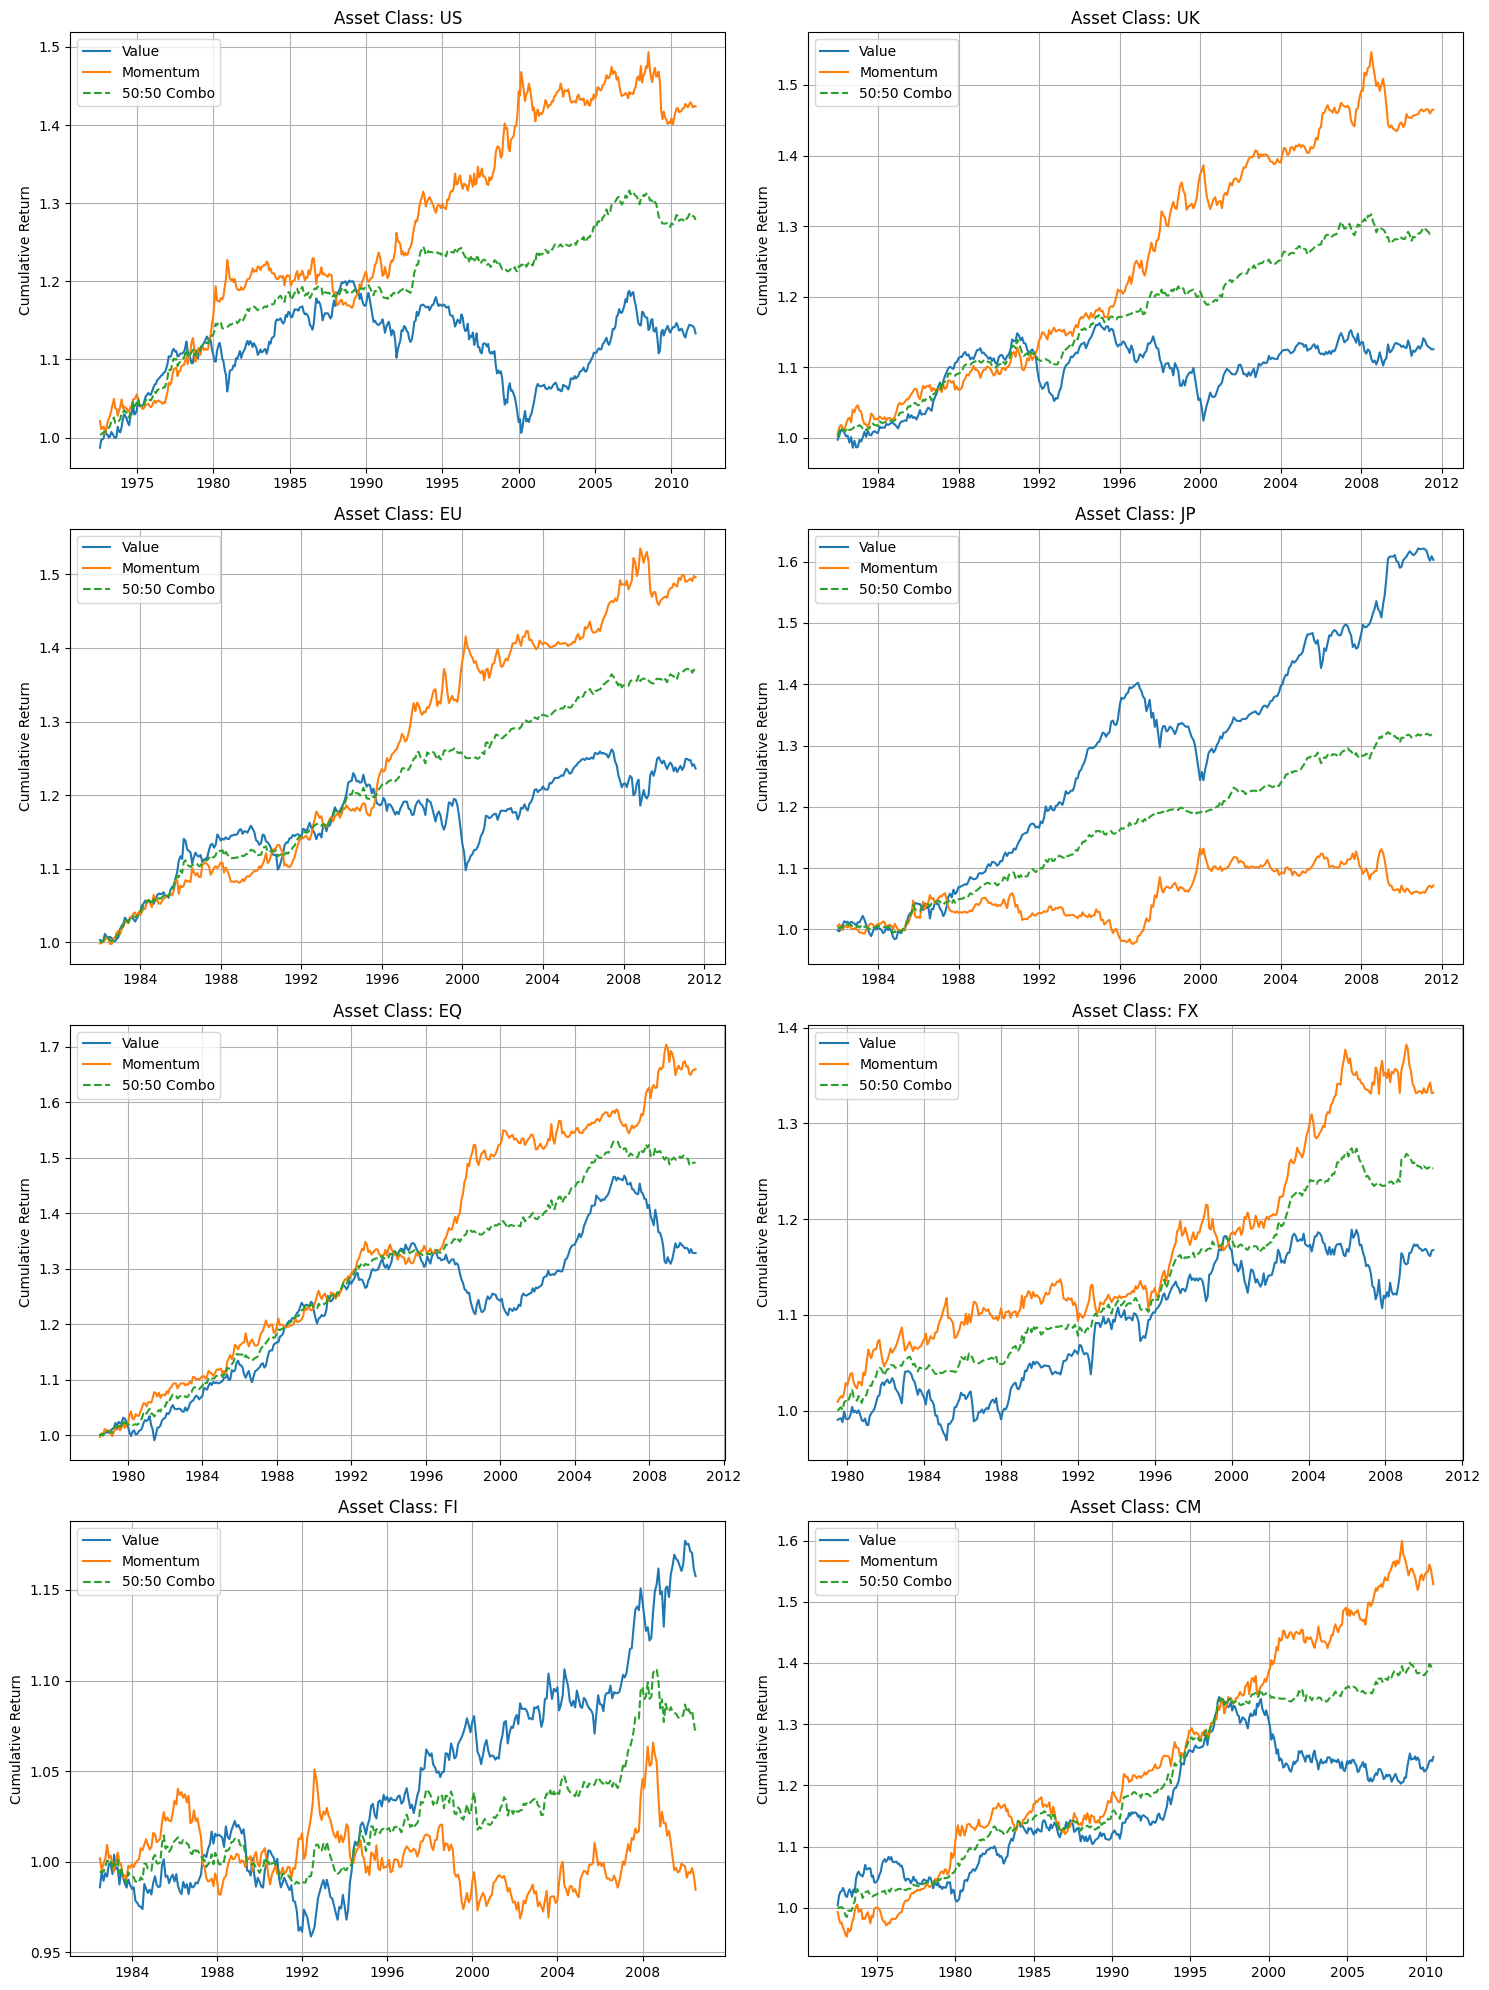

In [5]:
# === 1. 파일 로드 및 팩터 수익률 계산 ===
file_path = 'Value and Momentum Everywhere Original Paper Data.xlsx'
df_factors = load_vme_portfolios(file_path)

# === 2. 변동성 스케일링 적용 ===
# 각 VAL_자산군 및 MOM_자산군 컬럼에 대해 변동성 스케일링을 적용합니다.
# lookback_months=36 (기본값) 및 min_lookback_months=6 적용
scaled_df_portfolios = pd.DataFrame(index=df_factors.index)
asset_classes = ['US', 'UK', 'EU', 'JP', 'EQ', 'FX', 'FI', 'CM']
for asset in asset_classes:
    val_col = f'VAL_{asset}'
    mom_col = f'MOM_{asset}'
    
    if val_col in df_factors.columns and mom_col in df_factors.columns:
        # VAL 팩터 수익률 스케일링
        scaled_df_portfolios[val_col] = volatility_scale_monthly_returns(
            df_factors[val_col], lookback_months=36, min_lookback_months=6, annual_vol_target=0.02
        )
        # MOM 팩터 수익률 스케일링
        scaled_df_portfolios[mom_col] = volatility_scale_monthly_returns(
            df_factors[mom_col], lookback_months=36, min_lookback_months=6, annual_vol_target=0.02
        )
    else:
        print(f"⚠️ Skipping scaling for {asset}: Missing original columns.")

# === 3. 자산군별 누적 수익률 시각화 (스케일링된 데이터 사용) ===
# plot_all_asset_class_cumulative_returns(scaled_df_portfolios)
plot_all_asset_class_cumulative_returns_grid(scaled_df_portfolios)

## 머신러닝

[US] Metrics:
 {'All': {'accuracy': 0.6486486486486487, 'classification_report': {'0': {'precision': 0.5882352941176471, 'recall': 0.625, 'f1-score': 0.6060606060606061, 'support': 16.0}, '1': {'precision': 0.7, 'recall': 0.6666666666666666, 'f1-score': 0.6829268292682927, 'support': 21.0}, 'accuracy': 0.6486486486486487, 'macro avg': {'precision': 0.6441176470588235, 'recall': 0.6458333333333333, 'f1-score': 0.6444937176644494, 'support': 37.0}, 'weighted avg': {'precision': 0.6516693163751986, 'recall': 0.6486486486486487, 'f1-score': 0.6496873813946985, 'support': 37.0}}, 'confusion_matrix': array([[10,  6],
       [ 7, 14]])}, 'Individual': {'accuracy': 0.5675675675675675, 'classification_report': {'0': {'precision': 0.5, 'recall': 0.4375, 'f1-score': 0.4666666666666667, 'support': 16.0}, '1': {'precision': 0.6086956521739131, 'recall': 0.6666666666666666, 'f1-score': 0.6363636363636364, 'support': 21.0}, 'accuracy': 0.5675675675675675, 'macro avg': {'precision': 0.5543478260869565

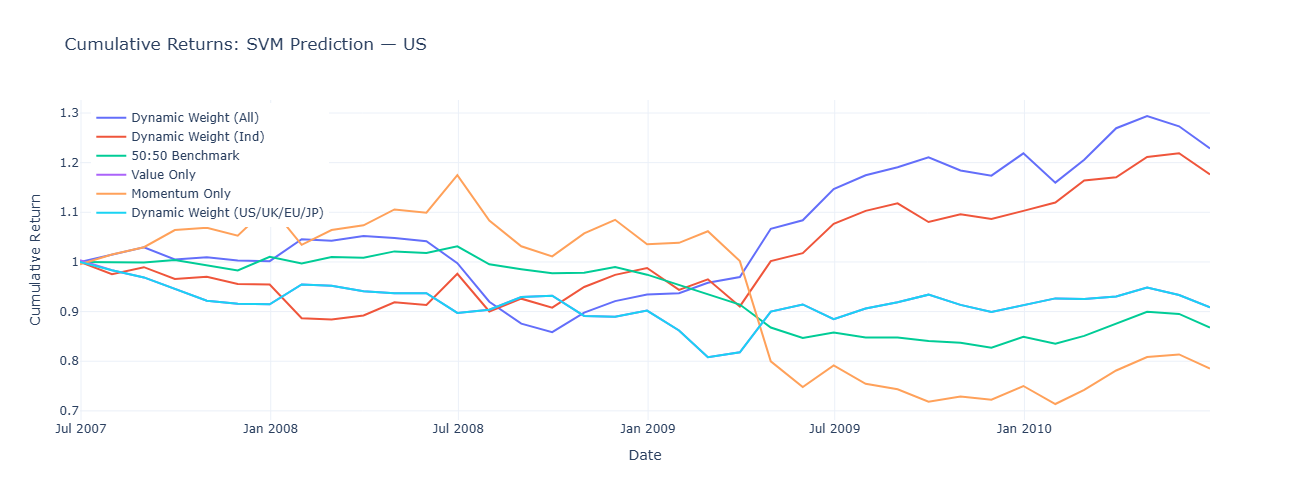

[UK] Metrics:
 {'All': {'accuracy': 0.5945945945945946, 'classification_report': {'0': {'precision': 0.5333333333333333, 'recall': 0.5, 'f1-score': 0.5161290322580645, 'support': 16.0}, '1': {'precision': 0.6363636363636364, 'recall': 0.6666666666666666, 'f1-score': 0.6511627906976745, 'support': 21.0}, 'accuracy': 0.5945945945945946, 'macro avg': {'precision': 0.5848484848484848, 'recall': 0.5833333333333333, 'f1-score': 0.5836459114778695, 'support': 37.0}, 'weighted avg': {'precision': 0.5918099918099918, 'recall': 0.5945945945945946, 'f1-score': 0.5927698140751405, 'support': 37.0}}, 'confusion_matrix': array([[ 8,  8],
       [ 7, 14]])}, 'Individual': {'accuracy': 0.5675675675675675, 'classification_report': {'0': {'precision': 0.5, 'recall': 0.5, 'f1-score': 0.5, 'support': 16.0}, '1': {'precision': 0.6190476190476191, 'recall': 0.6190476190476191, 'f1-score': 0.6190476190476191, 'support': 21.0}, 'accuracy': 0.5675675675675675, 'macro avg': {'precision': 0.5595238095238095, 're

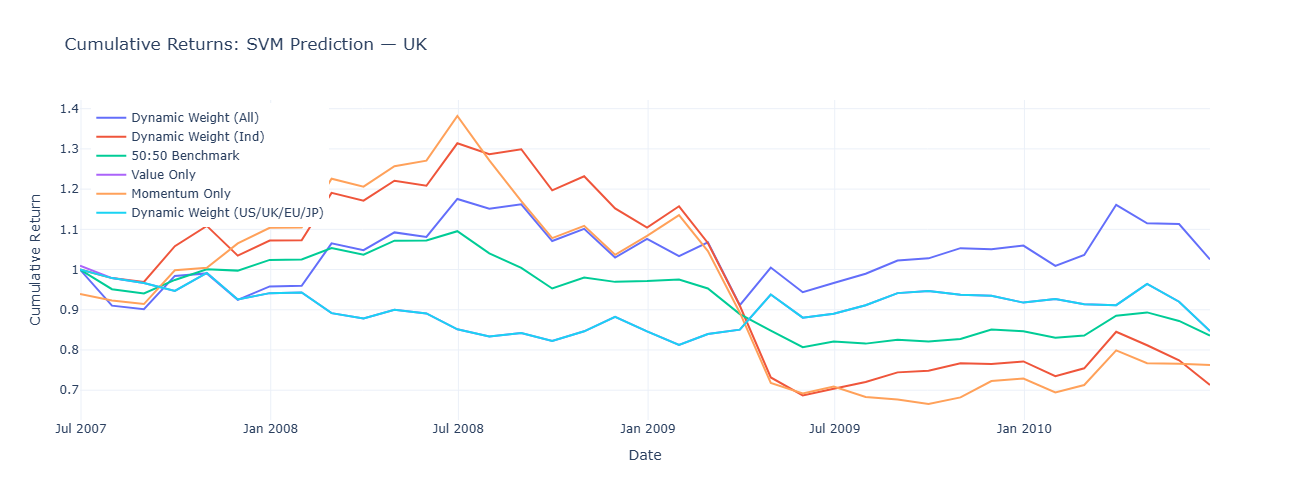

[EU] Metrics:
 {'All': {'accuracy': 0.7027027027027027, 'classification_report': {'0': {'precision': 0.6190476190476191, 'recall': 0.8125, 'f1-score': 0.7027027027027027, 'support': 16.0}, '1': {'precision': 0.8125, 'recall': 0.6190476190476191, 'f1-score': 0.7027027027027027, 'support': 21.0}, 'accuracy': 0.7027027027027027, 'macro avg': {'precision': 0.7157738095238095, 'recall': 0.7157738095238095, 'f1-score': 0.7027027027027027, 'support': 37.0}, 'weighted avg': {'precision': 0.7288449163449163, 'recall': 0.7027027027027027, 'f1-score': 0.7027027027027027, 'support': 37.0}}, 'confusion_matrix': array([[13,  3],
       [ 8, 13]])}, 'Individual': {'accuracy': 0.7027027027027027, 'classification_report': {'0': {'precision': 0.6190476190476191, 'recall': 0.8125, 'f1-score': 0.7027027027027027, 'support': 16.0}, '1': {'precision': 0.8125, 'recall': 0.6190476190476191, 'f1-score': 0.7027027027027027, 'support': 21.0}, 'accuracy': 0.7027027027027027, 'macro avg': {'precision': 0.715773809

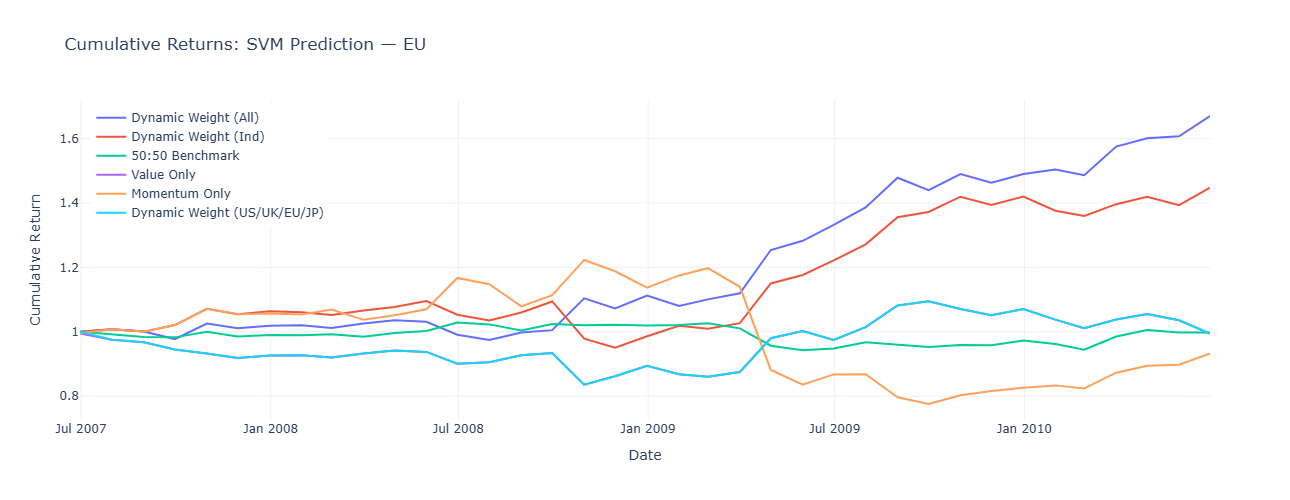

[JP] Metrics:
 {'All': {'accuracy': 0.43243243243243246, 'classification_report': {'0': {'precision': 0.5625, 'recall': 0.391304347826087, 'f1-score': 0.46153846153846156, 'support': 23.0}, '1': {'precision': 0.3333333333333333, 'recall': 0.5, 'f1-score': 0.4, 'support': 14.0}, 'accuracy': 0.43243243243243246, 'macro avg': {'precision': 0.44791666666666663, 'recall': 0.44565217391304346, 'f1-score': 0.4307692307692308, 'support': 37.0}, 'weighted avg': {'precision': 0.47578828828828823, 'recall': 0.43243243243243246, 'f1-score': 0.43825363825363833, 'support': 37.0}}, 'confusion_matrix': array([[ 9, 14],
       [ 7,  7]])}, 'Individual': {'accuracy': 0.6216216216216216, 'classification_report': {'0': {'precision': 0.6216216216216216, 'recall': 1.0, 'f1-score': 0.7666666666666667, 'support': 23.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 14.0}, 'accuracy': 0.6216216216216216, 'macro avg': {'precision': 0.3108108108108108, 'recall': 0.5, 'f1-score': 0.383333333

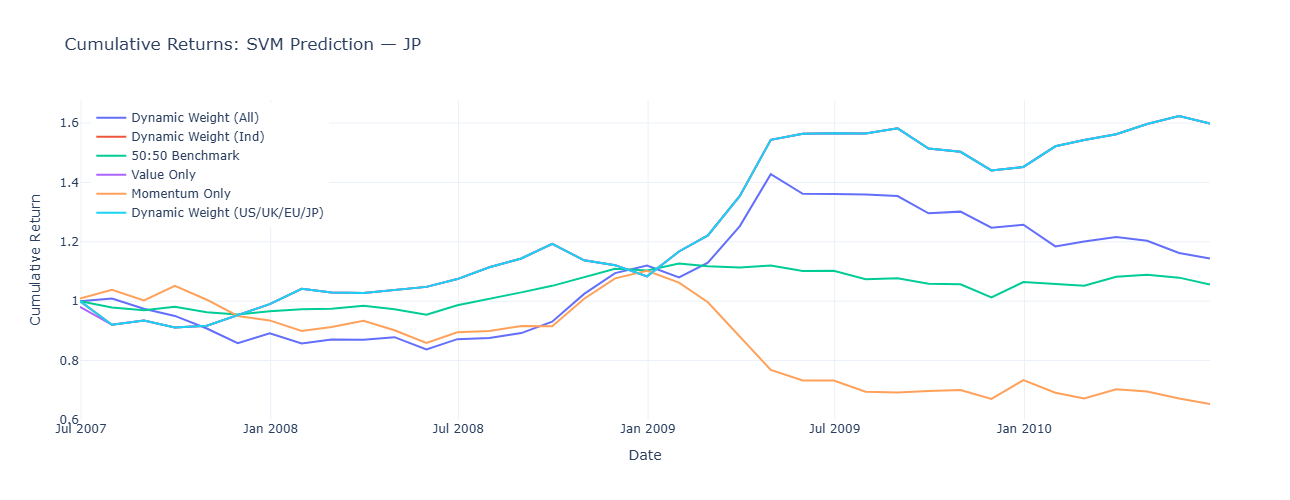

[EQ] Metrics:
 {'All': {'accuracy': 0.5945945945945946, 'classification_report': {'0': {'precision': 0.42857142857142855, 'recall': 0.75, 'f1-score': 0.5454545454545454, 'support': 12.0}, '1': {'precision': 0.8125, 'recall': 0.52, 'f1-score': 0.6341463414634146, 'support': 25.0}, 'accuracy': 0.5945945945945946, 'macro avg': {'precision': 0.6205357142857143, 'recall': 0.635, 'f1-score': 0.5898004434589801, 'support': 37.0}, 'weighted avg': {'precision': 0.6879826254826255, 'recall': 0.5945945945945946, 'f1-score': 0.6053814346497273, 'support': 37.0}}, 'confusion_matrix': array([[ 9,  3],
       [12, 13]])}, 'Individual': {'accuracy': 0.5405405405405406, 'classification_report': {'0': {'precision': 0.2727272727272727, 'recall': 0.25, 'f1-score': 0.2608695652173913, 'support': 12.0}, '1': {'precision': 0.6538461538461539, 'recall': 0.68, 'f1-score': 0.6666666666666666, 'support': 25.0}, 'accuracy': 0.5405405405405406, 'macro avg': {'precision': 0.4632867132867133, 'recall': 0.465, 'f1-sc

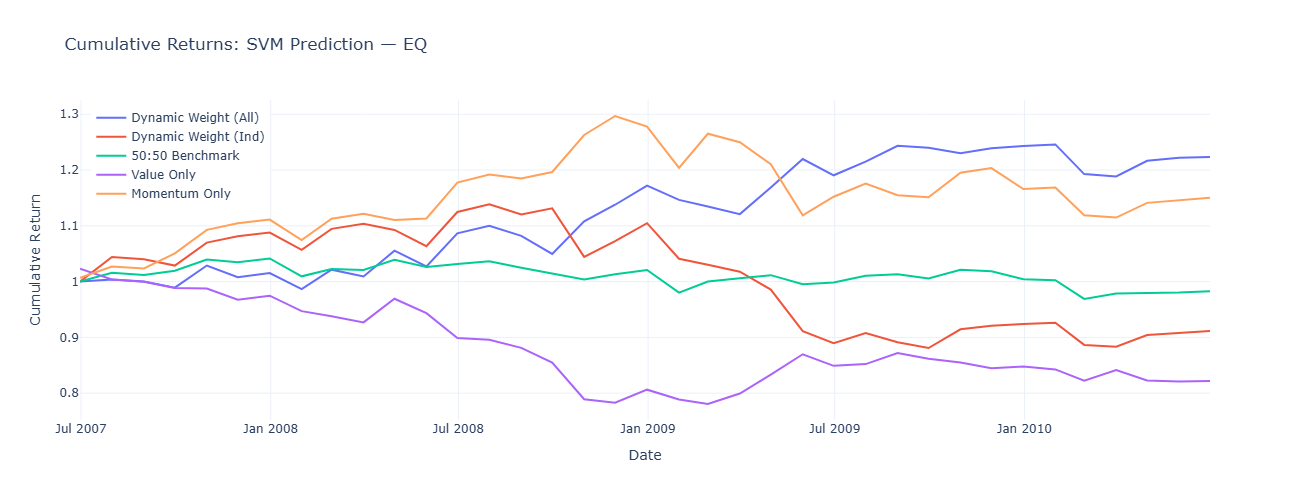

[FX] Metrics:
 {'All': {'accuracy': 0.5945945945945946, 'classification_report': {'0': {'precision': 0.5789473684210527, 'recall': 0.6111111111111112, 'f1-score': 0.5945945945945946, 'support': 18.0}, '1': {'precision': 0.6111111111111112, 'recall': 0.5789473684210527, 'f1-score': 0.5945945945945946, 'support': 19.0}, 'accuracy': 0.5945945945945946, 'macro avg': {'precision': 0.5950292397660819, 'recall': 0.5950292397660819, 'f1-score': 0.5945945945945946, 'support': 37.0}, 'weighted avg': {'precision': 0.5954638849375692, 'recall': 0.5945945945945946, 'f1-score': 0.5945945945945946, 'support': 37.0}}, 'confusion_matrix': array([[11,  7],
       [ 8, 11]])}, 'Individual': {'accuracy': 0.5135135135135135, 'classification_report': {'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 18.0}, '1': {'precision': 0.5135135135135135, 'recall': 1.0, 'f1-score': 0.6785714285714286, 'support': 19.0}, 'accuracy': 0.5135135135135135, 'macro avg': {'precision': 0.25675675675675674, 'r

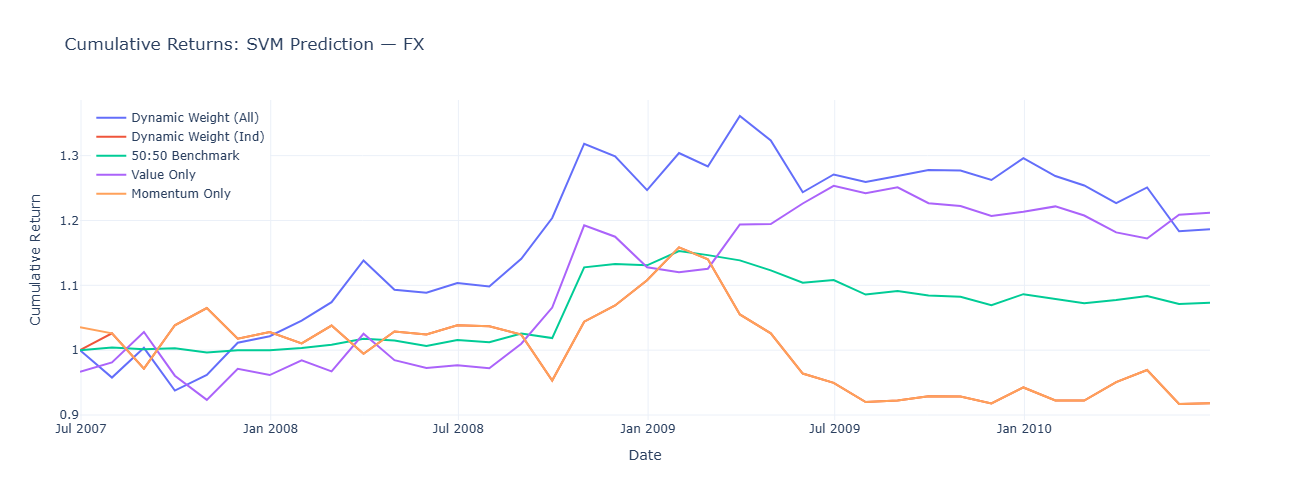

[FI] Metrics:
 {'All': {'accuracy': 0.5135135135135135, 'classification_report': {'0': {'precision': 0.5555555555555556, 'recall': 0.5, 'f1-score': 0.5263157894736842, 'support': 20.0}, '1': {'precision': 0.47368421052631576, 'recall': 0.5294117647058824, 'f1-score': 0.5, 'support': 17.0}, 'accuracy': 0.5135135135135135, 'macro avg': {'precision': 0.5146198830409356, 'recall': 0.5147058823529411, 'f1-score': 0.513157894736842, 'support': 37.0}, 'weighted avg': {'precision': 0.5179389916232021, 'recall': 0.5135135135135135, 'f1-score': 0.5142247510668564, 'support': 37.0}}, 'confusion_matrix': array([[10, 10],
       [ 8,  9]])}, 'Individual': {'accuracy': 0.4594594594594595, 'classification_report': {'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 20.0}, '1': {'precision': 0.4594594594594595, 'recall': 1.0, 'f1-score': 0.6296296296296297, 'support': 17.0}, 'accuracy': 0.4594594594594595, 'macro avg': {'precision': 0.22972972972972974, 'recall': 0.5, 'f1-score': 0.314

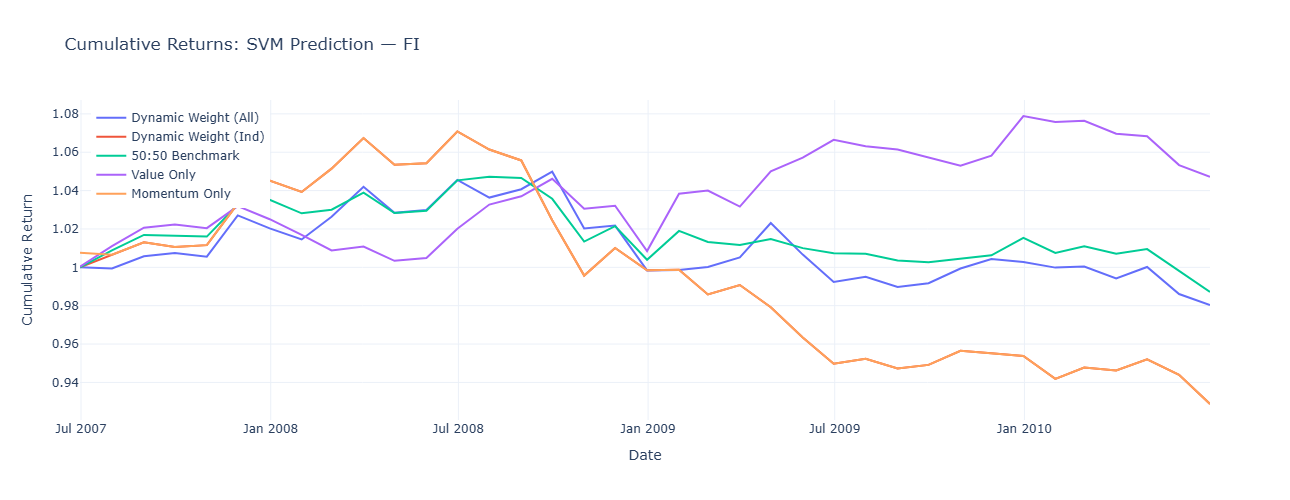

[CM] Metrics:
 {'All': {'accuracy': 0.5135135135135135, 'classification_report': {'0': {'precision': 0.5454545454545454, 'recall': 0.6, 'f1-score': 0.5714285714285714, 'support': 20.0}, '1': {'precision': 0.4666666666666667, 'recall': 0.4117647058823529, 'f1-score': 0.4375, 'support': 17.0}, 'accuracy': 0.5135135135135135, 'macro avg': {'precision': 0.5060606060606061, 'recall': 0.5058823529411764, 'f1-score': 0.5044642857142857, 'support': 37.0}, 'weighted avg': {'precision': 0.5092547092547093, 'recall': 0.5135135135135135, 'f1-score': 0.5098938223938223, 'support': 37.0}}, 'confusion_matrix': array([[12,  8],
       [10,  7]])}, 'Individual': {'accuracy': 0.4594594594594595, 'classification_report': {'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 20.0}, '1': {'precision': 0.4594594594594595, 'recall': 1.0, 'f1-score': 0.6296296296296297, 'support': 17.0}, 'accuracy': 0.4594594594594595, 'macro avg': {'precision': 0.22972972972972974, 'recall': 0.5, 'f1-score': 0.

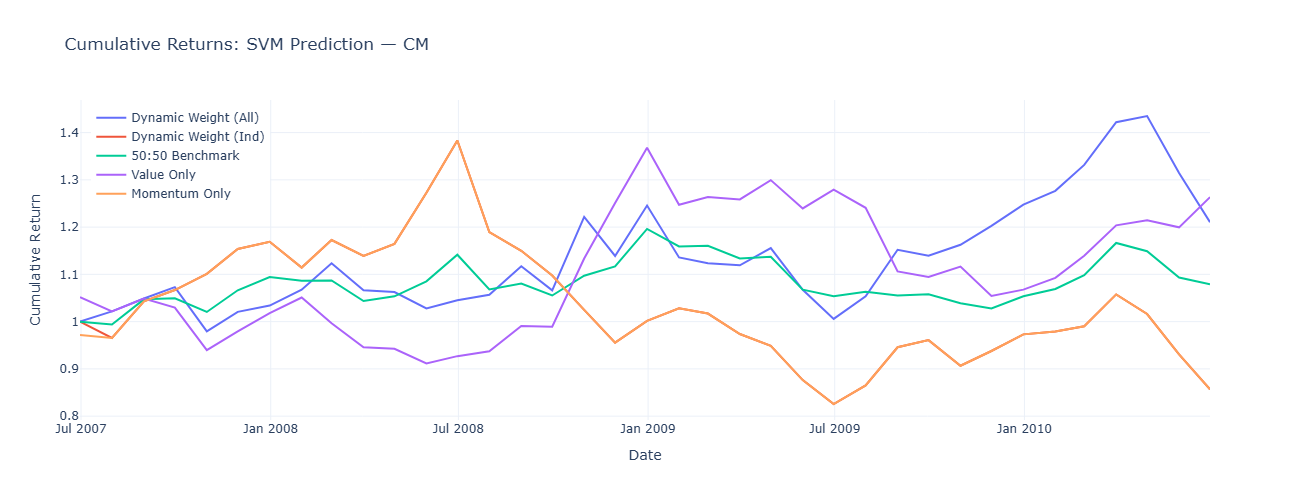

Metrics saved to svm_classification_metrics.csv

CSV Preview:
   Asset    Strategy  Accuracy  Precision (Value)  Recall (Value)  \
0     US         All  0.648649           0.588235        0.625000   
1     US  Individual  0.567568           0.500000        0.437500   
2     US      Subset  0.432432           0.432432        1.000000   
3     UK         All  0.594595           0.533333        0.500000   
4     UK  Individual  0.567568           0.500000        0.500000   
5     UK      Subset  0.432432           0.432432        1.000000   
6     EU         All  0.702703           0.619048        0.812500   
7     EU  Individual  0.702703           0.619048        0.812500   
8     EU      Subset  0.432432           0.432432        1.000000   
9     JP         All  0.432432           0.562500        0.391304   
10    JP  Individual  0.621622           0.621622        1.000000   
11    JP      Subset  0.621622           0.621622        1.000000   
12    EQ         All  0.594595           

In [9]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # 추가
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

def make_val_split(n_train: int, n_val: int) -> PredefinedSplit:
    test_fold = np.concatenate([np.full(n_train, -1), np.zeros(n_val)])
    return PredefinedSplit(test_fold)

# === 1. Volatility Scaling Function ===
def volatility_scale_monthly_returns(series, lookback_months=36, min_lookback_months=6, annual_vol_target=0.02):
    scaled_series = pd.Series(np.nan, index=series.index)
    monthly_vol_target = annual_vol_target / np.sqrt(12)
    rolling_std_monthly = series.rolling(window=lookback_months, min_periods=min_lookback_months).std()
    for i in range(len(series)):
        current_return = series.iloc[i]
        current_rolling_std = rolling_std_monthly.iloc[i]
        if pd.notna(current_rolling_std) and current_rolling_std > 0:
            scaled_r = (current_return / current_rolling_std) * monthly_vol_target
            scaled_series.iloc[i] = scaled_r
        else:
            scaled_series.iloc[i] = np.nan
    return scaled_series

# === 2. VME 포트폴리오 데이터 로드 및 팩터 수익률 계산 ===
def load_vme_portfolios(filepath):
    df = pd.read_excel(filepath, sheet_name='VME Portfolios', header=12)
    df['DATE'] = pd.to_datetime(df['DATE'])
    df = df.set_index('DATE')
    df = df.applymap(lambda x: float(str(x).replace('%', '')) / 100 if pd.notnull(x) and isinstance(x, str) and '%' in str(x) else x)
    asset_classes = ['US', 'UK', 'EU', 'JP', 'EQ', 'FX', 'FI', 'CM']
    val_returns, mom_returns = {}, {}
    for asset in asset_classes:
        try:
            val_returns[f'VAL_{asset}'] = df[f'VAL3{asset}'] - df[f'VAL1{asset}']
            mom_returns[f'MOM_{asset}'] = df[f'MOM3{asset}'] - df[f'MOM1{asset}']
        except KeyError:
            print(f"[경고] {asset} 관련 열이 누락됨")
    df_factors = pd.DataFrame({**val_returns, **mom_returns})
    return df_factors

# === 3. Sequence + Label 생성 ===
def create_sigmoid_weight_labels(df, lookback=12, std_window=36):
    df = df.copy()
    df['margin'] = df['MOM'] - df['VAL']
    df['margin_std'] = df['margin'].rolling(window=std_window, min_periods=6).std()
    df['scaled_margin'] = df['margin'] / df['margin_std']
    X, y, dates = [], [], []
    for i in range(max(lookback, std_window), len(df)):
        window_val_mom = df[['VAL', 'MOM']].iloc[i - lookback:i]
        if len(window_val_mom.dropna()) < 2:
            corr_val_mom = 0.0
        else:
            corr_matrix = window_val_mom.corr()
            corr_val_mom = corr_matrix.loc['VAL', 'MOM']
            if pd.isna(corr_val_mom):
                corr_val_mom = 0.0
        seq_flat = window_val_mom.values.flatten()
        current_sample_features = np.append(seq_flat, corr_val_mom)
        target_margin = df['scaled_margin'].iloc[i]
        if not pd.isna(target_margin):
            mom_weight = (target_margin > 0).astype(int)
            X.append(current_sample_features)
            y.append(mom_weight)
            dates.append(df.index[i])
    return np.array(X), np.array(y), dates

# === 4. 모든 주식 시장 데이터 가져오기 ===
def get_all_stock_market_sequences(df_portfolios, stock_assets_list, lookback_feat=12, lookback_std=36, annual_vol=0.02, min_periods_vol=6):
    all_X_seq = []
    all_y_seq = []
    all_dates = []
    for s_asset in stock_assets_list:
        val_col_s = f'VAL_{s_asset}'
        mom_col_s = f'MOM_{s_asset}'
        if val_col_s not in df_portfolios.columns or mom_col_s not in df_portfolios.columns:
            print(f"Skipping {s_asset}: Missing columns {val_col_s} or {mom_col_s}")
            continue
        df_s_raw = df_portfolios[[val_col_s, mom_col_s]].copy()
        df_s_raw.columns = ['VAL', 'MOM']
        df_s_raw['VAL'] = volatility_scale_monthly_returns(
            df_s_raw['VAL'], lookback_months=lookback_std, min_lookback_months=min_periods_vol, annual_vol_target=annual_vol
        )
        df_s_raw['MOM'] = volatility_scale_monthly_returns(
            df_s_raw['MOM'], lookback_months=lookback_std, min_lookback_months=min_periods_vol, annual_vol_target=annual_vol
        )
        df_s_cleaned = df_s_raw.dropna()
        if df_s_cleaned.empty:
            print(f"⚠️ Skipping {s_asset}: No valid data after volatility scaling for sequence creation.")
            continue
        X_s, y_s, dates_s = create_sigmoid_weight_labels(df_s_cleaned, lookback=lookback_feat, std_window=lookback_std)
        if X_s.size > 0:
            all_X_seq.append(X_s)
            all_y_seq.append(y_s)
            all_dates.extend(dates_s)
    combined_X_seq = np.vstack(all_X_seq) if all_X_seq else np.array([])
    combined_y_seq = np.hstack(all_y_seq) if all_y_seq else np.array([])
    if combined_X_seq.size > 0:
        temp_df = pd.DataFrame({'X': list(combined_X_seq), 'y': combined_y_seq}, index=all_dates)
        temp_df.index = pd.to_datetime(temp_df.index)
        temp_df = temp_df.sort_index()
        sorted_X_seq = np.array(list(temp_df['X'].values))
        sorted_y_seq = temp_df['y'].values
        sorted_dates = pd.Series(temp_df.index.values)
    else:
        sorted_X_seq = np.array([])
        sorted_y_seq = np.array([])
        sorted_dates = pd.Series([])
    return sorted_X_seq, sorted_y_seq, sorted_dates

# === 5. SVM with Vol-Scaled Returns ===
def run_svm_prediction(full_df_portfolios, current_val_col, current_mom_col,
                       lookback_feat=12, lookback_std=36,
                       annual_vol_target=0.02, min_periods_vol=6):
    current_asset_abbr = current_val_col.split('_')[-1]
    stock_asset_classes = ['US', 'UK', 'EU', 'JP', 'EQ', 'FX', 'FI', 'CM']
    # 1) 데이터 슬라이싱
    full_df_portfolios = full_df_portfolios.loc[:'2010-06-30'].copy()
    # 2) 통합 학습 시퀀스
    X_all, y_all, d_all = get_all_stock_market_sequences(
        full_df_portfolios, stock_asset_classes,
        lookback_feat, lookback_std, annual_vol_target, min_periods_vol)
    if d_all.empty:
        print("⚠️ 통합 학습 데이터 없음")
        return None, None, None, None
    # 3) 현재 자산 시퀀스
    df_cur = full_df_portfolios[[current_val_col, current_mom_col]].copy()
    df_cur.columns = ['VAL', 'MOM']
    df_cur['VAL'] = volatility_scale_monthly_returns(
        df_cur['VAL'], lookback_std, min_periods_vol, annual_vol_target)
    df_cur['MOM'] = volatility_scale_monthly_returns(
        df_cur['MOM'], lookback_std, min_periods_vol, annual_vol_target)
    df_cur.dropna(inplace=True)
    if df_cur.empty:
        return None, None, None, None
    X_cur, y_cur, d_cur_list = create_sigmoid_weight_labels(
        df_cur, lookback_feat, lookback_std)
    d_cur = pd.Series(d_cur_list)
    # 4) 날짜 분할
    last_date = d_all.max()
    cutoff_test = last_date - pd.DateOffset(years=3)
    cutoff_val = cutoff_test - pd.DateOffset(years=3)
    tr_mask_all = d_all < cutoff_val
    val_mask_all = (d_all >= cutoff_val) & (d_all < cutoff_test)
    test_mask_cur = d_cur >= cutoff_test
    tr_mask_ind = d_cur < cutoff_val
    val_mask_ind = (d_cur >= cutoff_val) & (d_cur < cutoff_test)
    X_train_all, y_train_all = X_all[tr_mask_all], y_all[tr_mask_all]
    X_val_all, y_val_all = X_all[val_mask_all], y_all[val_mask_all]
    X_train_ind, y_train_ind = X_cur[tr_mask_ind], y_cur[tr_mask_ind]
    X_val_ind, y_val_ind = X_cur[val_mask_ind], y_cur[val_mask_ind]
    X_test_cur, y_test_cur = X_cur[test_mask_cur], y_cur[test_mask_cur]
    test_dates = d_cur[test_mask_cur]
    # 5) 파이프라인·파라미터
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(random_state=42))
    ])
    param_grid = {
        'svc__kernel': ['rbf', 'linear'],
        'svc__C': [0.1, 1, 10],
        'svc__gamma': ['scale', 'auto']
    }
    # (A) 통합 모델
    if len(X_val_all):
        ps_all = make_val_split(len(X_train_all), len(X_val_all))
        X_tv_all = np.vstack([X_train_all, X_val_all])
        y_tv_all = np.hstack([y_train_all, y_val_all])
        grid = GridSearchCV(pipeline, param_grid, cv=ps_all,
                            scoring='accuracy', n_jobs=-1, return_train_score=True)
        grid.fit(X_tv_all, y_tv_all)
    else:
        grid = GridSearchCV(pipeline, param_grid,
                            cv=TimeSeriesSplit(n_splits=3),
                            scoring='accuracy', n_jobs=-1, return_train_score=True)
        grid.fit(X_train_all, y_train_all)
    # (B) 개별 모델
    if len(X_val_ind):
        ps_ind = make_val_split(len(X_train_ind), len(X_val_ind))
        X_tv_ind = np.vstack([X_train_ind, X_val_ind])
        y_tv_ind = np.hstack([y_train_ind, y_val_ind])
        grid_ind = GridSearchCV(pipeline, param_grid, cv=ps_ind,
                                scoring='accuracy', n_jobs=-1, return_train_score=True)
        grid_ind.fit(X_tv_ind, y_tv_ind)
    else:
        grid_ind = GridSearchCV(pipeline, param_grid,
                                cv=TimeSeriesSplit(n_splits=3),
                                scoring='accuracy', n_jobs=-1, return_train_score=True)
        grid_ind.fit(X_train_ind, y_train_ind)
    # (C) 서브셋 모델 (선택)
    subset_stock_classes = ['US', 'UK', 'EU', 'JP']
    grid_sub = None
    if current_asset_abbr in subset_stock_classes:
        X_sub, y_sub, d_sub = get_all_stock_market_sequences(
            full_df_portfolios, subset_stock_classes,
            lookback_feat, lookback_std, annual_vol_target, min_periods_vol)
        tr_mask_sub = d_sub < cutoff_val
        val_mask_sub = (d_sub >= cutoff_val) & (d_sub < cutoff_test)
        X_train_sub, y_train_sub = X_sub[tr_mask_sub], y_sub[tr_mask_sub]
        X_val_sub, y_val_sub = X_sub[val_mask_sub], y_sub[val_mask_sub]
        if len(X_val_sub):
            ps_sub = make_val_split(len(X_train_sub), len(X_val_sub))
            X_tv_sub = np.vstack([X_train_sub, X_val_sub])
            y_tv_sub = np.hstack([y_train_sub, y_val_sub])
            grid_sub = GridSearchCV(pipeline, param_grid, cv=ps_sub,
                                    scoring='accuracy', n_jobs=-1, return_train_score=True)
            grid_sub.fit(X_tv_sub, y_tv_sub)
        elif len(X_train_sub) >= 4:
            grid_sub = GridSearchCV(pipeline, param_grid,
                                    cv=TimeSeriesSplit(n_splits=3),
                                    scoring='accuracy', n_jobs=-1, return_train_score=True)
            grid_sub.fit(X_train_sub, y_train_sub)
    # 6) 예측
    mom_w_all = np.clip(grid.predict(X_test_cur), 0, 1)
    val_w_all = 1 - mom_w_all
    mom_w_ind = np.clip(grid_ind.predict(X_test_cur), 0, 1)
    val_w_ind = 1 - mom_w_ind
    if grid_sub:
        mom_w_sub = np.clip(grid_sub.predict(X_test_cur), 0, 1)
        val_w_sub = 1 - mom_w_sub
    # 7) 분류 성능 계산
    metrics = {}
    metrics['All'] = {
        'accuracy': accuracy_score(y_test_cur, mom_w_all),
        'classification_report': classification_report(y_test_cur, mom_w_all, output_dict=True),
        'confusion_matrix': confusion_matrix(y_test_cur, mom_w_all)
    }
    metrics['Individual'] = {
        'accuracy': accuracy_score(y_test_cur, mom_w_ind),
        'classification_report': classification_report(y_test_cur, mom_w_ind, output_dict=True),
        'confusion_matrix': confusion_matrix(y_test_cur, mom_w_ind)
    }
    if grid_sub:
        metrics['Subset'] = {
            'accuracy': accuracy_score(y_test_cur, mom_w_sub),
            'classification_report': classification_report(y_test_cur, mom_w_sub, output_dict=True),
            'confusion_matrix': confusion_matrix(y_test_cur, mom_w_sub)
        }
    # 8) 실제 수익률 → 누적 수익률
    val_ret = full_df_portfolios.loc[test_dates, current_val_col]
    mom_ret = full_df_portfolios.loc[test_dates, current_mom_col]
    def cum_series(vw, mw):
        pnl = vw * val_ret + mw * mom_ret
        cum = (1 + pnl).cumprod()
        cum.iloc[0] = 1.0
        return cum
    curves = {
        'Dynamic Weight (All)': cum_series(val_w_all, val_w_all ^ 1),
        'Dynamic Weight (Ind)': cum_series(val_w_ind, val_w_ind ^ 1),
        '50:50 Benchmark': cum_series(0.5, 0.5),
        'Value Only': (1 + val_ret).cumprod(),
        'Momentum Only': (1 + mom_ret).cumprod()
    }
    if grid_sub:
        curves['Dynamic Weight (US/UK/EU/JP)'] = cum_series(val_w_sub, val_w_sub ^ 1)
    # 9) Plot
    fig = go.Figure()
    for name, ser in curves.items():
        fig.add_trace(go.Scatter(x=ser.index, y=ser, mode='lines', name=name))
    fig.update_layout(
        title=f'Cumulative Returns: SVM Prediction — {current_asset_abbr}',
        xaxis_title='Date', yaxis_title='Cumulative Return',
        legend=dict(x=0.01, y=0.99), template='plotly_white',
        width=900, height=500
    )
    return curves, metrics, test_dates, fig

# === 6. 실행 ===
results = {}  # results 딕셔너리 초기화
file_path = 'Value and Momentum Everywhere Original Paper Data.xlsx'
df_portfolios = load_vme_portfolios(file_path)
asset_classes_to_process = ['US', 'UK', 'EU', 'JP', 'EQ', 'FX', 'FI', 'CM']
metrics_list = []  # CSV 출력을 위한 리스트

for asset in asset_classes_to_process:
    val_col = f'VAL_{asset}'
    mom_col = f'MOM_{asset}'
    if val_col in df_portfolios.columns and mom_col in df_portfolios.columns:
        try:
            curves, metrics, test_dates, fig = run_svm_prediction(
                df_portfolios, val_col, mom_col,
                lookback_feat=36, lookback_std=36,
                annual_vol_target=0.02, min_periods_vol=6
            )
            if fig:
                results[asset] = {'curves': curves, 'metrics': metrics, 'fig': fig}
                print(f"[{asset}] Metrics:\n", metrics)
                fig.show()
                
                # CSV 데이터 수집
                for strategy in metrics:
                    row = {
                        'Asset': asset,
                        'Strategy': strategy,
                        'Accuracy': metrics[strategy]['accuracy'],
                        'Precision (Value)': metrics[strategy]['classification_report']['0']['precision'],
                        'Recall (Value)': metrics[strategy]['classification_report']['0']['recall'],
                        'F1-Score (Value)': metrics[strategy]['classification_report']['0']['f1-score'],
                        'Precision (Momentum)': metrics[strategy]['classification_report']['1']['precision'],
                        'Recall (Momentum)': metrics[strategy]['classification_report']['1']['recall'],
                        'F1-Score (Momentum)': metrics[strategy]['classification_report']['1']['f1-score']
                    }
                    metrics_list.append(row)
        except Exception as e:
            print(f"[{asset}] run_svm_prediction 호출 중 오류 발생:", e)
    else:
        print(f"[{asset}] 누락된 컬럼: {val_col} or {mom_col}")

# 평균값 계산
metrics_df = pd.DataFrame(metrics_list)
avg_metrics = metrics_df.groupby('Strategy').mean(numeric_only=True).reset_index()
avg_metrics['Asset'] = 'Avg'
metrics_df = pd.concat([metrics_df, avg_metrics], ignore_index=True)

# CSV로 저장
metrics_df.to_csv('svm_classification_metrics.csv', index=False)
print("Metrics saved to svm_classification_metrics.csv")

# CSV 출력 예시
print("\nCSV Preview:")
print(metrics_df)

In [12]:
# ─── 필요 라이브러리 ──────────────────────────────────────────────────────────
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# ─── PredefinedSplit 만드는 헬퍼 (동일) ─────────────────────────────────────────
def make_val_split(n_train: int, n_val: int) -> PredefinedSplit:
    test_fold = np.concatenate([np.full(n_train, -1), np.zeros(n_val)])
    return PredefinedSplit(test_fold)

# ─── XGBoost 버전 메인 함수 ───────────────────────────────────────────────────
def run_xgb_prediction(full_df_portfolios, current_val_col, current_mom_col,
                       lookback_feat=12, lookback_std=36,
                       annual_vol_target=0.02, min_periods_vol=6):

    current_asset_abbr = current_val_col.split('_')[-1]
    stock_asset_classes  = ['US', 'UK', 'EU', 'JP', 'EQ', 'FX', 'FI', 'CM']
    subset_stock_classes = ['US', 'UK', 'EU', 'JP']

    # 1) 데이터 슬라이싱 (논문 조건 동일)
    full_df_portfolios = full_df_portfolios.loc[:'2010-06-30'].copy()

    # 2) 통합 학습 시퀀스
    X_all, y_all, d_all = get_all_stock_market_sequences(
        full_df_portfolios, stock_asset_classes,
        lookback_feat, lookback_std, annual_vol_target, min_periods_vol)
    if d_all.empty: return None

    # 3) 현재 자산 시퀀스 (test·val 경계용)
    df_cur = full_df_portfolios[[current_val_col, current_mom_col]].copy()
    df_cur.columns = ['VAL', 'MOM']
    df_cur['VAL'] = volatility_scale_monthly_returns(
        df_cur['VAL'], lookback_std, min_periods_vol, annual_vol_target)
    df_cur['MOM'] = volatility_scale_monthly_returns(
        df_cur['MOM'], lookback_std, min_periods_vol, annual_vol_target)
    df_cur.dropna(inplace=True)
    if df_cur.empty: return None

    X_cur, y_cur, d_cur_list = create_sigmoid_weight_labels(
        df_cur, lookback_feat, lookback_std)
    d_cur = pd.Series(d_cur_list)

    # 4) 날짜 기반 split
    last_date   = d_all.max()
    cutoff_test = last_date - pd.DateOffset(years=3)
    cutoff_val  = cutoff_test - pd.DateOffset(years=3)

    tr_mask_all  = d_all < cutoff_val
    val_mask_all = (d_all >= cutoff_val) & (d_all < cutoff_test)

    tr_mask_ind  = d_cur < cutoff_val
    val_mask_ind = (d_cur >= cutoff_val) & (d_cur < cutoff_test)
    test_mask_cur = d_cur >= cutoff_test

    X_train_all, y_train_all = X_all[tr_mask_all], y_all[tr_mask_all]
    X_val_all,   y_val_all   = X_all[val_mask_all], y_all[val_mask_all]

    X_train_ind, y_train_ind = X_cur[tr_mask_ind], y_cur[tr_mask_ind]
    X_val_ind,   y_val_ind   = X_cur[val_mask_ind], y_cur[val_mask_ind]

    X_test_cur,  y_test_cur  = X_cur[test_mask_cur], y_cur[test_mask_cur]
    test_dates = d_cur[test_mask_cur]

    # 5) 파이프라인 & 하이퍼파라미터
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('xgb', XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            use_label_encoder=False,
            random_state=42,
            n_jobs=-1))
    ])
    param_grid = {
        'xgb__n_estimators':  [50, 100, 200],
        'xgb__max_depth':     [2, 3, 4],
        'xgb__learning_rate': [0.05, 0.1, 0.2],
        'xgb__subsample':     [0.8, 1.0]
    }

    # (A) 통합 모델
    if len(X_val_all):
        ps_all = make_val_split(len(X_train_all), len(X_val_all))
        grid_all = GridSearchCV(pipeline, param_grid, cv=ps_all,
                                scoring='accuracy', n_jobs=-1, return_train_score=True)
        grid_all.fit(np.vstack([X_train_all, X_val_all]),
                     np.hstack([y_train_all, y_val_all]))
    else:
        grid_all = GridSearchCV(pipeline, param_grid,
                                cv=TimeSeriesSplit(n_splits=3),
                                scoring='accuracy', n_jobs=-1, return_train_score=True)
        grid_all.fit(X_train_all, y_train_all)

    # (B) 개별 모델
    if len(X_val_ind):
        ps_ind = make_val_split(len(X_train_ind), len(X_val_ind))
        grid_ind = GridSearchCV(pipeline, param_grid, cv=ps_ind,
                                scoring='accuracy', n_jobs=-1, return_train_score=True)
        grid_ind.fit(np.vstack([X_train_ind, X_val_ind]),
                     np.hstack([y_train_ind, y_val_ind]))
    else:
        grid_ind = GridSearchCV(pipeline, param_grid,
                                cv=TimeSeriesSplit(n_splits=3),
                                scoring='accuracy', n_jobs=-1, return_train_score=True)
        grid_ind.fit(X_train_ind, y_train_ind)

    # (C) 서브셋 모델 (US/UK/EU/JP)
    grid_sub = None
    if current_asset_abbr in subset_stock_classes:
        X_sub, y_sub, d_sub = get_all_stock_market_sequences(
            full_df_portfolios, subset_stock_classes,
            lookback_feat, lookback_std, annual_vol_target, min_periods_vol)

        tr_mask_sub  = d_sub < cutoff_val
        val_mask_sub = (d_sub >= cutoff_val) & (d_sub < cutoff_test)

        X_train_sub, y_train_sub = X_sub[tr_mask_sub],  y_sub[tr_mask_sub]
        X_val_sub,   y_val_sub   = X_sub[val_mask_sub], y_sub[val_mask_sub]

        if len(X_val_sub):
            ps_sub = make_val_split(len(X_train_sub), len(X_val_sub))
            grid_sub = GridSearchCV(pipeline, param_grid, cv=ps_sub,
                                    scoring='accuracy', n_jobs=-1, return_train_score=True)
            grid_sub.fit(np.vstack([X_train_sub, X_val_sub]),
                         np.hstack([y_train_sub, y_val_sub]))
        elif len(X_train_sub) >= 4:
            grid_sub = GridSearchCV(pipeline, param_grid,
                                    cv=TimeSeriesSplit(n_splits=3),
                                    scoring='accuracy', n_jobs=-1, return_train_score=True)
            grid_sub.fit(X_train_sub, y_train_sub)

    # 6) 예측 (XGBClassifier → 0/1 출력)
    mom_all  = np.clip(grid_all.predict(X_test_cur), 0, 1)
    mom_ind  = np.clip(grid_ind.predict(X_test_cur), 0, 1)
    val_all, val_ind = 1 - mom_all, 1 - mom_ind

    if grid_sub:
        mom_sub = np.clip(grid_sub.predict(X_test_cur), 0, 1)
        val_sub = 1 - mom_sub

    # 7) 수익률 계산
    val_ret = full_df_portfolios.loc[test_dates, current_val_col]
    mom_ret = full_df_portfolios.loc[test_dates, current_mom_col]

    def cum(vw, mw):
        pnl = vw * val_ret + mw * mom_ret
        return (1 + pnl).cumprod()  

    curves = {
        'Dynamic (All)': cum(val_all, mom_all),        # ← mom_all 넣기
        'Dynamic (Ind)': cum(val_ind, mom_ind),
        '50:50 Benchmark': (1 + 0.5*val_ret + 0.5*mom_ret).cumprod(),
        'Value Only':      (1 + val_ret).cumprod(),
        'Momentum Only':   (1 + mom_ret).cumprod()
    }
    if grid_sub:
        curves['Dynamic (US/UK/EU/JP)'] = cum(val_sub, mom_sub)

    # 시작점 1.0 추가
    start_idx = test_dates.iloc[0] - pd.DateOffset(months=1)
    for k in curves:
        curves[k] = pd.concat([pd.Series([1.0], index=[start_idx]), curves[k]])

    # 8) Plot
    fig = go.Figure()
    for name, ser in curves.items():
        fig.add_trace(go.Scatter(x=ser.index, y=ser.values, mode='lines', name=name))
    fig.update_layout(
        title=f'Cumulative Returns (XGBoost): {current_asset_abbr}',
        xaxis_title='Date', yaxis_title='Cumulative Return',
        legend=dict(x=0.01, y=0.99),
        template='plotly_white', width=900, height=500
    )
    return fig


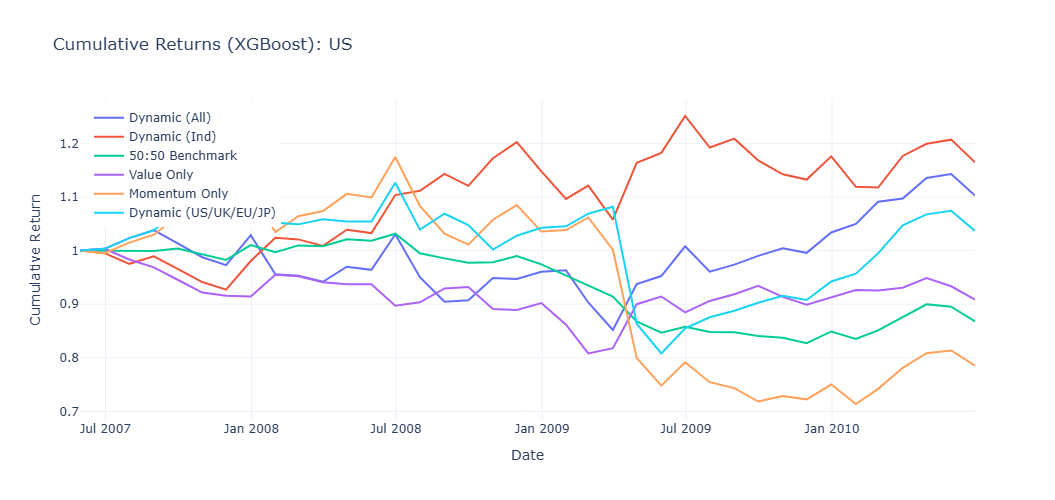

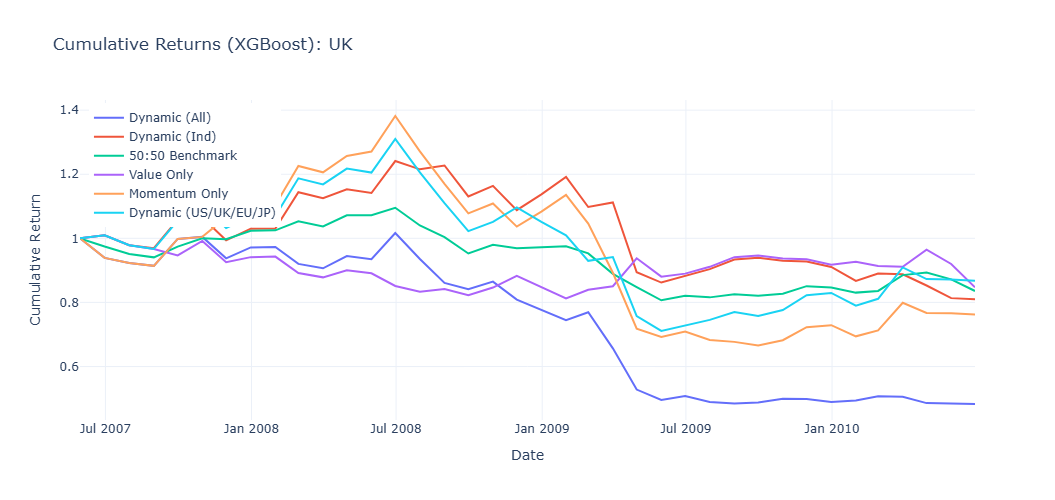

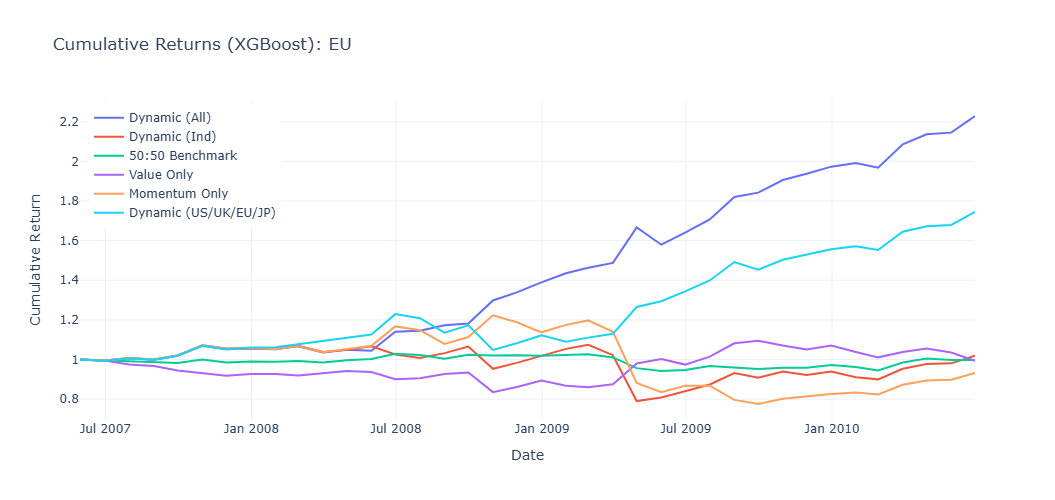

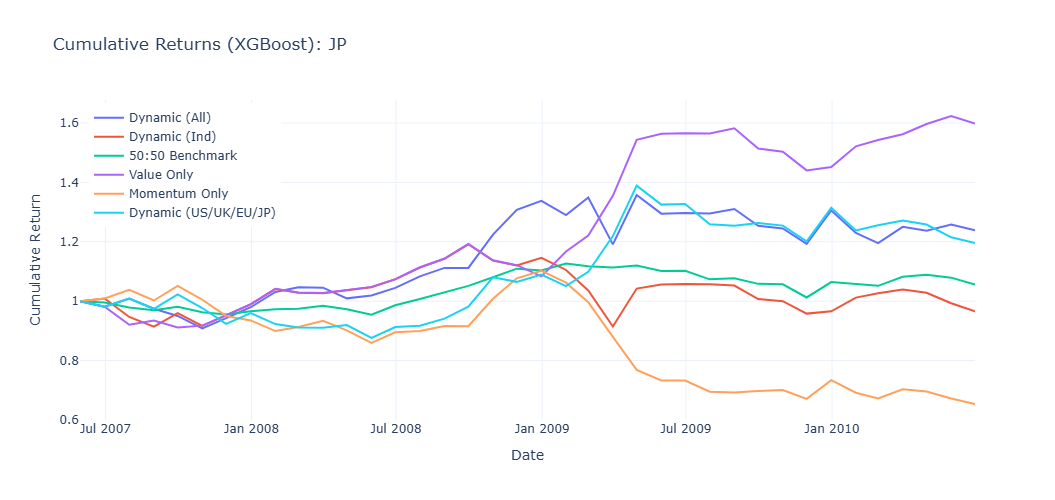

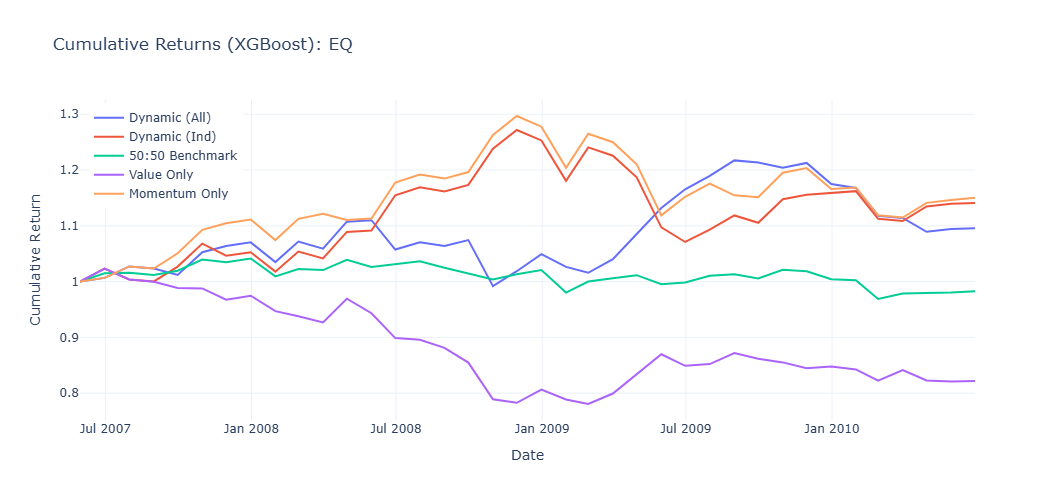

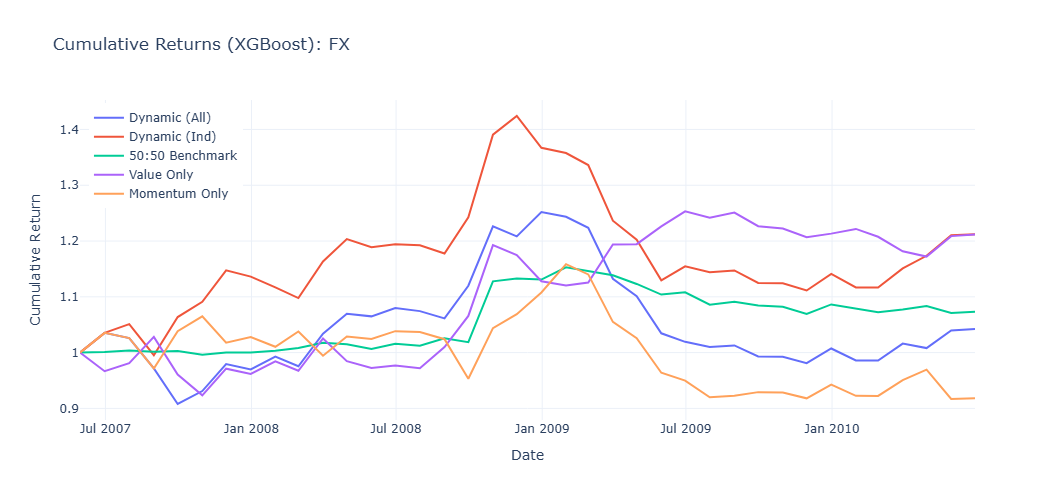

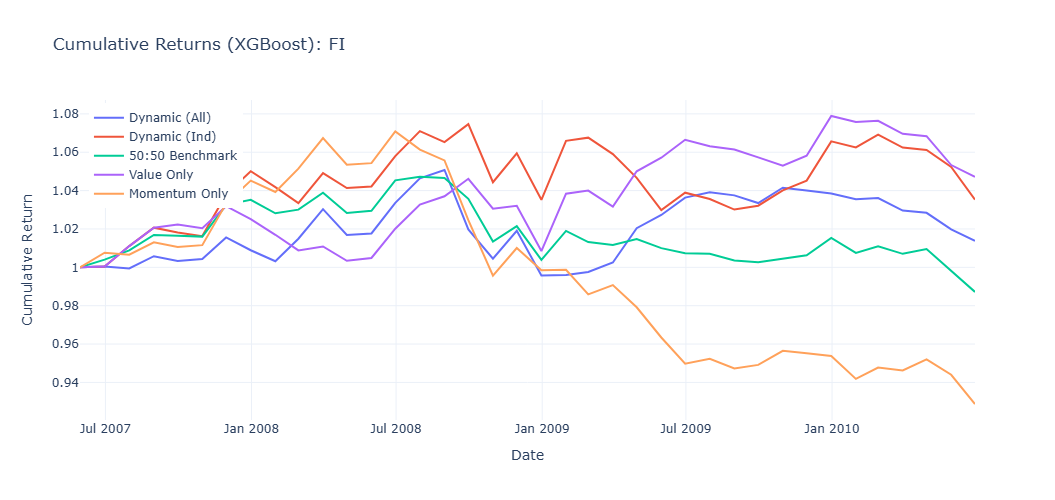

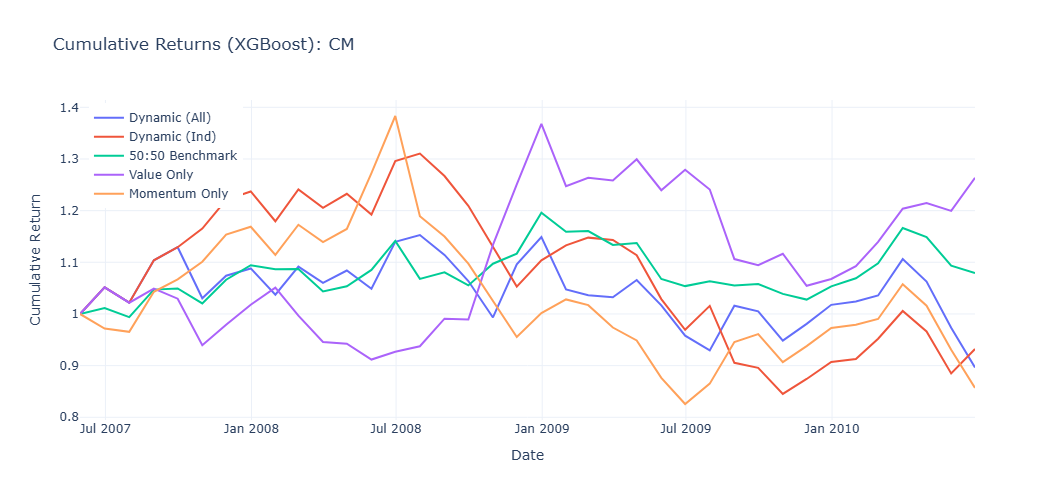

In [13]:
for asset in ['US', 'UK', 'EU', 'JP', 'EQ', 'FX', 'FI', 'CM']:
    val_col = f'VAL_{asset}'
    mom_col = f'MOM_{asset}'
    
    if val_col in df_portfolios.columns and mom_col in df_portfolios.columns:
        try:
            fig = run_xgb_prediction(df_portfolios, val_col, mom_col, 
                                     lookback_feat=36, lookback_std=36,
                                     annual_vol_target=0.02, min_periods_vol=6)
            if fig:
                fig.show()
        except Exception as e:
            print(f"[{asset}] run_xgb_prediction 중 오류 발생:", e)

## 딥러닝(GAN)

In [15]:
import torch
import torch.nn as nn

class GRUClassifier(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, num_layers=2, dropout=0.2):
        super(GRUClassifier, self).__init__()
        self.gru = nn.GRU(input_size=input_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True,
                          dropout=dropout if num_layers > 1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.dropout(out[:, -1, :])  # 마지막 time step의 hidden state
        out = self.fc(out)
        return self.sigmoid(out).squeeze()

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def train_gru_model(model, train_loader, val_loader, num_epochs=100, lr=0.001, patience=10, device='cpu'):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    best_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch.float())
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                val_outputs = model(x_val)
                val_loss = criterion(val_outputs, y_val.float())
                val_losses.append(val_loss.item())

        avg_val_loss = np.mean(val_losses)
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    model.load_state_dict(best_model_state)
    return model


In [17]:
def evaluate_model(model, test_loader, val_series, mom_series, device='cpu'):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            preds.extend(outputs.cpu().numpy())
            targets.extend(y_batch.numpy())

    preds_bin = (np.array(preds) > 0.5).astype(int)
    accuracy = accuracy_score(targets, preds_bin)

    # 수익률 계산
    mom_weights = preds_bin
    val_weights = 1 - mom_weights
    strategy_returns = val_weights * val_series + mom_weights * mom_series
    cumulative_return = (1 + strategy_returns).cumprod()
    sharpe = (strategy_returns.mean() / strategy_returns.std()) * np.sqrt(12)

    return {
        'accuracy': accuracy,
        'sharpe': sharpe,
        'cumulative_return_series': cumulative_return
    }


In [18]:
import torch
import torch.nn as nn

class Embedder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(Embedder, self).__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        h, _ = self.rnn(x)
        return torch.tanh(self.fc(h))

class Recovery(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers):
        super(Recovery, self).__init__()
        self.rnn = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, h):
        h_rnn, _ = self.rnn(h)
        return torch.tanh(self.fc(h_rnn))

class Generator(nn.Module):
    def __init__(self, z_dim, hidden_size, num_layers):
        super(Generator, self).__init__()
        self.rnn = nn.GRU(z_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, hidden_size)

    def forward(self, z):
        h, _ = self.rnn(z)
        return torch.tanh(self.fc(h))

class Supervisor(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(Supervisor, self).__init__()
        self.rnn = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, hidden_size)

    def forward(self, h):
        h_rnn, _ = self.rnn(h)
        return torch.tanh(self.fc(h_rnn))

class Discriminator(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(Discriminator, self).__init__()
        self.rnn = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, h):
        h_rnn, _ = self.rnn(h)
        y = self.fc(h_rnn)
        return torch.sigmoid(y)


In [19]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class TimeGANTrainer:
    def __init__(self, input_size, z_dim=1, num_layers=3, device='cpu', lr=2e-3):
        self.hidden_size = input_size*4
        self.device = device
        self.z_dim = z_dim
        self.input_size = input_size
        self.seq_len = 36
        self.disc_acc_history = []
        self.sup_loss_history = []

        # --- Modules ---
        self.embedder = Embedder(input_size, self.hidden_size, num_layers).to(device)
        self.recovery = Recovery(self.hidden_size, input_size, num_layers).to(device)
        self.generator = Generator(z_dim, self.hidden_size, num_layers).to(device)
        self.supervisor = Supervisor(self.hidden_size, num_layers - 1).to(device)
        self.discriminator = Discriminator(self.hidden_size, num_layers).to(device)

        # --- Optimizers ---
        self.optimizer_embed = torch.optim.Adam(list(self.embedder.parameters()) + list(self.recovery.parameters()), lr=lr, betas=(0.5, 0.9))
        self.optimizer_super = torch.optim.Adam(self.supervisor.parameters(), lr=lr, betas=(0.5, 0.9))
        self.optimizer_gen = torch.optim.Adam(list(self.generator.parameters()) + list(self.supervisor.parameters()), lr=lr, betas=(0.5, 0.9))
        self.optimizer_disc = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(0.5, 0.9))

        # --- Loss functions ---
        self.mse = nn.MSELoss()
        self.bce = nn.BCELoss()

    def generate_noise(self, batch_size):
        return torch.randn(batch_size, self.seq_len, self.z_dim).to(self.device)

    def pretrain_autoencoder(self, train_loader, epochs=100):
        for epoch in range(epochs):
            losses = []
            for x in train_loader:
                x = x[0].to(self.device).float()
                h = self.embedder(x)
                x_tilde = self.recovery(h)
                loss = self.mse(x, x_tilde)
                self.optimizer_embed.zero_grad()
                loss.backward()
                self.optimizer_embed.step()
                losses.append(loss.item())
            if epoch %10 ==9:
                print(f"[Autoencoder] Epoch {epoch+1}/{epochs} | Loss: {np.mean(losses):.6f}")

    def train_supervisor(self, train_loader, epochs=100):
        for epoch in range(epochs):
            losses = []
            for x in train_loader:
                x = x[0].to(self.device).float()
                h = self.embedder(x)
                h_hat = self.supervisor(h)
                loss = self.mse(h[:, 1:, :], h_hat[:, :-1, :])  # next step prediction
                self.optimizer_super.zero_grad()
                loss.backward()
                self.optimizer_super.step()
                losses.append(loss.item())
            if epoch %10 ==9:
                print(f"[Supervisor] Epoch {epoch+1}/{epochs} | Loss: {np.mean(losses):.6f}")

    def train_joint(self, train_loader, epochs=100, gamma=10, patience=20):
        best_loss = float('inf')
        patience_counter = 0
        for epoch in range(epochs):
            g_losses, d_losses, e_losses, disc_acc_log = [], [], [], []

            for x in train_loader:
                x = x[0].to(self.device).float()
                batch_size = x.size(0)

                # === Embedder forward ===
                h_real = self.embedder(x)
                h_supervised = self.supervisor(h_real)
                x_tilde = self.recovery(h_real)

                # === Generator forward ===
                z = self.generate_noise(batch_size)
                e_hat = self.generator(z)
                h_fake = self.supervisor(e_hat)
                x_fake = self.recovery(h_fake)

                # === Discriminator ===
                y_real = torch.ones(batch_size, self.seq_len, 1).to(self.device)
                y_fake = torch.zeros(batch_size, self.seq_len, 1).to(self.device)

                d_real = self.discriminator(h_real.detach())
                d_fake = self.discriminator(h_fake.detach())

                d_loss_real = self.bce(d_real, y_real)
                d_loss_fake = self.bce(d_fake, y_fake)
                d_loss = d_loss_real + d_loss_fake
                self.optimizer_disc.zero_grad()
                d_loss.backward()
                self.optimizer_disc.step()
                d_losses.append(d_loss.item())

                # === Generator loss ===
                g_adv = self.bce(self.discriminator(h_fake), y_real)
                g_sup = self.mse(h_real[:, 1:], h_supervised[:, :-1])
                g_mom = self._moment_loss(h_real, h_fake)
                # g_loss = g_adv + gamma * g_sup + 100 * g_mom
                g_mmd = self._mmd_loss(h_real, h_fake)
                g_loss = g_adv + gamma * g_sup + 100 * g_mom + 10 * g_mmd  # MMD 가중치는 상황 따라 조절
                
                # 로그 저장
                self.sup_loss_history.append(g_sup.item())


                self.optimizer_gen.zero_grad()
                g_loss.backward()
                self.optimizer_gen.step()
                g_losses.append(g_loss.item())

                # === Embedder loss ===
                h_embed = self.embedder(x)  # 다시 생성해 새 그래프 만들기
                h_hat_supervised = self.supervisor(h_embed)
                x_tilde = self.recovery(h_embed)
                # e_loss = self.mse(x, x_tilde)
                e_loss = self.mse(x, x_tilde) + gamma * self.mse(h_embed[:, 1:], h_hat_supervised[:, :-1])
                self.optimizer_embed.zero_grad()
                e_loss.backward()
                self.optimizer_embed.step()
                e_losses.append(e_loss.item())

                # joint training 루프 내부에 추가
                # D_real = self.discriminator(h_real.detach())
                # D_fake = self.discriminator(h_fake.detach())
                d_acc = torch.mean(torch.cat([d_real > 0.5, d_fake < 0.5], dim=0).float())
                disc_acc_log.append(d_acc.item())
                self.disc_acc_history.append(d_acc.item())

            # print(f"[Joint] Epoch {epoch+1}/{epochs} | G: {np.mean(g_losses):.6f} | D: {np.mean(d_losses):.6f} | E: {np.mean(e_losses):.6f}")
            avg_g_loss = np.mean(g_losses)
    
            if avg_g_loss < best_loss - 1e-4:
                best_loss = avg_g_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"⛔ Early stopping at epoch {epoch+1}")
                    break
            if epoch %10 ==9:
                print(f"[Joint] Epoch {epoch+1}/{epochs} | G: {np.mean(g_losses):.6f} | D: {np.mean(d_losses):.6f} | E: {np.mean(e_losses):.6f} | Disc Acc: {np.mean(disc_acc_log):.4f}")

    def _moment_loss(self, real, fake):
        mean_real = real.mean(dim=0)
        mean_fake = fake.mean(dim=0)
        std_real = real.std(dim=0)
        std_fake = fake.std(dim=0)
        return self.mse(mean_real, mean_fake) + self.mse(std_real, std_fake)

    def generate_synthetic(self, n_samples):
        z = self.generate_noise(n_samples)
        with torch.no_grad():
            h = self.generator(z)
            h = self.supervisor(h)
            x = self.recovery(h)
        return x.cpu().numpy()

    def generate_continuous_series(self, n_steps):
        z = torch.randn(1, n_steps, self.z_dim).to(self.device)
        with torch.no_grad():
            h = self.generator(z)
            h = self.supervisor(h)
            x = self.recovery(h)
        return x.squeeze(0).cpu().numpy()
    def _mmd_loss(self, real, fake):
        def gaussian_kernel(x, y, sigma=1.0):
            x = x.view(-1, x.size(-1))
            y = y.view(-1, y.size(-1))
            xx = x.unsqueeze(1)
            yy = y.unsqueeze(0)
            dist = ((xx - yy) ** 2).sum(2)
            return torch.exp(-dist / (2 * sigma ** 2))
    
        k_xx = gaussian_kernel(real, real)
        k_yy = gaussian_kernel(fake, fake)
        k_xy = gaussian_kernel(real, fake)
    
        return k_xx.mean() + k_yy.mean() - 2 * k_xy.mean()
    def plot_training_logs(self):
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.disc_acc_history, label="Discriminator Accuracy")
        plt.title("Discriminator Accuracy Curve")
        plt.xlabel("Iteration")
        plt.ylabel("Accuracy")
        plt.grid(True)
        plt.legend()
    
        plt.subplot(1, 2, 2)
        plt.plot(self.sup_loss_history, label="Supervisor Loss (Temporal)")
        plt.title("Temporal Supervision Loss")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.legend()
    
        plt.tight_layout()
        plt.show()

In [20]:
def generate_augmented_data(timegan_trainer, n_months=120):
    """
    Generates a continuous synthetic time series of n_months length.
    Output: shape = (n_months, 2) — i.e., [VAL, MOM] returns
    """
    synthetic_np = timegan_trainer.generate_continuous_series(n_months)
    synthetic_df = pd.DataFrame(synthetic_np, columns=['VAL', 'MOM'])
    return synthetic_df

In [21]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_synthetic_quality(real_tensor, synthetic_tensor, title_prefix=''):
    """
    real_tensor: shape = (N, seq_len, feature_dim)
    synthetic_tensor: same shape
    """
    real_np = real_tensor.detach().cpu().numpy()
    synth_np = synthetic_tensor.detach().cpu().numpy()

    # Flatten: (N, seq_len * feature_dim)
    real_flat = real_np.reshape(real_np.shape[0], -1)
    synth_flat = synth_np.reshape(synth_np.shape[0], -1)

    # === 1. t-SNE
    combined = np.concatenate([real_flat, synth_flat], axis=0)
    labels = np.array([0]*len(real_flat) + [1]*len(synth_flat))
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_result = tsne.fit_transform(combined)

    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette=['blue', 'orange'], alpha=0.6)
    plt.title(f'{title_prefix} t-SNE: Real (Blue) vs Synthetic (Orange)')
    plt.show()

    # === 2. PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(combined)

    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette=['blue', 'orange'], alpha=0.6)
    plt.title(f'{title_prefix} PCA: Real vs Synthetic')
    plt.show()

    # === 3. Mean/Std bar plot
    mean_real = np.mean(real_flat, axis=0)
    mean_synth = np.mean(synth_flat, axis=0)
    std_real = np.std(real_flat, axis=0)
    std_synth = np.std(synth_flat, axis=0)

    indices = np.arange(len(mean_real))
    plt.figure(figsize=(10, 4))
    plt.plot(indices, mean_real, label='Real Mean')
    plt.plot(indices, mean_synth, label='Synthetic Mean', linestyle='--')
    plt.title(f'{title_prefix} Feature-wise Mean Comparison')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(indices, std_real, label='Real Std')
    plt.plot(indices, std_synth, label='Synthetic Std', linestyle='--')
    plt.title(f'{title_prefix} Feature-wise Std Comparison')
    plt.legend()
    plt.show()


In [22]:
def prepare_timegan_training_data(df_factors, asset_list):
    """
    df_factors: pandas DataFrame with columns like 'VAL_US', 'MOM_US', ...
    asset_list: list of asset tickers to include, e.g., ['US', 'UK']
    
    Returns: Tensor of shape (T, 2) — merged value/momentum returns
    """
    series_list = []
    for asset in asset_list:
        val_col, mom_col = f'VAL_{asset}', f'MOM_{asset}'
        if val_col in df_factors.columns and mom_col in df_factors.columns:
            temp_df = df_factors[[val_col, mom_col]].copy()
            temp_df.columns = ['VAL', 'MOM']
            temp_df = temp_df.dropna()
            series_list.append(temp_df)
        else:
            print(f"⚠️ Skipping {asset}: missing columns.")
    
    if not series_list:
        raise ValueError("No valid asset columns found in the input.")

    # 시계열을 수직으로 붙이기 (시간 순서 무시하고 시퀀스 학습)
    all_data = pd.concat(series_list, axis=0).dropna()
    all_data = all_data.sort_index()  # 시간 정렬 (중복 제거 시 의미 있음)

    scaler = MinMaxScaler()
    all_data_scaled = scaler.fit_transform(all_data.values)
    
    # Normalize (선택)
    # all_data_tensor = torch.tensor(all_data.values, dtype=torch.float32)
    all_data_tensor = torch.tensor(all_data_scaled, dtype=torch.float32)
    return all_data_tensor  # shape: (T_total, 2)


In [23]:
from torch.utils.data import DataLoader, TensorDataset

def get_timegan_dataloader(tensor_data, seq_len=36, batch_size=64):
    """
    tensor_data: shape (T, 2)
    Returns DataLoader of (N, seq_len, 2)
    """
    sequences = []
    for i in range(len(tensor_data) - seq_len):
        window = tensor_data[i:i+seq_len]
        sequences.append(window)

    X = torch.stack(sequences)  # shape: (N, seq_len, 2)
    dataset = TensorDataset(X)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader


In [24]:
def generate_many_synthetic_sequences(timegan_trainer, n_seq=100, seq_len=36):
    """
    시계열 샘플을 여러 개 생성합니다. 
    출력: shape = (n_seq, seq_len, 2)
    """
    z = torch.randn(n_seq, seq_len, timegan_trainer.z_dim).to(timegan_trainer.device)
    with torch.no_grad():
        h = timegan_trainer.generator(z)
        h = timegan_trainer.supervisor(h)
        x = timegan_trainer.recovery(h)
    return x.cpu().numpy()

def split_multiple_sequences_into_supervised(synthetic_np, input_len=12, forecast_len=1):
    """
    (n_seq, seq_len, feature_dim) → (N, input_len, feature_dim), (N, forecast_len, feature_dim)
    """
    X, y = [], []
    for seq in synthetic_np:
        for i in range(len(seq) - input_len - forecast_len + 1):
            X.append(seq[i:i+input_len])
            y.append(seq[i+input_len:i+input_len+forecast_len])
    return np.array(X), np.array(y)


In [61]:
file_path = 'Value and Momentum Everywhere Original Paper Data.xlsx'
df_factors = load_vme_portfolios(file_path)

# === 2. 변동성 스케일링 적용 ===
# 각 VAL_자산군 및 MOM_자산군 컬럼에 대해 변동성 스케일링을 적용합니다.
# lookback_months=36 (기본값) 및 min_lookback_months=6 적용
scaled_df_portfolios = pd.DataFrame(index=df_factors.index)
asset_classes = ['US', 'UK', 'EU', 'JP', 'EQ', 'FX', 'FI', 'CM']
for asset in asset_classes:
    val_col = f'VAL_{asset}'
    mom_col = f'MOM_{asset}'
    
    if val_col in df_factors.columns and mom_col in df_factors.columns:
        # VAL 팩터 수익률 스케일링
        scaled_df_portfolios[val_col] = volatility_scale_monthly_returns(
            df_factors[val_col], lookback_months=36, min_lookback_months=6, annual_vol_target=0.02
        )
        # MOM 팩터 수익률 스케일링
        scaled_df_portfolios[mom_col] = volatility_scale_monthly_returns(
            df_factors[mom_col], lookback_months=36, min_lookback_months=6, annual_vol_target=0.02
        )
    else:
        print(f"⚠️ Skipping scaling for {asset}: Missing original columns.")

df_factors_trimmed = df_factors[df_factors.index <= '2010-06-30'].copy()

last_date_all_data = df_factors_trimmed.index.max()
cutoff_test = last_date_all_data - pd.DateOffset(years=3) # 테스트셋 시작 날짜
cutoff_val = cutoff_test - pd.DateOffset(years=3) # 학습셋 끝 날짜

# 전체 결합 데이터 중 학습 데이터셋 선택
train_idx_combined = df_factors_trimmed.index < cutoff_val
df_factors_trimmed_train = df_factors_trimmed[train_idx_combined]

In [78]:
# A. 개별 자산군 (e.g., US만)
train_tensor_A = prepare_timegan_training_data(df_factors_trimmed_train, ['US'])
train_loader_A = get_timegan_dataloader(train_tensor_A)

# B. 주식 관련 자산군
train_tensor_B = prepare_timegan_training_data(df_factors_trimmed_train, ['US', 'UK', 'EU', 'JP'])
train_loader_B = get_timegan_dataloader(train_tensor_B)

# C. 전체 자산군
train_tensor_C = prepare_timegan_training_data(df_factors_trimmed_train, ['US', 'UK', 'EU', 'JP', 'EQ', 'FX', 'FI', 'CM'])
train_loader_C = get_timegan_dataloader(train_tensor_C)

# # 학습 예시
# timegan_trainer = TimeGANTrainer(input_size=2, z_dim = 1, device='cuda' if torch.cuda.is_available() else 'cpu')
# timegan_trainer.pretrain_autoencoder(train_loader_C, epochs=4000)
# timegan_trainer.train_supervisor(train_loader_C, epochs=4000)
# timegan_trainer.train_joint(train_loader_C, epochs=2000)

In [25]:
# Re-import required packages after kernel reset
import torch
import random
import json
import numpy as np
from tqdm import tqdm
from pathlib import Path

# === MMD 함수 ===
def compute_mmd(real, fake, sigma=1.0):
    def gaussian_kernel(x, y):
        x = x.view(-1, x.size(-1))
        y = y.view(-1, y.size(-1))
        dist = ((x.unsqueeze(1) - y.unsqueeze(0))**2).sum(2)
        return torch.exp(-dist / (2 * sigma**2))
    
    k_xx = gaussian_kernel(real, real).mean()
    k_yy = gaussian_kernel(fake, fake).mean()
    k_xy = gaussian_kernel(real, fake).mean()
    return (k_xx + k_yy - 2 * k_xy).item()

# === 하이퍼파라미터 조합 생성 ===
def generate_param_combinations(base_lr=2e-3, base_gamma=10, base_batch=64, sample_n=13):
    lrs = [base_lr / 2, base_lr, base_lr * 2]
    gammas = [base_gamma / 2, base_gamma, base_gamma * 2]
    batches = [int(base_batch / 2), base_batch, int(base_batch * 2)]
    all_combinations = [{"lr": lr, "gamma": g, "batch_size": b} for lr in lrs for g in gammas for b in batches]
    return random.sample(all_combinations, sample_n)

# === 저장 함수 ===
def save_best_params(best_dict, path='timegan_randomsearch_result.json'):
    with open(path, 'w') as f:
        json.dump(best_dict, f, indent=4)
    print(f"✅ 저장 완료: {path}")

# === TimeGAN 모델 저장 ===
def save_timegan_model(trainer, save_path_prefix):
    torch.save(trainer.embedder.state_dict(), f"{save_path_prefix}_embedder.pth")
    torch.save(trainer.recovery.state_dict(), f"{save_path_prefix}_recovery.pth")
    torch.save(trainer.generator.state_dict(), f"{save_path_prefix}_generator.pth")
    torch.save(trainer.supervisor.state_dict(), f"{save_path_prefix}_supervisor.pth")
    torch.save(trainer.discriminator.state_dict(), f"{save_path_prefix}_discriminator.pth")
    print(f"✅ TimeGAN 모델 저장 완료: {save_path_prefix}_*.pth")

# === 랜덤 서치 + 저장 ===
def run_randomsearch_all_sets(df_factors_trimmed_train, prepare_timegan_training_data, get_timegan_dataloader, TimeGANTrainer, generate_many_synthetic_sequences):
    all_sets = {
        "A": ['US'],
        "B": ['US', 'UK', 'EU', 'JP'],
        "C": ['US', 'UK', 'EU', 'JP', 'EQ', 'FX', 'FI', 'CM']
    }

    best_results = {}

    for key, assets in all_sets.items():
        print(f"\n🔍 데이터셋 {key} 탐색 중...")

        train_tensor = prepare_timegan_training_data(df_factors_trimmed_train, assets)
        param_combos = generate_param_combinations()

        best_mmd = float('inf')
        best_config = None

        for combo in tqdm(param_combos, desc=f"Searching {key}"):
            loader = get_timegan_dataloader(train_tensor, batch_size=combo['batch_size'])
            trainer = TimeGANTrainer(input_size=2, z_dim=1, device='cuda' if torch.cuda.is_available() else 'cpu', lr=combo['lr'])

            trainer.pretrain_autoencoder(loader, epochs=50)
            trainer.train_supervisor(loader, epochs=50)
            trainer.train_joint(loader, epochs=100, gamma=combo['gamma'])

            real_tensor = next(iter(loader))[0][:100]
            synth_np = generate_many_synthetic_sequences(trainer, n_seq=100)
            synth_tensor = torch.tensor(synth_np, dtype=torch.float32)

            mmd_score = compute_mmd(real_tensor, synth_tensor)
            combo["mmd_score"] = mmd_score

            if mmd_score < best_mmd:
                best_mmd = mmd_score
                best_config = combo.copy()

        print(f"✅ Best MMD for {key}: {best_mmd:.6f}")
        best_results[key] = best_config

    save_best_params(best_results)

# === 저장된 json 불러와 장기 학습 실행 ===
def run_long_training_from_json(json_path, df_factors_trimmed_train, prepare_timegan_training_data, get_timegan_dataloader, TimeGANTrainer):
    with open(json_path, 'r') as f:
        config = json.load(f)

    all_sets = {
        "A": ['US'],
        "B": ['US', 'UK', 'EU', 'JP'],
        "C": ['US', 'UK', 'EU', 'JP', 'EQ', 'FX', 'FI', 'CM']
    }

    for key, assets in all_sets.items():
        print(f"\n🚀 {key} 장기 학습 시작")

        params = config[key]
        train_tensor = prepare_timegan_training_data(df_factors_trimmed_train, assets)
        loader = get_timegan_dataloader(train_tensor, batch_size=params["batch_size"])

        trainer = TimeGANTrainer(input_size=2, z_dim=1, device='cuda' if torch.cuda.is_available() else 'cpu', lr=params["lr"])

        trainer.pretrain_autoencoder(loader, epochs=2000)
        trainer.train_supervisor(loader, epochs=2000)
        trainer.train_joint(loader, epochs=2000, gamma=params["gamma"])

        save_timegan_model(trainer, f"timegan_model_{key}")


In [80]:
# Step 1: 랜덤 서치
run_randomsearch_all_sets(df_factors_trimmed_train, prepare_timegan_training_data, get_timegan_dataloader, TimeGANTrainer, generate_many_synthetic_sequences)

# Step 2: 최적 하이퍼파라미터로 장기 학습 및 모델 저장
run_long_training_from_json("timegan_randomsearch_result.json", df_factors_trimmed_train, prepare_timegan_training_data, get_timegan_dataloader, TimeGANTrainer)


🔍 데이터셋 A 탐색 중...


Searching A:   0%|                                                                              | 0/13 [00:00<?, ?it/s]

[Autoencoder] Epoch 10/50 | Loss: 0.018129
[Autoencoder] Epoch 20/50 | Loss: 0.014061
[Autoencoder] Epoch 30/50 | Loss: 0.013984
[Autoencoder] Epoch 40/50 | Loss: 0.010733
[Autoencoder] Epoch 50/50 | Loss: 0.007213
[Supervisor] Epoch 10/50 | Loss: 0.018570
[Supervisor] Epoch 20/50 | Loss: 0.013305
[Supervisor] Epoch 30/50 | Loss: 0.012612
[Supervisor] Epoch 40/50 | Loss: 0.012269
[Supervisor] Epoch 50/50 | Loss: 0.012123
[Joint] Epoch 10/100 | G: 1.075840 | D: 1.293594 | E: 0.018176 | Disc Acc: 0.7700
[Joint] Epoch 20/100 | G: 0.838082 | D: 1.437432 | E: 0.012232 | Disc Acc: 0.5242
[Joint] Epoch 30/100 | G: 0.716468 | D: 1.391020 | E: 0.009091 | Disc Acc: 0.4926
[Joint] Epoch 40/100 | G: 0.705442 | D: 1.386131 | E: 0.008074 | Disc Acc: 0.5083
⛔ Early stopping at epoch 45


Searching A:   8%|█████▍                                                                | 1/13 [00:22<04:33, 22.83s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.015770
[Autoencoder] Epoch 20/50 | Loss: 0.012190
[Autoencoder] Epoch 30/50 | Loss: 0.005338
[Autoencoder] Epoch 40/50 | Loss: 0.004528
[Autoencoder] Epoch 50/50 | Loss: 0.003375
[Supervisor] Epoch 10/50 | Loss: 0.012749
[Supervisor] Epoch 20/50 | Loss: 0.010333
[Supervisor] Epoch 30/50 | Loss: 0.009996
[Supervisor] Epoch 40/50 | Loss: 0.010097
[Supervisor] Epoch 50/50 | Loss: 0.009680
[Joint] Epoch 10/100 | G: 0.811787 | D: 1.400817 | E: 0.018978 | Disc Acc: 0.4565
[Joint] Epoch 20/100 | G: 0.730833 | D: 1.383642 | E: 0.013444 | Disc Acc: 0.5204
[Joint] Epoch 30/100 | G: 0.754444 | D: 1.390823 | E: 0.017495 | Disc Acc: 0.4218
[Joint] Epoch 40/100 | G: 0.745590 | D: 1.387125 | E: 0.009884 | Disc Acc: 0.4505
[Joint] Epoch 50/100 | G: 0.745988 | D: 1.384971 | E: 0.010170 | Disc Acc: 0.5385
[Joint] Epoch 60/100 | G: 0.982591 | D: 1.399434 | E: 0.022062 | Disc Acc: 0.4749
[Joint] Epoch 70/100 | G: 0.847010 | D: 1.384220 | E: 0.012933 | Disc Acc: 0.5262
[

Searching A:  15%|██████████▊                                                           | 2/13 [01:00<05:45, 31.38s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.018841
[Autoencoder] Epoch 20/50 | Loss: 0.014524
[Autoencoder] Epoch 30/50 | Loss: 0.014166
[Autoencoder] Epoch 40/50 | Loss: 0.014188
[Autoencoder] Epoch 50/50 | Loss: 0.013980
[Supervisor] Epoch 10/50 | Loss: 0.052506
[Supervisor] Epoch 20/50 | Loss: 0.001700
[Supervisor] Epoch 30/50 | Loss: 0.000040
[Supervisor] Epoch 40/50 | Loss: 0.000015
[Supervisor] Epoch 50/50 | Loss: 0.000015
[Joint] Epoch 10/100 | G: 0.818272 | D: 1.381352 | E: 0.014823 | Disc Acc: 0.5696
[Joint] Epoch 20/100 | G: 0.746584 | D: 1.405821 | E: 0.017407 | Disc Acc: 0.4541
[Joint] Epoch 30/100 | G: 0.718764 | D: 1.386873 | E: 0.013904 | Disc Acc: 0.4869
[Joint] Epoch 40/100 | G: 0.716841 | D: 1.385975 | E: 0.014377 | Disc Acc: 0.5245
[Joint] Epoch 50/100 | G: 0.712265 | D: 1.386273 | E: 0.010516 | Disc Acc: 0.4990
⛔ Early stopping at epoch 55


Searching A:  23%|████████████████▏                                                     | 3/13 [01:27<04:53, 29.31s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.014574
[Autoencoder] Epoch 20/50 | Loss: 0.006999
[Autoencoder] Epoch 30/50 | Loss: 0.003463
[Autoencoder] Epoch 40/50 | Loss: 0.003297
[Autoencoder] Epoch 50/50 | Loss: 0.003054
[Supervisor] Epoch 10/50 | Loss: 0.008930
[Supervisor] Epoch 20/50 | Loss: 0.007447
[Supervisor] Epoch 30/50 | Loss: 0.007260
[Supervisor] Epoch 40/50 | Loss: 0.007220
[Supervisor] Epoch 50/50 | Loss: 0.007184
[Joint] Epoch 10/100 | G: 0.740714 | D: 1.398575 | E: 0.018630 | Disc Acc: 0.2238
[Joint] Epoch 20/100 | G: 0.707008 | D: 1.386430 | E: 0.013820 | Disc Acc: 0.4929
[Joint] Epoch 30/100 | G: 0.752614 | D: 1.384296 | E: 0.011430 | Disc Acc: 0.5687
⛔ Early stopping at epoch 38


Searching A:  31%|█████████████████████▌                                                | 4/13 [01:47<03:52, 25.87s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.014169
[Autoencoder] Epoch 20/50 | Loss: 0.014084
[Autoencoder] Epoch 30/50 | Loss: 0.004359
[Autoencoder] Epoch 40/50 | Loss: 0.003423
[Autoencoder] Epoch 50/50 | Loss: 0.002843
[Supervisor] Epoch 10/50 | Loss: 0.022320
[Supervisor] Epoch 20/50 | Loss: 0.019499
[Supervisor] Epoch 30/50 | Loss: 0.017957
[Supervisor] Epoch 40/50 | Loss: 0.016478
[Supervisor] Epoch 50/50 | Loss: 0.015391
[Joint] Epoch 10/100 | G: 0.737438 | D: 1.386542 | E: 0.013555 | Disc Acc: 0.4896
[Joint] Epoch 20/100 | G: 0.751219 | D: 1.387152 | E: 0.010616 | Disc Acc: 0.5199
⛔ Early stopping at epoch 30


Searching A:  38%|██████████████████████████▉                                           | 5/13 [02:05<03:04, 23.04s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.016637
[Autoencoder] Epoch 20/50 | Loss: 0.014365
[Autoencoder] Epoch 30/50 | Loss: 0.013922
[Autoencoder] Epoch 40/50 | Loss: 0.014078
[Autoencoder] Epoch 50/50 | Loss: 0.005649
[Supervisor] Epoch 10/50 | Loss: 0.014905
[Supervisor] Epoch 20/50 | Loss: 0.014197
[Supervisor] Epoch 30/50 | Loss: 0.014212
[Supervisor] Epoch 40/50 | Loss: 0.013974
[Supervisor] Epoch 50/50 | Loss: 0.013746
[Joint] Epoch 10/100 | G: 0.891765 | D: 1.446127 | E: 0.012295 | Disc Acc: 0.3933
[Joint] Epoch 20/100 | G: 0.748626 | D: 1.389431 | E: 0.009946 | Disc Acc: 0.4265
[Joint] Epoch 30/100 | G: 0.703576 | D: 1.386347 | E: 0.006280 | Disc Acc: 0.4987
[Joint] Epoch 40/100 | G: 0.721720 | D: 1.386284 | E: 0.008077 | Disc Acc: 0.4891
[Joint] Epoch 50/100 | G: 0.702506 | D: 1.386320 | E: 0.005405 | Disc Acc: 0.4999
[Joint] Epoch 60/100 | G: 0.719359 | D: 1.386288 | E: 0.008298 | Disc Acc: 0.5034
[Joint] Epoch 70/100 | G: 0.696632 | D: 1.386229 | E: 0.004429 | Disc Acc: 0.5008
⛔

Searching A:  46%|████████████████████████████████▎                                     | 6/13 [02:43<03:16, 28.00s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.033648
[Autoencoder] Epoch 20/50 | Loss: 0.017059
[Autoencoder] Epoch 30/50 | Loss: 0.014539
[Autoencoder] Epoch 40/50 | Loss: 0.014075
[Autoencoder] Epoch 50/50 | Loss: 0.013679
[Supervisor] Epoch 10/50 | Loss: 0.318185
[Supervisor] Epoch 20/50 | Loss: 0.050134
[Supervisor] Epoch 30/50 | Loss: 0.005358
[Supervisor] Epoch 40/50 | Loss: 0.000474
[Supervisor] Epoch 50/50 | Loss: 0.000055
[Joint] Epoch 10/100 | G: 0.712330 | D: 1.384440 | E: 0.014466 | Disc Acc: 0.5275
[Joint] Epoch 20/100 | G: 0.702237 | D: 1.387478 | E: 0.014081 | Disc Acc: 0.5044
[Joint] Epoch 30/100 | G: 0.698277 | D: 1.386504 | E: 0.014269 | Disc Acc: 0.5037
[Joint] Epoch 40/100 | G: 0.695929 | D: 1.386047 | E: 0.014053 | Disc Acc: 0.5024
[Joint] Epoch 50/100 | G: 0.694396 | D: 1.386130 | E: 0.013970 | Disc Acc: 0.5085
[Joint] Epoch 60/100 | G: 0.692048 | D: 1.386198 | E: 0.013970 | Disc Acc: 0.5075
[Joint] Epoch 70/100 | G: 0.692902 | D: 1.386300 | E: 0.014002 | Disc Acc: 0.5012
⛔

Searching A:  54%|█████████████████████████████████████▋                                | 7/13 [03:22<03:09, 31.51s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.015113
[Autoencoder] Epoch 20/50 | Loss: 0.014353
[Autoencoder] Epoch 30/50 | Loss: 0.013265
[Autoencoder] Epoch 40/50 | Loss: 0.004927
[Autoencoder] Epoch 50/50 | Loss: 0.003834
[Supervisor] Epoch 10/50 | Loss: 0.016855
[Supervisor] Epoch 20/50 | Loss: 0.012649
[Supervisor] Epoch 30/50 | Loss: 0.011108
[Supervisor] Epoch 40/50 | Loss: 0.010299
[Supervisor] Epoch 50/50 | Loss: 0.010085
[Joint] Epoch 10/100 | G: 0.842575 | D: 1.386816 | E: 0.028533 | Disc Acc: 0.5455
[Joint] Epoch 20/100 | G: 0.853230 | D: 1.386730 | E: 0.023049 | Disc Acc: 0.4618
[Joint] Epoch 30/100 | G: 0.817198 | D: 1.398048 | E: 0.022616 | Disc Acc: 0.1547
[Joint] Epoch 40/100 | G: 0.773535 | D: 1.385941 | E: 0.052264 | Disc Acc: 0.4955
[Joint] Epoch 50/100 | G: 0.721464 | D: 1.384292 | E: 0.018969 | Disc Acc: 0.4994
[Joint] Epoch 60/100 | G: 0.749809 | D: 1.385397 | E: 0.014358 | Disc Acc: 0.5152
[Joint] Epoch 70/100 | G: 0.718903 | D: 1.387741 | E: 0.012172 | Disc Acc: 0.4809
[

Searching A:  62%|██████████████████████████████████████████▍                          | 8/13 [08:57<10:42, 128.43s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.015812
[Autoencoder] Epoch 20/50 | Loss: 0.014335
[Autoencoder] Epoch 30/50 | Loss: 0.013488
[Autoencoder] Epoch 40/50 | Loss: 0.006399
[Autoencoder] Epoch 50/50 | Loss: 0.005601
[Supervisor] Epoch 10/50 | Loss: 0.015514
[Supervisor] Epoch 20/50 | Loss: 0.014551
[Supervisor] Epoch 30/50 | Loss: 0.014407
[Supervisor] Epoch 40/50 | Loss: 0.014096
[Supervisor] Epoch 50/50 | Loss: 0.013684
[Joint] Epoch 10/100 | G: 1.380628 | D: 1.173164 | E: 0.024239 | Disc Acc: 0.7359
[Joint] Epoch 20/100 | G: 0.845843 | D: 1.327620 | E: 0.015565 | Disc Acc: 0.6143
[Joint] Epoch 30/100 | G: 0.729751 | D: 1.373899 | E: 0.015226 | Disc Acc: 0.5520
[Joint] Epoch 40/100 | G: 0.670749 | D: 1.436695 | E: 0.010864 | Disc Acc: 0.5656
[Joint] Epoch 50/100 | G: 1.245697 | D: 1.371908 | E: 0.038182 | Disc Acc: 0.5371
[Joint] Epoch 60/100 | G: 1.614868 | D: 1.392685 | E: 0.047934 | Disc Acc: 0.4860
⛔ Early stopping at epoch 62


Searching A:  69%|████████████████████████████████████████████████▍                     | 9/13 [09:30<06:34, 98.56s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.014457
[Autoencoder] Epoch 20/50 | Loss: 0.014037
[Autoencoder] Epoch 30/50 | Loss: 0.006264
[Autoencoder] Epoch 40/50 | Loss: 0.004113
[Autoencoder] Epoch 50/50 | Loss: 0.003512
[Supervisor] Epoch 10/50 | Loss: 0.012348
[Supervisor] Epoch 20/50 | Loss: 0.011328
[Supervisor] Epoch 30/50 | Loss: 0.010932
[Supervisor] Epoch 40/50 | Loss: 0.010743
[Supervisor] Epoch 50/50 | Loss: 0.010543
[Joint] Epoch 10/100 | G: 0.769127 | D: 1.402426 | E: 0.008777 | Disc Acc: 0.4201
[Joint] Epoch 20/100 | G: 0.737984 | D: 1.384304 | E: 0.006939 | Disc Acc: 0.5547
[Joint] Epoch 30/100 | G: 0.749128 | D: 1.391964 | E: 0.007407 | Disc Acc: 0.4027
[Joint] Epoch 40/100 | G: 0.721167 | D: 1.385253 | E: 0.005548 | Disc Acc: 0.5085
[Joint] Epoch 50/100 | G: 0.735039 | D: 1.386236 | E: 0.005632 | Disc Acc: 0.4721
[Joint] Epoch 60/100 | G: 0.710902 | D: 1.385928 | E: 0.004382 | Disc Acc: 0.5299
[Joint] Epoch 70/100 | G: 0.702135 | D: 1.386358 | E: 0.004114 | Disc Acc: 0.5059
[

Searching A:  77%|█████████████████████████████████████████████████████                | 10/13 [10:14<04:05, 81.74s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.014566
[Autoencoder] Epoch 20/50 | Loss: 0.014032
[Autoencoder] Epoch 30/50 | Loss: 0.008463
[Autoencoder] Epoch 40/50 | Loss: 0.003584
[Autoencoder] Epoch 50/50 | Loss: 0.003322
[Supervisor] Epoch 10/50 | Loss: 0.009187
[Supervisor] Epoch 20/50 | Loss: 0.008053
[Supervisor] Epoch 30/50 | Loss: 0.007832
[Supervisor] Epoch 40/50 | Loss: 0.007727
[Supervisor] Epoch 50/50 | Loss: 0.007627
[Joint] Epoch 10/100 | G: 0.744117 | D: 1.386267 | E: 0.011598 | Disc Acc: 0.5036
[Joint] Epoch 20/100 | G: 0.743192 | D: 1.387831 | E: 0.011230 | Disc Acc: 0.4860
[Joint] Epoch 30/100 | G: 0.707747 | D: 1.386466 | E: 0.008533 | Disc Acc: 0.4672
[Joint] Epoch 40/100 | G: 0.707578 | D: 1.386088 | E: 0.007173 | Disc Acc: 0.5698
[Joint] Epoch 50/100 | G: 0.701636 | D: 1.386297 | E: 0.006493 | Disc Acc: 0.5013
[Joint] Epoch 60/100 | G: 0.700324 | D: 1.386168 | E: 0.006372 | Disc Acc: 0.5074
[Joint] Epoch 70/100 | G: 0.697204 | D: 1.386255 | E: 0.005044 | Disc Acc: 0.5128
[

Searching A:  85%|██████████████████████████████████████████████████████████▍          | 11/13 [11:02<02:22, 71.24s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.020953
[Autoencoder] Epoch 20/50 | Loss: 0.017444
[Autoencoder] Epoch 30/50 | Loss: 0.015811
[Autoencoder] Epoch 40/50 | Loss: 0.014842
[Autoencoder] Epoch 50/50 | Loss: 0.014275
[Supervisor] Epoch 10/50 | Loss: 0.067294
[Supervisor] Epoch 20/50 | Loss: 0.011352
[Supervisor] Epoch 30/50 | Loss: 0.002053
[Supervisor] Epoch 40/50 | Loss: 0.001316
[Supervisor] Epoch 50/50 | Loss: 0.000669
[Joint] Epoch 10/100 | G: 1.753804 | D: 1.380944 | E: 0.023921 | Disc Acc: 0.5139
[Joint] Epoch 20/100 | G: 0.886753 | D: 1.380920 | E: 0.020687 | Disc Acc: 0.5194
[Joint] Epoch 30/100 | G: 0.814064 | D: 1.372660 | E: 0.018286 | Disc Acc: 0.6745
[Joint] Epoch 40/100 | G: 0.830658 | D: 1.370637 | E: 0.017373 | Disc Acc: 0.5888
[Joint] Epoch 50/100 | G: 0.784678 | D: 1.406248 | E: 0.016200 | Disc Acc: 0.2509
[Joint] Epoch 60/100 | G: 0.760274 | D: 1.389635 | E: 0.016663 | Disc Acc: 0.3392
[Joint] Epoch 70/100 | G: 0.753172 | D: 1.382242 | E: 0.016737 | Disc Acc: 0.5555
[

Searching A:  92%|██████████████████████████████████████████████████████████████▊     | 12/13 [16:14<02:24, 144.56s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.022116
[Autoencoder] Epoch 20/50 | Loss: 0.016438
[Autoencoder] Epoch 30/50 | Loss: 0.014089
[Autoencoder] Epoch 40/50 | Loss: 0.013518
[Autoencoder] Epoch 50/50 | Loss: 0.006531
[Supervisor] Epoch 10/50 | Loss: 0.009871
[Supervisor] Epoch 20/50 | Loss: 0.007164
[Supervisor] Epoch 30/50 | Loss: 0.006502
[Supervisor] Epoch 40/50 | Loss: 0.006363
[Supervisor] Epoch 50/50 | Loss: 0.006322
[Joint] Epoch 10/100 | G: 0.917350 | D: 1.339398 | E: 0.017820 | Disc Acc: 0.9070
[Joint] Epoch 20/100 | G: 0.721307 | D: 1.396141 | E: 0.014613 | Disc Acc: 0.4511
[Joint] Epoch 30/100 | G: 0.696854 | D: 1.391720 | E: 0.014627 | Disc Acc: 0.3702
[Joint] Epoch 40/100 | G: 0.698454 | D: 1.386385 | E: 0.014012 | Disc Acc: 0.5343
[Joint] Epoch 50/100 | G: 0.696911 | D: 1.386525 | E: 0.013447 | Disc Acc: 0.4951
[Joint] Epoch 60/100 | G: 0.698881 | D: 1.386371 | E: 0.013597 | Disc Acc: 0.4941
⛔ Early stopping at epoch 64


Searching A: 100%|█████████████████████████████████████████████████████████████████████| 13/13 [16:49<00:00, 77.62s/it]


✅ Best MMD for A: 0.000201

🔍 데이터셋 B 탐색 중...


Searching B:   0%|                                                                              | 0/13 [00:00<?, ?it/s]

[Autoencoder] Epoch 10/50 | Loss: 0.012130
[Autoencoder] Epoch 20/50 | Loss: 0.010701
[Autoencoder] Epoch 30/50 | Loss: 0.004934
[Autoencoder] Epoch 40/50 | Loss: 0.004241
[Autoencoder] Epoch 50/50 | Loss: 0.003788
[Supervisor] Epoch 10/50 | Loss: 0.010005
[Supervisor] Epoch 20/50 | Loss: 0.007736
[Supervisor] Epoch 30/50 | Loss: 0.007696
[Supervisor] Epoch 40/50 | Loss: 0.007448
[Supervisor] Epoch 50/50 | Loss: 0.007569
[Joint] Epoch 10/100 | G: 0.985650 | D: 1.413447 | E: 0.011813 | Disc Acc: 0.4055
[Joint] Epoch 20/100 | G: 0.788086 | D: 1.377901 | E: 0.013304 | Disc Acc: 0.6355
[Joint] Epoch 30/100 | G: 0.750627 | D: 1.389280 | E: 0.009739 | Disc Acc: 0.4638
[Joint] Epoch 40/100 | G: 0.786725 | D: 1.401097 | E: 0.008700 | Disc Acc: 0.4212
[Joint] Epoch 50/100 | G: 0.768662 | D: 1.386747 | E: 0.008456 | Disc Acc: 0.5013
[Joint] Epoch 60/100 | G: 0.752827 | D: 1.385528 | E: 0.008617 | Disc Acc: 0.5068
[Joint] Epoch 70/100 | G: 0.725932 | D: 1.386322 | E: 0.008171 | Disc Acc: 0.5033
[

Searching B:   8%|█████                                                             | 1/13 [20:28<4:05:42, 1228.54s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.011297
[Autoencoder] Epoch 20/50 | Loss: 0.004897
[Autoencoder] Epoch 30/50 | Loss: 0.003109
[Autoencoder] Epoch 40/50 | Loss: 0.002887
[Autoencoder] Epoch 50/50 | Loss: 0.002774
[Supervisor] Epoch 10/50 | Loss: 0.004311
[Supervisor] Epoch 20/50 | Loss: 0.003889
[Supervisor] Epoch 30/50 | Loss: 0.003932
[Supervisor] Epoch 40/50 | Loss: 0.003921
[Supervisor] Epoch 50/50 | Loss: 0.003905
[Joint] Epoch 10/100 | G: 0.747528 | D: 1.383256 | E: 0.006797 | Disc Acc: 0.5065
[Joint] Epoch 20/100 | G: 0.706163 | D: 1.385908 | E: 0.004444 | Disc Acc: 0.5203
[Joint] Epoch 30/100 | G: 0.701445 | D: 1.385983 | E: 0.004029 | Disc Acc: 0.5209
[Joint] Epoch 40/100 | G: 0.701119 | D: 1.385229 | E: 0.003828 | Disc Acc: 0.5287
[Joint] Epoch 50/100 | G: 0.700375 | D: 1.388245 | E: 0.003802 | Disc Acc: 0.4709
[Joint] Epoch 60/100 | G: 0.700570 | D: 1.386231 | E: 0.003840 | Disc Acc: 0.5053
[Joint] Epoch 70/100 | G: 0.698268 | D: 1.386351 | E: 0.003568 | Disc Acc: 0.4986
[

Searching B:  15%|██████████▎                                                        | 2/13 [23:32<1:52:37, 614.34s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.005650
[Autoencoder] Epoch 20/50 | Loss: 0.002767
[Autoencoder] Epoch 30/50 | Loss: 0.002701
[Autoencoder] Epoch 40/50 | Loss: 0.002628
[Autoencoder] Epoch 50/50 | Loss: 0.002592
[Supervisor] Epoch 10/50 | Loss: 0.001984
[Supervisor] Epoch 20/50 | Loss: 0.001925
[Supervisor] Epoch 30/50 | Loss: 0.001905
[Supervisor] Epoch 40/50 | Loss: 0.001901
[Supervisor] Epoch 50/50 | Loss: 0.001889
[Joint] Epoch 10/100 | G: 0.719762 | D: 1.386110 | E: 0.006037 | Disc Acc: 0.5087
[Joint] Epoch 20/100 | G: 0.709219 | D: 1.386907 | E: 0.005262 | Disc Acc: 0.4892
[Joint] Epoch 30/100 | G: 0.703052 | D: 1.386526 | E: 0.004261 | Disc Acc: 0.4874
[Joint] Epoch 40/100 | G: 0.701341 | D: 1.385859 | E: 0.003889 | Disc Acc: 0.5118
[Joint] Epoch 50/100 | G: 0.701268 | D: 1.385803 | E: 0.003644 | Disc Acc: 0.5139
[Joint] Epoch 60/100 | G: 0.700143 | D: 1.386363 | E: 0.004366 | Disc Acc: 0.4965
[Joint] Epoch 70/100 | G: 0.698312 | D: 1.386316 | E: 0.003860 | Disc Acc: 0.5000
[

Searching B:  23%|███████████████▍                                                   | 3/13 [26:09<1:07:32, 405.22s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.021139
[Autoencoder] Epoch 20/50 | Loss: 0.011790
[Autoencoder] Epoch 30/50 | Loss: 0.011059
[Autoencoder] Epoch 40/50 | Loss: 0.010545
[Autoencoder] Epoch 50/50 | Loss: 0.005447
[Supervisor] Epoch 10/50 | Loss: 0.041097
[Supervisor] Epoch 20/50 | Loss: 0.007246
[Supervisor] Epoch 30/50 | Loss: 0.004738
[Supervisor] Epoch 40/50 | Loss: 0.003873
[Supervisor] Epoch 50/50 | Loss: 0.003850
[Joint] Epoch 10/100 | G: 0.748490 | D: 1.385690 | E: 0.011739 | Disc Acc: 0.5063
[Joint] Epoch 20/100 | G: 0.705783 | D: 1.386743 | E: 0.009614 | Disc Acc: 0.4795
[Joint] Epoch 30/100 | G: 0.705100 | D: 1.386252 | E: 0.007306 | Disc Acc: 0.5016
[Joint] Epoch 40/100 | G: 0.700767 | D: 1.386215 | E: 0.006219 | Disc Acc: 0.5039
[Joint] Epoch 50/100 | G: 0.698687 | D: 1.386311 | E: 0.005581 | Disc Acc: 0.5002
[Joint] Epoch 60/100 | G: 0.697128 | D: 1.386356 | E: 0.004992 | Disc Acc: 0.4989
[Joint] Epoch 70/100 | G: 0.696159 | D: 1.386250 | E: 0.004539 | Disc Acc: 0.5050
[

Searching B:  31%|████████████████████▌                                              | 4/13 [46:37<1:49:32, 730.29s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.003904
[Autoencoder] Epoch 20/50 | Loss: 0.003062
[Autoencoder] Epoch 30/50 | Loss: 0.001915
[Autoencoder] Epoch 40/50 | Loss: 0.000464
[Autoencoder] Epoch 50/50 | Loss: 0.000380
[Supervisor] Epoch 10/50 | Loss: 0.012608
[Supervisor] Epoch 20/50 | Loss: 0.012330
[Supervisor] Epoch 30/50 | Loss: 0.012037
[Supervisor] Epoch 40/50 | Loss: 0.011760
[Supervisor] Epoch 50/50 | Loss: 0.011543
[Joint] Epoch 10/100 | G: 0.742907 | D: 1.374270 | E: 0.006795 | Disc Acc: 0.5354
[Joint] Epoch 20/100 | G: 0.714463 | D: 1.386303 | E: 0.004403 | Disc Acc: 0.5021
[Joint] Epoch 30/100 | G: 0.723268 | D: 1.385863 | E: 0.008713 | Disc Acc: 0.4989
[Joint] Epoch 40/100 | G: 0.708119 | D: 1.386459 | E: 0.004388 | Disc Acc: 0.4840
[Joint] Epoch 50/100 | G: 0.712358 | D: 1.386303 | E: 0.003778 | Disc Acc: 0.5043
⛔ Early stopping at epoch 56


Searching B:  38%|█████████████████████████▊                                         | 5/13 [48:15<1:06:56, 502.00s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.010798
[Autoencoder] Epoch 20/50 | Loss: 0.007183
[Autoencoder] Epoch 30/50 | Loss: 0.004171
[Autoencoder] Epoch 40/50 | Loss: 0.002799
[Autoencoder] Epoch 50/50 | Loss: 0.001469
[Supervisor] Epoch 10/50 | Loss: 0.012093
[Supervisor] Epoch 20/50 | Loss: 0.011819
[Supervisor] Epoch 30/50 | Loss: 0.011536
[Supervisor] Epoch 40/50 | Loss: 0.011124
[Supervisor] Epoch 50/50 | Loss: 0.010604
[Joint] Epoch 10/100 | G: 0.763145 | D: 1.385740 | E: 0.004202 | Disc Acc: 0.5085
[Joint] Epoch 20/100 | G: 0.738353 | D: 1.386350 | E: 0.003262 | Disc Acc: 0.4966
[Joint] Epoch 30/100 | G: 0.730571 | D: 1.386372 | E: 0.002703 | Disc Acc: 0.4979
[Joint] Epoch 40/100 | G: 0.736576 | D: 1.386327 | E: 0.003018 | Disc Acc: 0.5113
[Joint] Epoch 50/100 | G: 0.726495 | D: 1.386791 | E: 0.002901 | Disc Acc: 0.4836
[Joint] Epoch 60/100 | G: 0.720736 | D: 1.385972 | E: 0.002960 | Disc Acc: 0.5016
⛔ Early stopping at epoch 61


Searching B:  46%|███████████████████████████████▊                                     | 6/13 [50:11<43:15, 370.81s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.013398
[Autoencoder] Epoch 20/50 | Loss: 0.011362
[Autoencoder] Epoch 30/50 | Loss: 0.007196
[Autoencoder] Epoch 40/50 | Loss: 0.002990
[Autoencoder] Epoch 50/50 | Loss: 0.002889
[Supervisor] Epoch 10/50 | Loss: 0.014322
[Supervisor] Epoch 20/50 | Loss: 0.006102
[Supervisor] Epoch 30/50 | Loss: 0.005036
[Supervisor] Epoch 40/50 | Loss: 0.004389
[Supervisor] Epoch 50/50 | Loss: 0.004427
[Joint] Epoch 10/100 | G: 0.739607 | D: 1.387118 | E: 0.012328 | Disc Acc: 0.5393
[Joint] Epoch 20/100 | G: 0.711377 | D: 1.385298 | E: 0.007260 | Disc Acc: 0.5161
[Joint] Epoch 30/100 | G: 0.699372 | D: 1.387090 | E: 0.006029 | Disc Acc: 0.4779
[Joint] Epoch 40/100 | G: 0.697766 | D: 1.386356 | E: 0.005585 | Disc Acc: 0.4925
[Joint] Epoch 50/100 | G: 0.696230 | D: 1.386309 | E: 0.004628 | Disc Acc: 0.5045
[Joint] Epoch 60/100 | G: 0.695871 | D: 1.386314 | E: 0.004927 | Disc Acc: 0.5002
[Joint] Epoch 70/100 | G: 0.694914 | D: 1.386300 | E: 0.004002 | Disc Acc: 0.5002
[

Searching B:  54%|███████████████████████████████████                              | 7/13 [1:10:39<1:05:06, 651.15s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.010968
[Autoencoder] Epoch 20/50 | Loss: 0.011044
[Autoencoder] Epoch 30/50 | Loss: 0.003871
[Autoencoder] Epoch 40/50 | Loss: 0.002962
[Autoencoder] Epoch 50/50 | Loss: 0.002783
[Supervisor] Epoch 10/50 | Loss: 0.009291
[Supervisor] Epoch 20/50 | Loss: 0.008212
[Supervisor] Epoch 30/50 | Loss: 0.008269
[Supervisor] Epoch 40/50 | Loss: 0.008263
[Supervisor] Epoch 50/50 | Loss: 0.008248
[Joint] Epoch 10/100 | G: 0.714104 | D: 1.386167 | E: 0.013477 | Disc Acc: 0.5614
[Joint] Epoch 20/100 | G: 0.763056 | D: 1.378783 | E: 0.012582 | Disc Acc: 0.7537
[Joint] Epoch 30/100 | G: 0.798925 | D: 1.384466 | E: 0.016390 | Disc Acc: 0.6226
⛔ Early stopping at epoch 39


Searching B:  62%|█████████████████████████████████████████▏                         | 8/13 [1:23:30<57:26, 689.27s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.005287
[Autoencoder] Epoch 20/50 | Loss: 0.003350
[Autoencoder] Epoch 30/50 | Loss: 0.001249
[Autoencoder] Epoch 40/50 | Loss: 0.001036
[Autoencoder] Epoch 50/50 | Loss: 0.000749
[Supervisor] Epoch 10/50 | Loss: 0.010042
[Supervisor] Epoch 20/50 | Loss: 0.009767
[Supervisor] Epoch 30/50 | Loss: 0.009534
[Supervisor] Epoch 40/50 | Loss: 0.009263
[Supervisor] Epoch 50/50 | Loss: 0.008915
[Joint] Epoch 10/100 | G: 0.863294 | D: 1.393680 | E: 0.018289 | Disc Acc: 0.4063
[Joint] Epoch 20/100 | G: 0.781232 | D: 1.386925 | E: 0.011292 | Disc Acc: 0.5130
⛔ Early stopping at epoch 24


Searching B:  69%|██████████████████████████████████████████████▍                    | 9/13 [1:26:18<35:05, 526.39s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.010900
[Autoencoder] Epoch 20/50 | Loss: 0.003230
[Autoencoder] Epoch 30/50 | Loss: 0.003103
[Autoencoder] Epoch 40/50 | Loss: 0.003002
[Autoencoder] Epoch 50/50 | Loss: 0.001689
[Supervisor] Epoch 10/50 | Loss: 0.003961
[Supervisor] Epoch 20/50 | Loss: 0.003664
[Supervisor] Epoch 30/50 | Loss: 0.003492
[Supervisor] Epoch 40/50 | Loss: 0.003346
[Supervisor] Epoch 50/50 | Loss: 0.003454
[Joint] Epoch 10/100 | G: 0.750526 | D: 1.385188 | E: 0.009252 | Disc Acc: 0.5393
[Joint] Epoch 20/100 | G: 0.745187 | D: 1.386847 | E: 0.009114 | Disc Acc: 0.5089
[Joint] Epoch 30/100 | G: 0.721811 | D: 1.386585 | E: 0.006658 | Disc Acc: 0.4985
[Joint] Epoch 40/100 | G: 0.713520 | D: 1.386267 | E: 0.005925 | Disc Acc: 0.5070
[Joint] Epoch 50/100 | G: 0.730216 | D: 1.385974 | E: 0.008732 | Disc Acc: 0.4971
⛔ Early stopping at epoch 58


Searching B:  77%|██████████████████████████████████████████████████               | 10/13 [2:06:01<54:58, 1099.39s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.011244
[Autoencoder] Epoch 20/50 | Loss: 0.007037
[Autoencoder] Epoch 30/50 | Loss: 0.003747
[Autoencoder] Epoch 40/50 | Loss: 0.003082
[Autoencoder] Epoch 50/50 | Loss: 0.002884
[Supervisor] Epoch 10/50 | Loss: 0.008228
[Supervisor] Epoch 20/50 | Loss: 0.008061
[Supervisor] Epoch 30/50 | Loss: 0.007913
[Supervisor] Epoch 40/50 | Loss: 0.007779
[Supervisor] Epoch 50/50 | Loss: 0.007797
[Joint] Epoch 10/100 | G: 0.729516 | D: 1.388997 | E: 0.014607 | Disc Acc: 0.4139
[Joint] Epoch 20/100 | G: 0.715060 | D: 1.386443 | E: 0.008110 | Disc Acc: 0.4962
[Joint] Epoch 30/100 | G: 0.782490 | D: 1.392003 | E: 0.020529 | Disc Acc: 0.4664
[Joint] Epoch 40/100 | G: 0.717161 | D: 1.386322 | E: 0.011094 | Disc Acc: 0.5083
⛔ Early stopping at epoch 47


Searching B:  85%|███████████████████████████████████████████████████████▊          | 11/13 [2:09:16<27:25, 822.74s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.008980
[Autoencoder] Epoch 20/50 | Loss: 0.003825
[Autoencoder] Epoch 30/50 | Loss: 0.003141
[Autoencoder] Epoch 40/50 | Loss: 0.003067
[Autoencoder] Epoch 50/50 | Loss: 0.002180
[Supervisor] Epoch 10/50 | Loss: 0.005212
[Supervisor] Epoch 20/50 | Loss: 0.004761
[Supervisor] Epoch 30/50 | Loss: 0.004887
[Supervisor] Epoch 40/50 | Loss: 0.004742
[Supervisor] Epoch 50/50 | Loss: 0.004832
[Joint] Epoch 10/100 | G: 0.895337 | D: 1.387716 | E: 0.010531 | Disc Acc: 0.4932
[Joint] Epoch 20/100 | G: 0.821798 | D: 1.385905 | E: 0.007140 | Disc Acc: 0.4885
[Joint] Epoch 30/100 | G: 0.796418 | D: 1.390909 | E: 0.006487 | Disc Acc: 0.5135
⛔ Early stopping at epoch 39


Searching B:  92%|████████████████████████████████████████████████████████████     | 12/13 [2:39:06<18:36, 1116.85s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.018699
[Autoencoder] Epoch 20/50 | Loss: 0.011476
[Autoencoder] Epoch 30/50 | Loss: 0.011178
[Autoencoder] Epoch 40/50 | Loss: 0.011265
[Autoencoder] Epoch 50/50 | Loss: 0.010961
[Supervisor] Epoch 10/50 | Loss: 0.039335
[Supervisor] Epoch 20/50 | Loss: 0.001570
[Supervisor] Epoch 30/50 | Loss: 0.000204
[Supervisor] Epoch 40/50 | Loss: 0.000117
[Supervisor] Epoch 50/50 | Loss: 0.000099
[Joint] Epoch 10/100 | G: 0.709567 | D: 1.385406 | E: 0.011151 | Disc Acc: 0.5158
[Joint] Epoch 20/100 | G: 0.699785 | D: 1.385273 | E: 0.011674 | Disc Acc: 0.5220
[Joint] Epoch 30/100 | G: 0.695538 | D: 1.386150 | E: 0.011305 | Disc Acc: 0.5047
[Joint] Epoch 40/100 | G: 0.695262 | D: 1.385968 | E: 0.011103 | Disc Acc: 0.5248
[Joint] Epoch 50/100 | G: 0.693404 | D: 1.386454 | E: 0.011000 | Disc Acc: 0.4932
[Joint] Epoch 60/100 | G: 0.693387 | D: 1.386275 | E: 0.011495 | Disc Acc: 0.5053
⛔ Early stopping at epoch 67


Searching B: 100%|██████████████████████████████████████████████████████████████████| 13/13 [2:56:14<00:00, 813.42s/it]


✅ Best MMD for B: 0.000071

🔍 데이터셋 C 탐색 중...


Searching C:   0%|                                                                              | 0/13 [00:00<?, ?it/s]

[Autoencoder] Epoch 10/50 | Loss: 0.001775
[Autoencoder] Epoch 20/50 | Loss: 0.001682
[Autoencoder] Epoch 30/50 | Loss: 0.000164
[Autoencoder] Epoch 40/50 | Loss: 0.000130
[Autoencoder] Epoch 50/50 | Loss: 0.000113
[Supervisor] Epoch 10/50 | Loss: 0.001455
[Supervisor] Epoch 20/50 | Loss: 0.001432
[Supervisor] Epoch 30/50 | Loss: 0.001429
[Supervisor] Epoch 40/50 | Loss: 0.001428
[Supervisor] Epoch 50/50 | Loss: 0.001425
[Joint] Epoch 10/100 | G: 0.695814 | D: 1.386287 | E: 0.002921 | Disc Acc: 0.4985
[Joint] Epoch 20/100 | G: 0.694131 | D: 1.386297 | E: 0.002610 | Disc Acc: 0.5016
[Joint] Epoch 30/100 | G: 0.693885 | D: 1.386296 | E: 0.002294 | Disc Acc: 0.5004
[Joint] Epoch 40/100 | G: 0.693755 | D: 1.386295 | E: 0.002158 | Disc Acc: 0.4996
[Joint] Epoch 50/100 | G: 0.693754 | D: 1.386295 | E: 0.002108 | Disc Acc: 0.5001
⛔ Early stopping at epoch 58


Searching C:   8%|█████▎                                                               | 1/13 [03:27<41:29, 207.46s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.005089
[Autoencoder] Epoch 20/50 | Loss: 0.002897
[Autoencoder] Epoch 30/50 | Loss: 0.002199
[Autoencoder] Epoch 40/50 | Loss: 0.001904
[Autoencoder] Epoch 50/50 | Loss: 0.001764
[Supervisor] Epoch 10/50 | Loss: 0.010882
[Supervisor] Epoch 20/50 | Loss: 0.010790
[Supervisor] Epoch 30/50 | Loss: 0.010687
[Supervisor] Epoch 40/50 | Loss: 0.010712
[Supervisor] Epoch 50/50 | Loss: 0.010648
[Joint] Epoch 10/100 | G: 0.828567 | D: 1.370892 | E: 0.012336 | Disc Acc: 0.6031
[Joint] Epoch 20/100 | G: 0.806508 | D: 1.386751 | E: 0.008309 | Disc Acc: 0.4891
[Joint] Epoch 30/100 | G: 0.787232 | D: 1.390138 | E: 0.006510 | Disc Acc: 0.4025
⛔ Early stopping at epoch 38


Searching C:  15%|██████████▎                                                        | 2/13 [24:01<2:28:44, 811.28s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.005427
[Autoencoder] Epoch 20/50 | Loss: 0.001923
[Autoencoder] Epoch 30/50 | Loss: 0.001829
[Autoencoder] Epoch 40/50 | Loss: 0.001730
[Autoencoder] Epoch 50/50 | Loss: 0.000690
[Supervisor] Epoch 10/50 | Loss: 0.002908
[Supervisor] Epoch 20/50 | Loss: 0.002884
[Supervisor] Epoch 30/50 | Loss: 0.002878
[Supervisor] Epoch 40/50 | Loss: 0.002853
[Supervisor] Epoch 50/50 | Loss: 0.002854
[Joint] Epoch 10/100 | G: 0.730327 | D: 1.382952 | E: 0.006007 | Disc Acc: 0.5186
[Joint] Epoch 20/100 | G: 0.705671 | D: 1.384939 | E: 0.003582 | Disc Acc: 0.5203
[Joint] Epoch 30/100 | G: 0.698200 | D: 1.386935 | E: 0.004312 | Disc Acc: 0.4846
[Joint] Epoch 40/100 | G: 0.706718 | D: 1.385843 | E: 0.004046 | Disc Acc: 0.5128
[Joint] Epoch 50/100 | G: 0.703460 | D: 1.389374 | E: 0.004575 | Disc Acc: 0.4422
⛔ Early stopping at epoch 52


Searching C:  23%|███████████████▍                                                   | 3/13 [27:32<1:29:32, 537.23s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.001854
[Autoencoder] Epoch 20/50 | Loss: 0.001593
[Autoencoder] Epoch 30/50 | Loss: 0.000189
[Autoencoder] Epoch 40/50 | Loss: 0.000129
[Autoencoder] Epoch 50/50 | Loss: 0.000092
[Supervisor] Epoch 10/50 | Loss: 0.005329
[Supervisor] Epoch 20/50 | Loss: 0.005204
[Supervisor] Epoch 30/50 | Loss: 0.005051
[Supervisor] Epoch 40/50 | Loss: 0.004798
[Supervisor] Epoch 50/50 | Loss: 0.004590
[Joint] Epoch 10/100 | G: 0.725407 | D: 1.386449 | E: 0.004596 | Disc Acc: 0.5021
[Joint] Epoch 20/100 | G: 0.723612 | D: 1.386371 | E: 0.003578 | Disc Acc: 0.5018
[Joint] Epoch 30/100 | G: 0.747556 | D: 1.385629 | E: 0.005733 | Disc Acc: 0.5106
[Joint] Epoch 40/100 | G: 0.720268 | D: 1.386333 | E: 0.004391 | Disc Acc: 0.4946
⛔ Early stopping at epoch 44


Searching C:  31%|█████████████████████▏                                               | 4/13 [30:25<59:02, 393.59s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.005980
[Autoencoder] Epoch 20/50 | Loss: 0.002096
[Autoencoder] Epoch 30/50 | Loss: 0.001958
[Autoencoder] Epoch 40/50 | Loss: 0.001832
[Autoencoder] Epoch 50/50 | Loss: 0.001774
[Supervisor] Epoch 10/50 | Loss: 0.002519
[Supervisor] Epoch 20/50 | Loss: 0.002274
[Supervisor] Epoch 30/50 | Loss: 0.002311
[Supervisor] Epoch 40/50 | Loss: 0.002266
[Supervisor] Epoch 50/50 | Loss: 0.002269
[Joint] Epoch 10/100 | G: 0.743125 | D: 1.386238 | E: 0.003952 | Disc Acc: 0.5232
[Joint] Epoch 20/100 | G: 0.714800 | D: 1.386292 | E: 0.003095 | Disc Acc: 0.5072
[Joint] Epoch 30/100 | G: 0.711378 | D: 1.386557 | E: 0.002989 | Disc Acc: 0.4991
[Joint] Epoch 40/100 | G: 0.707412 | D: 1.386351 | E: 0.002886 | Disc Acc: 0.5002
[Joint] Epoch 50/100 | G: 0.702028 | D: 1.386308 | E: 0.002521 | Disc Acc: 0.4995
[Joint] Epoch 60/100 | G: 0.697583 | D: 1.386271 | E: 0.002315 | Disc Acc: 0.5051
[Joint] Epoch 70/100 | G: 0.707181 | D: 1.386321 | E: 0.002818 | Disc Acc: 0.5002
⛔

Searching C:  38%|████████████████████████▌                                       | 5/13 [1:13:27<2:37:41, 1182.69s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.001977
[Autoencoder] Epoch 20/50 | Loss: 0.001882
[Autoencoder] Epoch 30/50 | Loss: 0.001819
[Autoencoder] Epoch 40/50 | Loss: 0.000373
[Autoencoder] Epoch 50/50 | Loss: 0.000165
[Supervisor] Epoch 10/50 | Loss: 0.004618
[Supervisor] Epoch 20/50 | Loss: 0.004545
[Supervisor] Epoch 30/50 | Loss: 0.004506
[Supervisor] Epoch 40/50 | Loss: 0.004480
[Supervisor] Epoch 50/50 | Loss: 0.004446
[Joint] Epoch 10/100 | G: 0.717952 | D: 1.386248 | E: 0.003393 | Disc Acc: 0.5014
[Joint] Epoch 20/100 | G: 0.710888 | D: 1.386108 | E: 0.002927 | Disc Acc: 0.5011
[Joint] Epoch 30/100 | G: 0.705324 | D: 1.386402 | E: 0.002010 | Disc Acc: 0.4980
[Joint] Epoch 40/100 | G: 0.703029 | D: 1.386305 | E: 0.001605 | Disc Acc: 0.4975
[Joint] Epoch 50/100 | G: 0.700816 | D: 1.386296 | E: 0.001324 | Disc Acc: 0.4996
[Joint] Epoch 60/100 | G: 0.702256 | D: 1.386324 | E: 0.001555 | Disc Acc: 0.4992
[Joint] Epoch 70/100 | G: 0.718699 | D: 1.384848 | E: 0.002458 | Disc Acc: 0.5180
⛔

Searching C:  46%|██████████████████████████████                                   | 6/13 [1:17:43<1:41:11, 867.36s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.000429
[Autoencoder] Epoch 20/50 | Loss: 0.000209
[Autoencoder] Epoch 30/50 | Loss: 0.000133
[Autoencoder] Epoch 40/50 | Loss: 0.000093
[Autoencoder] Epoch 50/50 | Loss: 0.000073
[Supervisor] Epoch 10/50 | Loss: 0.004260
[Supervisor] Epoch 20/50 | Loss: 0.004164
[Supervisor] Epoch 30/50 | Loss: 0.004038
[Supervisor] Epoch 40/50 | Loss: 0.003893
[Supervisor] Epoch 50/50 | Loss: 0.003766
[Joint] Epoch 10/100 | G: 0.713655 | D: 1.386439 | E: 0.001389 | Disc Acc: 0.4993
[Joint] Epoch 20/100 | G: 0.727425 | D: 1.384583 | E: 0.001774 | Disc Acc: 0.5239
[Joint] Epoch 30/100 | G: 0.720571 | D: 1.385669 | E: 0.002634 | Disc Acc: 0.5104
[Joint] Epoch 40/100 | G: 0.715107 | D: 1.386407 | E: 0.001856 | Disc Acc: 0.5021
[Joint] Epoch 50/100 | G: 0.777128 | D: 1.385778 | E: 0.004119 | Disc Acc: 0.5093
⛔ Early stopping at epoch 56


Searching C:  54%|███████████████████████████████████                              | 7/13 [1:21:05<1:05:00, 650.09s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.006045
[Autoencoder] Epoch 20/50 | Loss: 0.002613
[Autoencoder] Epoch 30/50 | Loss: 0.001953
[Autoencoder] Epoch 40/50 | Loss: 0.001784
[Autoencoder] Epoch 50/50 | Loss: 0.001730
[Supervisor] Epoch 10/50 | Loss: 0.002900
[Supervisor] Epoch 20/50 | Loss: 0.002438
[Supervisor] Epoch 30/50 | Loss: 0.002443
[Supervisor] Epoch 40/50 | Loss: 0.002433
[Supervisor] Epoch 50/50 | Loss: 0.002455
[Joint] Epoch 10/100 | G: 0.719200 | D: 1.391015 | E: 0.003975 | Disc Acc: 0.4599
[Joint] Epoch 20/100 | G: 0.701530 | D: 1.386330 | E: 0.003107 | Disc Acc: 0.5046
[Joint] Epoch 30/100 | G: 0.699693 | D: 1.386193 | E: 0.003088 | Disc Acc: 0.5081
[Joint] Epoch 40/100 | G: 0.695968 | D: 1.386295 | E: 0.002998 | Disc Acc: 0.5013
[Joint] Epoch 50/100 | G: 0.695496 | D: 1.386291 | E: 0.002668 | Disc Acc: 0.4980
[Joint] Epoch 60/100 | G: 0.695097 | D: 1.386297 | E: 0.002423 | Disc Acc: 0.5054
[Joint] Epoch 70/100 | G: 0.695302 | D: 1.386300 | E: 0.002464 | Disc Acc: 0.4983
[

Searching C:  62%|███████████████████████████████████████▍                        | 8/13 [2:11:06<1:56:31, 1398.27s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.001872
[Autoencoder] Epoch 20/50 | Loss: 0.000632
[Autoencoder] Epoch 30/50 | Loss: 0.000219
[Autoencoder] Epoch 40/50 | Loss: 0.000170
[Autoencoder] Epoch 50/50 | Loss: 0.000127
[Supervisor] Epoch 10/50 | Loss: 0.008505
[Supervisor] Epoch 20/50 | Loss: 0.008419
[Supervisor] Epoch 30/50 | Loss: 0.008353
[Supervisor] Epoch 40/50 | Loss: 0.008270
[Supervisor] Epoch 50/50 | Loss: 0.008175
[Joint] Epoch 10/100 | G: 0.696922 | D: 1.386273 | E: 0.003538 | Disc Acc: 0.5027
[Joint] Epoch 20/100 | G: 0.695698 | D: 1.386290 | E: 0.002896 | Disc Acc: 0.5005
[Joint] Epoch 30/100 | G: 0.695883 | D: 1.386289 | E: 0.002765 | Disc Acc: 0.5032
[Joint] Epoch 40/100 | G: 0.694759 | D: 1.386263 | E: 0.002456 | Disc Acc: 0.5083
[Joint] Epoch 50/100 | G: 0.694896 | D: 1.386299 | E: 0.002397 | Disc Acc: 0.5022
[Joint] Epoch 60/100 | G: 0.695105 | D: 1.386257 | E: 0.002280 | Disc Acc: 0.5081
⛔ Early stopping at epoch 63


Searching C:  69%|████████████████████████████████████████████▎                   | 9/13 [2:14:46<1:08:40, 1030.04s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.001643
[Autoencoder] Epoch 20/50 | Loss: 0.000349
[Autoencoder] Epoch 30/50 | Loss: 0.000235
[Autoencoder] Epoch 40/50 | Loss: 0.000172
[Autoencoder] Epoch 50/50 | Loss: 0.000140
[Supervisor] Epoch 10/50 | Loss: 0.002442
[Supervisor] Epoch 20/50 | Loss: 0.002383
[Supervisor] Epoch 30/50 | Loss: 0.002355
[Supervisor] Epoch 40/50 | Loss: 0.002324
[Supervisor] Epoch 50/50 | Loss: 0.002311
[Joint] Epoch 10/100 | G: 0.764705 | D: 1.374659 | E: 0.003491 | Disc Acc: 0.5587
[Joint] Epoch 20/100 | G: 0.759588 | D: 1.383523 | E: 0.002122 | Disc Acc: 0.5130
⛔ Early stopping at epoch 27


Searching C:  77%|██████████████████████████████████████████████████▊               | 10/13 [2:16:42<37:23, 747.95s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.006226
[Autoencoder] Epoch 20/50 | Loss: 0.005839
[Autoencoder] Epoch 30/50 | Loss: 0.004298
[Autoencoder] Epoch 40/50 | Loss: 0.003561
[Autoencoder] Epoch 50/50 | Loss: 0.002818
[Supervisor] Epoch 10/50 | Loss: 0.010898
[Supervisor] Epoch 20/50 | Loss: 0.008092
[Supervisor] Epoch 30/50 | Loss: 0.008137
[Supervisor] Epoch 40/50 | Loss: 0.007981
[Supervisor] Epoch 50/50 | Loss: 0.007971
[Joint] Epoch 10/100 | G: 1.181032 | D: 1.048302 | E: 0.016006 | Disc Acc: 0.9151
[Joint] Epoch 20/100 | G: 0.743861 | D: 1.386131 | E: 0.006874 | Disc Acc: 0.5342
[Joint] Epoch 30/100 | G: 0.749136 | D: 1.374580 | E: 0.006069 | Disc Acc: 0.5512
[Joint] Epoch 40/100 | G: 0.721588 | D: 1.386930 | E: 0.005026 | Disc Acc: 0.4913
[Joint] Epoch 50/100 | G: 0.707270 | D: 1.386382 | E: 0.004033 | Disc Acc: 0.5020
[Joint] Epoch 60/100 | G: 0.702772 | D: 1.387330 | E: 0.003609 | Disc Acc: 0.4947
[Joint] Epoch 70/100 | G: 0.701577 | D: 1.386161 | E: 0.003500 | Disc Acc: 0.5012
[

Searching C:  85%|███████████████████████████████████████████████████████          | 11/13 [3:10:26<50:11, 1505.70s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.002072
[Autoencoder] Epoch 20/50 | Loss: 0.000500
[Autoencoder] Epoch 30/50 | Loss: 0.000347
[Autoencoder] Epoch 40/50 | Loss: 0.000265
[Autoencoder] Epoch 50/50 | Loss: 0.000186
[Supervisor] Epoch 10/50 | Loss: 0.004242
[Supervisor] Epoch 20/50 | Loss: 0.004184
[Supervisor] Epoch 30/50 | Loss: 0.004081
[Supervisor] Epoch 40/50 | Loss: 0.003966
[Supervisor] Epoch 50/50 | Loss: 0.003850
[Joint] Epoch 10/100 | G: 0.766134 | D: 1.387723 | E: 0.009035 | Disc Acc: 0.4757
[Joint] Epoch 20/100 | G: 0.729679 | D: 1.385250 | E: 0.003830 | Disc Acc: 0.5226
⛔ Early stopping at epoch 25


Searching C:  92%|████████████████████████████████████████████████████████████     | 12/13 [3:12:14<18:00, 1080.36s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.006274
[Autoencoder] Epoch 20/50 | Loss: 0.006127
[Autoencoder] Epoch 30/50 | Loss: 0.002778
[Autoencoder] Epoch 40/50 | Loss: 0.001996
[Autoencoder] Epoch 50/50 | Loss: 0.001865
[Supervisor] Epoch 10/50 | Loss: 0.006800
[Supervisor] Epoch 20/50 | Loss: 0.006386
[Supervisor] Epoch 30/50 | Loss: 0.006197
[Supervisor] Epoch 40/50 | Loss: 0.006323
[Supervisor] Epoch 50/50 | Loss: 0.006228
[Joint] Epoch 10/100 | G: 0.730714 | D: 1.389260 | E: 0.009121 | Disc Acc: 0.4505
[Joint] Epoch 20/100 | G: 0.703174 | D: 1.384870 | E: 0.006293 | Disc Acc: 0.5725
[Joint] Epoch 30/100 | G: 0.700074 | D: 1.386644 | E: 0.006489 | Disc Acc: 0.4586
[Joint] Epoch 40/100 | G: 0.701070 | D: 1.386040 | E: 0.006295 | Disc Acc: 0.5194
[Joint] Epoch 50/100 | G: 0.698586 | D: 1.385923 | E: 0.006269 | Disc Acc: 0.5247
⛔ Early stopping at epoch 54


Searching C: 100%|█████████████████████████████████████████████████████████████████| 13/13 [3:41:21<00:00, 1021.64s/it]


✅ Best MMD for C: 0.000049
✅ 저장 완료: timegan_randomsearch_result.json

🚀 A 장기 학습 시작
[Autoencoder] Epoch 10/2000 | Loss: 0.013352
[Autoencoder] Epoch 20/2000 | Loss: 0.004191
[Autoencoder] Epoch 30/2000 | Loss: 0.003843
[Autoencoder] Epoch 40/2000 | Loss: 0.002913
[Autoencoder] Epoch 50/2000 | Loss: 0.002339
[Autoencoder] Epoch 60/2000 | Loss: 0.001529
[Autoencoder] Epoch 70/2000 | Loss: 0.000626
[Autoencoder] Epoch 80/2000 | Loss: 0.000455
[Autoencoder] Epoch 90/2000 | Loss: 0.000571
[Autoencoder] Epoch 100/2000 | Loss: 0.000288
[Autoencoder] Epoch 110/2000 | Loss: 0.000411
[Autoencoder] Epoch 120/2000 | Loss: 0.000349
[Autoencoder] Epoch 130/2000 | Loss: 0.000320
[Autoencoder] Epoch 140/2000 | Loss: 0.000309
[Autoencoder] Epoch 150/2000 | Loss: 0.000285
[Autoencoder] Epoch 160/2000 | Loss: 0.000242
[Autoencoder] Epoch 170/2000 | Loss: 0.000339
[Autoencoder] Epoch 180/2000 | Loss: 0.000221
[Autoencoder] Epoch 190/2000 | Loss: 0.000245
[Autoencoder] Epoch 200/2000 | Loss: 0.000267
[Autoe

In [26]:
def run_randomsearch_selected_sets(df_factors_trimmed_train, 
                                   prepare_timegan_training_data, 
                                   get_timegan_dataloader, 
                                   TimeGANTrainer, 
                                   generate_many_synthetic_sequences,
                                   target_keys = ['D', 'E', 'F'],
                                   save_json_path='timegan_randomsearch_result_extended.json'):
    """D, E, F에 대해서만 랜덤서치 수행"""
    selected_sets = {
        "D": ['UK'],
        "E": ['EU'],
        "F": ['JP']
    }

    best_results = {}

    for key in target_keys:
        assets = selected_sets[key]
        print(f"\n🔍 데이터셋 {key} 탐색 중...")

        train_tensor = prepare_timegan_training_data(df_factors_trimmed_train, assets)
        param_combos = generate_param_combinations()

        best_mmd = float('inf')
        best_config = None

        for combo in tqdm(param_combos, desc=f"Searching {key}"):
            loader = get_timegan_dataloader(train_tensor, batch_size=combo['batch_size'])
            trainer = TimeGANTrainer(input_size=2, z_dim=1, device='cuda' if torch.cuda.is_available() else 'cpu', lr=combo['lr'])

            trainer.pretrain_autoencoder(loader, epochs=50)
            trainer.train_supervisor(loader, epochs=50)
            trainer.train_joint(loader, epochs=100, gamma=combo['gamma'])

            real_tensor = next(iter(loader))[0][:100]
            synth_np = generate_many_synthetic_sequences(trainer, n_seq=100)
            synth_tensor = torch.tensor(synth_np, dtype=torch.float32)

            mmd_score = compute_mmd(real_tensor, synth_tensor)
            combo["mmd_score"] = mmd_score

            if mmd_score < best_mmd:
                best_mmd = mmd_score
                best_config = combo.copy()

        print(f"✅ Best MMD for {key}: {best_mmd:.6f}")
        best_results[key] = best_config

    # 기존 json 불러와 덮어쓰기
    if Path(save_json_path).exists():
        with open(save_json_path, 'r') as f:
            full_config = json.load(f)
    else:
        full_config = {}

    full_config.update(best_results)

    save_best_params(full_config, path=save_json_path)
def run_long_training_from_json(json_path, 
                                df_factors_trimmed_train, 
                                prepare_timegan_training_data, 
                                get_timegan_dataloader, 
                                TimeGANTrainer,
                                target_keys = ['C', 'D', 'E', 'F']):
    with open(json_path, 'r') as f:
        config = json.load(f)

    asset_sets = {
        "C": ['US', 'UK', 'EU', 'JP', 'EQ', 'FX', 'FI', 'CM'],
        "D": ['UK'],
        "E": ['EU'],
        "F": ['JP']
    }

    for key in target_keys:
        if key not in config:
            print(f"⚠️ {key} skipped (not in config)")
            continue

        print(f"\n🚀 {key} 장기 학습 시작")

        params = config[key]
        train_tensor = prepare_timegan_training_data(df_factors_trimmed_train, asset_sets[key])
        loader = get_timegan_dataloader(train_tensor, batch_size=params["batch_size"])

        trainer = TimeGANTrainer(input_size=2, z_dim=1, device='cuda' if torch.cuda.is_available() else 'cpu', lr=params["lr"])

        trainer.pretrain_autoencoder(loader, epochs=2000)
        trainer.train_supervisor(loader, epochs=2000)
        trainer.train_joint(loader, epochs=2000, gamma=params["gamma"])

        save_timegan_model(trainer, f"timegan_model_{key}")

In [85]:
run_randomsearch_selected_sets(df_factors_trimmed_train, prepare_timegan_training_data, get_timegan_dataloader, TimeGANTrainer, generate_many_synthetic_sequences)
run_long_training_from_json('timegan_randomsearch_result_extended.json', df_factors_trimmed_train, prepare_timegan_training_data, get_timegan_dataloader, TimeGANTrainer)


🔍 데이터셋 D 탐색 중...


Searching D:   0%|                                                                              | 0/13 [00:00<?, ?it/s]

[Autoencoder] Epoch 10/50 | Loss: 0.017632
[Autoencoder] Epoch 20/50 | Loss: 0.005028
[Autoencoder] Epoch 30/50 | Loss: 0.004805
[Autoencoder] Epoch 40/50 | Loss: 0.004547
[Autoencoder] Epoch 50/50 | Loss: 0.004093
[Supervisor] Epoch 10/50 | Loss: 0.006909
[Supervisor] Epoch 20/50 | Loss: 0.006480
[Supervisor] Epoch 30/50 | Loss: 0.006265
[Supervisor] Epoch 40/50 | Loss: 0.006131
[Supervisor] Epoch 50/50 | Loss: 0.005933
[Joint] Epoch 10/100 | G: 0.757310 | D: 1.385500 | E: 0.009618 | Disc Acc: 0.5059
[Joint] Epoch 20/100 | G: 0.730735 | D: 1.386408 | E: 0.009017 | Disc Acc: 0.4736
[Joint] Epoch 30/100 | G: 0.703507 | D: 1.386712 | E: 0.006853 | Disc Acc: 0.4848
[Joint] Epoch 40/100 | G: 0.705124 | D: 1.386242 | E: 0.007369 | Disc Acc: 0.5121
⛔ Early stopping at epoch 50


Searching D:   8%|█████▍                                                                | 1/13 [00:17<03:29, 17.42s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.032288
[Autoencoder] Epoch 20/50 | Loss: 0.025903
[Autoencoder] Epoch 30/50 | Loss: 0.020749
[Autoencoder] Epoch 40/50 | Loss: 0.018059
[Autoencoder] Epoch 50/50 | Loss: 0.017782
[Supervisor] Epoch 10/50 | Loss: 0.091913
[Supervisor] Epoch 20/50 | Loss: 0.011937
[Supervisor] Epoch 30/50 | Loss: 0.002135
[Supervisor] Epoch 40/50 | Loss: 0.000514
[Supervisor] Epoch 50/50 | Loss: 0.000149
[Joint] Epoch 10/100 | G: 0.870336 | D: 1.374491 | E: 0.018720 | Disc Acc: 0.9166
[Joint] Epoch 20/100 | G: 0.871493 | D: 1.372243 | E: 0.018550 | Disc Acc: 0.5069
[Joint] Epoch 30/100 | G: 1.373281 | D: 1.341425 | E: 0.026190 | Disc Acc: 0.6110
⛔ Early stopping at epoch 39


Searching D:  15%|██████████▊                                                           | 2/13 [02:14<13:56, 76.02s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.058191
[Autoencoder] Epoch 20/50 | Loss: 0.025596
[Autoencoder] Epoch 30/50 | Loss: 0.023112
[Autoencoder] Epoch 40/50 | Loss: 0.020460
[Autoencoder] Epoch 50/50 | Loss: 0.018661
[Supervisor] Epoch 10/50 | Loss: 0.136121
[Supervisor] Epoch 20/50 | Loss: 0.028799
[Supervisor] Epoch 30/50 | Loss: 0.008947
[Supervisor] Epoch 40/50 | Loss: 0.003275
[Supervisor] Epoch 50/50 | Loss: 0.001253
[Joint] Epoch 10/100 | G: 0.824467 | D: 1.385670 | E: 0.024768 | Disc Acc: 0.5139
[Joint] Epoch 20/100 | G: 0.752398 | D: 1.384348 | E: 0.020271 | Disc Acc: 0.5625
[Joint] Epoch 30/100 | G: 0.773954 | D: 1.365135 | E: 0.019414 | Disc Acc: 0.6806
[Joint] Epoch 40/100 | G: 0.815266 | D: 1.377277 | E: 0.019937 | Disc Acc: 0.5208
[Joint] Epoch 50/100 | G: 0.769981 | D: 1.412599 | E: 0.019623 | Disc Acc: 0.5000
⛔ Early stopping at epoch 58


Searching D:  23%|███████████████▉                                                     | 3/13 [05:07<20:04, 120.48s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.019174
[Autoencoder] Epoch 20/50 | Loss: 0.018025
[Autoencoder] Epoch 30/50 | Loss: 0.009378
[Autoencoder] Epoch 40/50 | Loss: 0.006349
[Autoencoder] Epoch 50/50 | Loss: 0.006379
[Supervisor] Epoch 10/50 | Loss: 0.019384
[Supervisor] Epoch 20/50 | Loss: 0.018028
[Supervisor] Epoch 30/50 | Loss: 0.017747
[Supervisor] Epoch 40/50 | Loss: 0.017454
[Supervisor] Epoch 50/50 | Loss: 0.017319
[Joint] Epoch 10/100 | G: 1.211323 | D: 1.383404 | E: 0.013914 | Disc Acc: 0.5449
[Joint] Epoch 20/100 | G: 0.919852 | D: 1.409807 | E: 0.011956 | Disc Acc: 0.5230
[Joint] Epoch 30/100 | G: 0.793224 | D: 1.389430 | E: 0.010422 | Disc Acc: 0.4830
[Joint] Epoch 40/100 | G: 0.924814 | D: 1.385528 | E: 0.012747 | Disc Acc: 0.5078
[Joint] Epoch 50/100 | G: 0.749483 | D: 1.388159 | E: 0.008640 | Disc Acc: 0.4697
[Joint] Epoch 60/100 | G: 0.738924 | D: 1.385210 | E: 0.007916 | Disc Acc: 0.5510
[Joint] Epoch 70/100 | G: 0.789593 | D: 1.382416 | E: 0.009409 | Disc Acc: 0.5162
[

Searching D:  31%|█████████████████████▌                                                | 4/13 [05:36<12:38, 84.27s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.165093
[Autoencoder] Epoch 20/50 | Loss: 0.055048
[Autoencoder] Epoch 30/50 | Loss: 0.028973
[Autoencoder] Epoch 40/50 | Loss: 0.024636
[Autoencoder] Epoch 50/50 | Loss: 0.022487
[Supervisor] Epoch 10/50 | Loss: 0.157848
[Supervisor] Epoch 20/50 | Loss: 0.096521
[Supervisor] Epoch 30/50 | Loss: 0.052190
[Supervisor] Epoch 40/50 | Loss: 0.023889
[Supervisor] Epoch 50/50 | Loss: 0.008839
[Joint] Epoch 10/100 | G: 0.844359 | D: 1.386698 | E: 0.025089 | Disc Acc: 0.3950
[Joint] Epoch 20/100 | G: 0.804558 | D: 1.386302 | E: 0.022819 | Disc Acc: 0.7264
[Joint] Epoch 30/100 | G: 0.787675 | D: 1.385985 | E: 0.021692 | Disc Acc: 0.5108
[Joint] Epoch 40/100 | G: 0.768053 | D: 1.385348 | E: 0.020585 | Disc Acc: 0.5275
[Joint] Epoch 50/100 | G: 0.759013 | D: 1.384060 | E: 0.019795 | Disc Acc: 0.5235
[Joint] Epoch 60/100 | G: 0.745969 | D: 1.383117 | E: 0.019225 | Disc Acc: 0.5376
[Joint] Epoch 70/100 | G: 0.737973 | D: 1.376540 | E: 0.019085 | Disc Acc: 0.6427
[

Searching D:  38%|██████████████████████████▌                                          | 5/13 [10:01<19:56, 149.55s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.043408
[Autoencoder] Epoch 20/50 | Loss: 0.019741
[Autoencoder] Epoch 30/50 | Loss: 0.017329
[Autoencoder] Epoch 40/50 | Loss: 0.018026
[Autoencoder] Epoch 50/50 | Loss: 0.017635
[Supervisor] Epoch 10/50 | Loss: 0.253717
[Supervisor] Epoch 20/50 | Loss: 0.031703
[Supervisor] Epoch 30/50 | Loss: 0.002698
[Supervisor] Epoch 40/50 | Loss: 0.000144
[Supervisor] Epoch 50/50 | Loss: 0.000006
[Joint] Epoch 10/100 | G: 0.697223 | D: 1.386570 | E: 0.017681 | Disc Acc: 0.5017
[Joint] Epoch 20/100 | G: 0.694198 | D: 1.386334 | E: 0.017532 | Disc Acc: 0.4990
[Joint] Epoch 30/100 | G: 0.693694 | D: 1.386271 | E: 0.018133 | Disc Acc: 0.5010
[Joint] Epoch 40/100 | G: 0.693339 | D: 1.386272 | E: 0.017856 | Disc Acc: 0.5009
[Joint] Epoch 50/100 | G: 0.693497 | D: 1.386293 | E: 0.017687 | Disc Acc: 0.5008
[Joint] Epoch 60/100 | G: 0.693228 | D: 1.386316 | E: 0.017467 | Disc Acc: 0.4996
⛔ Early stopping at epoch 62


Searching D:  46%|███████████████████████████████▊                                     | 6/13 [10:24<12:25, 106.45s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.022864
[Autoencoder] Epoch 20/50 | Loss: 0.018577
[Autoencoder] Epoch 30/50 | Loss: 0.017790
[Autoencoder] Epoch 40/50 | Loss: 0.016221
[Autoencoder] Epoch 50/50 | Loss: 0.006013
[Supervisor] Epoch 10/50 | Loss: 0.018119
[Supervisor] Epoch 20/50 | Loss: 0.016370
[Supervisor] Epoch 30/50 | Loss: 0.015134
[Supervisor] Epoch 40/50 | Loss: 0.014753
[Supervisor] Epoch 50/50 | Loss: 0.014720
[Joint] Epoch 10/100 | G: 0.961249 | D: 1.374143 | E: 0.018329 | Disc Acc: 0.6244
[Joint] Epoch 20/100 | G: 0.737933 | D: 1.389377 | E: 0.015060 | Disc Acc: 0.4780
[Joint] Epoch 30/100 | G: 0.730389 | D: 1.381246 | E: 0.011079 | Disc Acc: 0.5867
[Joint] Epoch 40/100 | G: 0.720026 | D: 1.387619 | E: 0.010049 | Disc Acc: 0.4708
[Joint] Epoch 50/100 | G: 0.705003 | D: 1.385990 | E: 0.007673 | Disc Acc: 0.5120
[Joint] Epoch 60/100 | G: 0.705391 | D: 1.386527 | E: 0.008625 | Disc Acc: 0.4839
[Joint] Epoch 70/100 | G: 0.705562 | D: 1.386311 | E: 0.007853 | Disc Acc: 0.5120
[

Searching D:  54%|█████████████████████████████████████▋                                | 7/13 [10:55<08:09, 81.63s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.035444
[Autoencoder] Epoch 20/50 | Loss: 0.024019
[Autoencoder] Epoch 30/50 | Loss: 0.020120
[Autoencoder] Epoch 40/50 | Loss: 0.018792
[Autoencoder] Epoch 50/50 | Loss: 0.018012
[Supervisor] Epoch 10/50 | Loss: 0.052599
[Supervisor] Epoch 20/50 | Loss: 0.004737
[Supervisor] Epoch 30/50 | Loss: 0.002066
[Supervisor] Epoch 40/50 | Loss: 0.000823
[Supervisor] Epoch 50/50 | Loss: 0.000224
[Joint] Epoch 10/100 | G: 1.197017 | D: 1.382899 | E: 0.023105 | Disc Acc: 0.5907
[Joint] Epoch 20/100 | G: 0.858544 | D: 1.371857 | E: 0.023287 | Disc Acc: 0.6108
[Joint] Epoch 30/100 | G: 0.782867 | D: 1.389633 | E: 0.020492 | Disc Acc: 0.5498
[Joint] Epoch 40/100 | G: 0.851704 | D: 1.350515 | E: 0.019519 | Disc Acc: 0.6120
[Joint] Epoch 50/100 | G: 0.697323 | D: 1.418202 | E: 0.019887 | Disc Acc: 0.4903
[Joint] Epoch 60/100 | G: 0.702395 | D: 1.392870 | E: 0.018376 | Disc Acc: 0.4965
[Joint] Epoch 70/100 | G: 0.745519 | D: 1.385572 | E: 0.018630 | Disc Acc: 0.5147
⛔

Searching D:  62%|███████████████████████████████████████████                           | 8/13 [11:22<05:21, 64.30s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.017732
[Autoencoder] Epoch 20/50 | Loss: 0.007442
[Autoencoder] Epoch 30/50 | Loss: 0.005536
[Autoencoder] Epoch 40/50 | Loss: 0.004561
[Autoencoder] Epoch 50/50 | Loss: 0.004559
[Supervisor] Epoch 10/50 | Loss: 0.028563
[Supervisor] Epoch 20/50 | Loss: 0.025389
[Supervisor] Epoch 30/50 | Loss: 0.024044
[Supervisor] Epoch 40/50 | Loss: 0.021975
[Supervisor] Epoch 50/50 | Loss: 0.021293
[Joint] Epoch 10/100 | G: 1.020077 | D: 1.390711 | E: 0.039308 | Disc Acc: 0.4935
[Joint] Epoch 20/100 | G: 0.833378 | D: 1.399576 | E: 0.017221 | Disc Acc: 0.4369
[Joint] Epoch 30/100 | G: 0.892718 | D: 1.387224 | E: 0.014109 | Disc Acc: 0.5082
[Joint] Epoch 40/100 | G: 0.770291 | D: 1.384559 | E: 0.012991 | Disc Acc: 0.5474
[Joint] Epoch 50/100 | G: 0.786262 | D: 1.383912 | E: 0.015100 | Disc Acc: 0.5336
[Joint] Epoch 60/100 | G: 0.783569 | D: 1.389192 | E: 0.020211 | Disc Acc: 0.4741
⛔ Early stopping at epoch 67


Searching D:  69%|████████████████████████████████████████████████▍                     | 9/13 [11:46<03:26, 51.72s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.026374
[Autoencoder] Epoch 20/50 | Loss: 0.020680
[Autoencoder] Epoch 30/50 | Loss: 0.017862
[Autoencoder] Epoch 40/50 | Loss: 0.017578
[Autoencoder] Epoch 50/50 | Loss: 0.017929
[Supervisor] Epoch 10/50 | Loss: 0.135500
[Supervisor] Epoch 20/50 | Loss: 0.013227
[Supervisor] Epoch 30/50 | Loss: 0.001885
[Supervisor] Epoch 40/50 | Loss: 0.000268
[Supervisor] Epoch 50/50 | Loss: 0.000038
[Joint] Epoch 10/100 | G: 0.697790 | D: 1.385931 | E: 0.017543 | Disc Acc: 0.5000
[Joint] Epoch 20/100 | G: 0.696578 | D: 1.386546 | E: 0.017998 | Disc Acc: 0.4998
[Joint] Epoch 30/100 | G: 0.696427 | D: 1.386509 | E: 0.017827 | Disc Acc: 0.4929
[Joint] Epoch 40/100 | G: 0.697542 | D: 1.386369 | E: 0.017659 | Disc Acc: 0.4952
[Joint] Epoch 50/100 | G: 0.693529 | D: 1.386332 | E: 0.017626 | Disc Acc: 0.4653
⛔ Early stopping at epoch 53


Searching D:  77%|█████████████████████████████████████████████████████                | 10/13 [12:07<02:06, 42.19s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.029028
[Autoencoder] Epoch 20/50 | Loss: 0.021037
[Autoencoder] Epoch 30/50 | Loss: 0.017864
[Autoencoder] Epoch 40/50 | Loss: 0.017676
[Autoencoder] Epoch 50/50 | Loss: 0.017653
[Supervisor] Epoch 10/50 | Loss: 0.067125
[Supervisor] Epoch 20/50 | Loss: 0.005069
[Supervisor] Epoch 30/50 | Loss: 0.000512
[Supervisor] Epoch 40/50 | Loss: 0.000079
[Supervisor] Epoch 50/50 | Loss: 0.000011
[Joint] Epoch 10/100 | G: 0.735459 | D: 1.376741 | E: 0.017725 | Disc Acc: 0.6064
[Joint] Epoch 20/100 | G: 0.709843 | D: 1.375940 | E: 0.017836 | Disc Acc: 0.5479
[Joint] Epoch 30/100 | G: 0.703750 | D: 1.393994 | E: 0.017920 | Disc Acc: 0.2922
⛔ Early stopping at epoch 34


Searching D:  85%|██████████████████████████████████████████████████████████▍          | 11/13 [12:21<01:07, 33.65s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.023731
[Autoencoder] Epoch 20/50 | Loss: 0.018186
[Autoencoder] Epoch 30/50 | Loss: 0.017784
[Autoencoder] Epoch 40/50 | Loss: 0.008459
[Autoencoder] Epoch 50/50 | Loss: 0.006026
[Supervisor] Epoch 10/50 | Loss: 0.026383
[Supervisor] Epoch 20/50 | Loss: 0.025635
[Supervisor] Epoch 30/50 | Loss: 0.024079
[Supervisor] Epoch 40/50 | Loss: 0.024122
[Supervisor] Epoch 50/50 | Loss: 0.023030
[Joint] Epoch 10/100 | G: 1.101330 | D: 1.344496 | E: 0.019088 | Disc Acc: 0.6323
[Joint] Epoch 20/100 | G: 0.907190 | D: 1.415786 | E: 0.021894 | Disc Acc: 0.5208
[Joint] Epoch 30/100 | G: 0.744010 | D: 1.389851 | E: 0.014383 | Disc Acc: 0.4542
[Joint] Epoch 40/100 | G: 0.728129 | D: 1.385811 | E: 0.011865 | Disc Acc: 0.5241
[Joint] Epoch 50/100 | G: 0.762674 | D: 1.388524 | E: 0.014854 | Disc Acc: 0.3741
[Joint] Epoch 60/100 | G: 0.722872 | D: 1.387012 | E: 0.010221 | Disc Acc: 0.4577
[Joint] Epoch 70/100 | G: 0.722393 | D: 1.387527 | E: 0.008542 | Disc Acc: 0.4928
[

Searching D:  92%|███████████████████████████████████████████████████████████████▋     | 12/13 [12:57<00:34, 34.43s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.018637
[Autoencoder] Epoch 20/50 | Loss: 0.017628
[Autoencoder] Epoch 30/50 | Loss: 0.012981
[Autoencoder] Epoch 40/50 | Loss: 0.005036
[Autoencoder] Epoch 50/50 | Loss: 0.003815
[Supervisor] Epoch 10/50 | Loss: 0.012765
[Supervisor] Epoch 20/50 | Loss: 0.011280
[Supervisor] Epoch 30/50 | Loss: 0.010420
[Supervisor] Epoch 40/50 | Loss: 0.010522
[Supervisor] Epoch 50/50 | Loss: 0.010556
[Joint] Epoch 10/100 | G: 0.771574 | D: 1.387560 | E: 0.011102 | Disc Acc: 0.5337
[Joint] Epoch 20/100 | G: 0.740009 | D: 1.386203 | E: 0.009181 | Disc Acc: 0.5409
[Joint] Epoch 30/100 | G: 0.723375 | D: 1.386182 | E: 0.007503 | Disc Acc: 0.5493
[Joint] Epoch 40/100 | G: 0.718209 | D: 1.387608 | E: 0.007186 | Disc Acc: 0.4919
[Joint] Epoch 50/100 | G: 0.716129 | D: 1.385588 | E: 0.005965 | Disc Acc: 0.5243
[Joint] Epoch 60/100 | G: 0.714763 | D: 1.386825 | E: 0.005734 | Disc Acc: 0.4994
[Joint] Epoch 70/100 | G: 0.713427 | D: 1.386354 | E: 0.004763 | Disc Acc: 0.4975
⛔

Searching D: 100%|█████████████████████████████████████████████████████████████████████| 13/13 [13:24<00:00, 61.89s/it]


✅ Best MMD for D: 0.000062

🔍 데이터셋 E 탐색 중...


Searching E:   0%|                                                                              | 0/13 [00:00<?, ?it/s]

[Autoencoder] Epoch 10/50 | Loss: 0.026998
[Autoencoder] Epoch 20/50 | Loss: 0.020674
[Autoencoder] Epoch 30/50 | Loss: 0.017621
[Autoencoder] Epoch 40/50 | Loss: 0.015925
[Autoencoder] Epoch 50/50 | Loss: 0.015513
[Supervisor] Epoch 10/50 | Loss: 0.097500
[Supervisor] Epoch 20/50 | Loss: 0.011809
[Supervisor] Epoch 30/50 | Loss: 0.002281
[Supervisor] Epoch 40/50 | Loss: 0.000565
[Supervisor] Epoch 50/50 | Loss: 0.000187
[Joint] Epoch 10/100 | G: 0.748994 | D: 1.381500 | E: 0.015949 | Disc Acc: 0.7084
[Joint] Epoch 20/100 | G: 1.049006 | D: 1.331027 | E: 0.016272 | Disc Acc: 0.6948
⛔ Early stopping at epoch 30


Searching E:   8%|█████▍                                                                | 1/13 [01:31<18:12, 91.04s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.076681
[Autoencoder] Epoch 20/50 | Loss: 0.023702
[Autoencoder] Epoch 30/50 | Loss: 0.021081
[Autoencoder] Epoch 40/50 | Loss: 0.018049
[Autoencoder] Epoch 50/50 | Loss: 0.016207
[Supervisor] Epoch 10/50 | Loss: 0.312040
[Supervisor] Epoch 20/50 | Loss: 0.108129
[Supervisor] Epoch 30/50 | Loss: 0.029525
[Supervisor] Epoch 40/50 | Loss: 0.008679
[Supervisor] Epoch 50/50 | Loss: 0.002370
[Joint] Epoch 10/100 | G: 1.223355 | D: 1.382760 | E: 0.021577 | Disc Acc: 0.5222
[Joint] Epoch 20/100 | G: 0.851656 | D: 1.379238 | E: 0.020258 | Disc Acc: 0.5417
[Joint] Epoch 30/100 | G: 0.800257 | D: 1.373914 | E: 0.019168 | Disc Acc: 0.5250
[Joint] Epoch 40/100 | G: 0.786668 | D: 1.403347 | E: 0.018218 | Disc Acc: 0.1044
[Joint] Epoch 50/100 | G: 0.736410 | D: 1.389573 | E: 0.017138 | Disc Acc: 0.3560
[Joint] Epoch 60/100 | G: 0.726556 | D: 1.386465 | E: 0.016400 | Disc Acc: 0.4999
[Joint] Epoch 70/100 | G: 0.727734 | D: 1.385129 | E: 0.016155 | Disc Acc: 0.5325
[

Searching E:  15%|██████████▌                                                          | 2/13 [06:29<39:02, 212.98s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.020785
[Autoencoder] Epoch 20/50 | Loss: 0.018206
[Autoencoder] Epoch 30/50 | Loss: 0.016347
[Autoencoder] Epoch 40/50 | Loss: 0.015631
[Autoencoder] Epoch 50/50 | Loss: 0.015340
[Supervisor] Epoch 10/50 | Loss: 0.009996
[Supervisor] Epoch 20/50 | Loss: 0.003083
[Supervisor] Epoch 30/50 | Loss: 0.001454
[Supervisor] Epoch 40/50 | Loss: 0.000558
[Supervisor] Epoch 50/50 | Loss: 0.000239
[Joint] Epoch 10/100 | G: 0.820489 | D: 1.386237 | E: 0.017235 | Disc Acc: 0.4931
[Joint] Epoch 20/100 | G: 1.071529 | D: 1.392181 | E: 0.033839 | Disc Acc: 0.4999
[Joint] Epoch 30/100 | G: 0.940668 | D: 1.379008 | E: 0.021141 | Disc Acc: 0.6847
⛔ Early stopping at epoch 36


Searching E:  23%|███████████████▉                                                     | 3/13 [08:18<27:34, 165.44s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.015942
[Autoencoder] Epoch 20/50 | Loss: 0.004647
[Autoencoder] Epoch 30/50 | Loss: 0.003685
[Autoencoder] Epoch 40/50 | Loss: 0.003477
[Autoencoder] Epoch 50/50 | Loss: 0.003395
[Supervisor] Epoch 10/50 | Loss: 0.015243
[Supervisor] Epoch 20/50 | Loss: 0.014032
[Supervisor] Epoch 30/50 | Loss: 0.013394
[Supervisor] Epoch 40/50 | Loss: 0.013115
[Supervisor] Epoch 50/50 | Loss: 0.012431
[Joint] Epoch 10/100 | G: 0.814006 | D: 1.384764 | E: 0.014208 | Disc Acc: 0.5113
[Joint] Epoch 20/100 | G: 0.816234 | D: 1.401174 | E: 0.023971 | Disc Acc: 0.3645
[Joint] Epoch 30/100 | G: 0.734858 | D: 1.385257 | E: 0.011029 | Disc Acc: 0.5112
[Joint] Epoch 40/100 | G: 0.722143 | D: 1.382370 | E: 0.006111 | Disc Acc: 0.5512
[Joint] Epoch 50/100 | G: 0.735845 | D: 1.385332 | E: 0.010080 | Disc Acc: 0.5257
⛔ Early stopping at epoch 55


Searching E:  31%|█████████████████████▏                                               | 4/13 [08:39<16:15, 108.36s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.173514
[Autoencoder] Epoch 20/50 | Loss: 0.054816
[Autoencoder] Epoch 30/50 | Loss: 0.027137
[Autoencoder] Epoch 40/50 | Loss: 0.023647
[Autoencoder] Epoch 50/50 | Loss: 0.021121
[Supervisor] Epoch 10/50 | Loss: 0.201265
[Supervisor] Epoch 20/50 | Loss: 0.111210
[Supervisor] Epoch 30/50 | Loss: 0.045957
[Supervisor] Epoch 40/50 | Loss: 0.016467
[Supervisor] Epoch 50/50 | Loss: 0.005553
[Joint] Epoch 10/100 | G: 1.023443 | D: 1.383149 | E: 0.039388 | Disc Acc: 0.5000
[Joint] Epoch 20/100 | G: 0.813196 | D: 1.384571 | E: 0.029050 | Disc Acc: 0.6106
[Joint] Epoch 30/100 | G: 0.786858 | D: 1.383813 | E: 0.024422 | Disc Acc: 0.5583
[Joint] Epoch 40/100 | G: 0.784126 | D: 1.376392 | E: 0.021674 | Disc Acc: 0.5992
[Joint] Epoch 50/100 | G: 0.775918 | D: 1.369057 | E: 0.019713 | Disc Acc: 0.7849
[Joint] Epoch 60/100 | G: 0.765584 | D: 1.382329 | E: 0.018120 | Disc Acc: 0.5424
[Joint] Epoch 70/100 | G: 0.742593 | D: 1.392561 | E: 0.017167 | Disc Acc: 0.4185
[

Searching E:  38%|██████████████████████████▌                                          | 5/13 [13:37<23:36, 177.04s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.015532
[Autoencoder] Epoch 20/50 | Loss: 0.015148
[Autoencoder] Epoch 30/50 | Loss: 0.004651
[Autoencoder] Epoch 40/50 | Loss: 0.004049
[Autoencoder] Epoch 50/50 | Loss: 0.003254
[Supervisor] Epoch 10/50 | Loss: 0.024241
[Supervisor] Epoch 20/50 | Loss: 0.021773
[Supervisor] Epoch 30/50 | Loss: 0.020417
[Supervisor] Epoch 40/50 | Loss: 0.018784
[Supervisor] Epoch 50/50 | Loss: 0.016576
[Joint] Epoch 10/100 | G: 0.866709 | D: 1.389965 | E: 0.013350 | Disc Acc: 0.5339
[Joint] Epoch 20/100 | G: 0.719103 | D: 1.391352 | E: 0.005698 | Disc Acc: 0.4137
[Joint] Epoch 30/100 | G: 0.722445 | D: 1.386335 | E: 0.009257 | Disc Acc: 0.5008
[Joint] Epoch 40/100 | G: 0.699388 | D: 1.386317 | E: 0.004446 | Disc Acc: 0.4998
[Joint] Epoch 50/100 | G: 0.700291 | D: 1.386344 | E: 0.004601 | Disc Acc: 0.5006
[Joint] Epoch 60/100 | G: 0.705081 | D: 1.386328 | E: 0.005946 | Disc Acc: 0.5014
[Joint] Epoch 70/100 | G: 0.697972 | D: 1.386321 | E: 0.003973 | Disc Acc: 0.5000
[

Searching E:  46%|███████████████████████████████▊                                     | 6/13 [14:15<15:06, 129.56s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.032266
[Autoencoder] Epoch 20/50 | Loss: 0.020757
[Autoencoder] Epoch 30/50 | Loss: 0.016058
[Autoencoder] Epoch 40/50 | Loss: 0.015314
[Autoencoder] Epoch 50/50 | Loss: 0.015452
[Supervisor] Epoch 10/50 | Loss: 0.204021
[Supervisor] Epoch 20/50 | Loss: 0.025645
[Supervisor] Epoch 30/50 | Loss: 0.003281
[Supervisor] Epoch 40/50 | Loss: 0.000287
[Supervisor] Epoch 50/50 | Loss: 0.000017
[Joint] Epoch 10/100 | G: 0.702151 | D: 1.385842 | E: 0.015648 | Disc Acc: 0.5453
[Joint] Epoch 20/100 | G: 0.699104 | D: 1.385860 | E: 0.015336 | Disc Acc: 0.5020
[Joint] Epoch 30/100 | G: 0.697653 | D: 1.385923 | E: 0.015235 | Disc Acc: 0.5081
[Joint] Epoch 40/100 | G: 0.697628 | D: 1.386212 | E: 0.015402 | Disc Acc: 0.5016
[Joint] Epoch 50/100 | G: 0.694000 | D: 1.386372 | E: 0.015227 | Disc Acc: 0.5000
[Joint] Epoch 60/100 | G: 0.693950 | D: 1.386485 | E: 0.015463 | Disc Acc: 0.4923
⛔ Early stopping at epoch 67


Searching E:  54%|█████████████████████████████████████▋                                | 7/13 [14:40<09:32, 95.49s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.022550
[Autoencoder] Epoch 20/50 | Loss: 0.019452
[Autoencoder] Epoch 30/50 | Loss: 0.016939
[Autoencoder] Epoch 40/50 | Loss: 0.015760
[Autoencoder] Epoch 50/50 | Loss: 0.015606
[Supervisor] Epoch 10/50 | Loss: 0.051077
[Supervisor] Epoch 20/50 | Loss: 0.005330
[Supervisor] Epoch 30/50 | Loss: 0.001029
[Supervisor] Epoch 40/50 | Loss: 0.000331
[Supervisor] Epoch 50/50 | Loss: 0.000137
[Joint] Epoch 10/100 | G: 0.816682 | D: 1.384148 | E: 0.015698 | Disc Acc: 0.5276
[Joint] Epoch 20/100 | G: 0.728964 | D: 1.380830 | E: 0.015541 | Disc Acc: 0.5293
[Joint] Epoch 30/100 | G: 0.700489 | D: 1.382809 | E: 0.015459 | Disc Acc: 0.5456
[Joint] Epoch 40/100 | G: 0.854817 | D: 1.374626 | E: 0.015647 | Disc Acc: 0.5207
[Joint] Epoch 50/100 | G: 0.717191 | D: 1.383979 | E: 0.015427 | Disc Acc: 0.6794
[Joint] Epoch 60/100 | G: 0.702276 | D: 1.386266 | E: 0.015383 | Disc Acc: 0.5066
⛔ Early stopping at epoch 61


Searching E:  62%|██████████████████████████████████████████▍                          | 8/13 [17:43<10:16, 123.37s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.017103
[Autoencoder] Epoch 20/50 | Loss: 0.015059
[Autoencoder] Epoch 30/50 | Loss: 0.015325
[Autoencoder] Epoch 40/50 | Loss: 0.014622
[Autoencoder] Epoch 50/50 | Loss: 0.007866
[Supervisor] Epoch 10/50 | Loss: 0.012901
[Supervisor] Epoch 20/50 | Loss: 0.008825
[Supervisor] Epoch 30/50 | Loss: 0.008221
[Supervisor] Epoch 40/50 | Loss: 0.008277
[Supervisor] Epoch 50/50 | Loss: 0.008048
[Joint] Epoch 10/100 | G: 0.763735 | D: 1.387093 | E: 0.011805 | Disc Acc: 0.5431
[Joint] Epoch 20/100 | G: 0.729421 | D: 1.385343 | E: 0.008366 | Disc Acc: 0.5633
[Joint] Epoch 30/100 | G: 0.723026 | D: 1.386446 | E: 0.008141 | Disc Acc: 0.5181
[Joint] Epoch 40/100 | G: 0.703359 | D: 1.386251 | E: 0.005934 | Disc Acc: 0.5167
[Joint] Epoch 50/100 | G: 0.706562 | D: 1.386036 | E: 0.005757 | Disc Acc: 0.5250
[Joint] Epoch 60/100 | G: 0.712278 | D: 1.385975 | E: 0.006225 | Disc Acc: 0.5149
[Joint] Epoch 70/100 | G: 0.717172 | D: 1.385935 | E: 0.006591 | Disc Acc: 0.5196
⛔

Searching E:  69%|████████████████████████████████████████████████▍                     | 9/13 [18:09<06:10, 92.72s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.019738
[Autoencoder] Epoch 20/50 | Loss: 0.015887
[Autoencoder] Epoch 30/50 | Loss: 0.015444
[Autoencoder] Epoch 40/50 | Loss: 0.015397
[Autoencoder] Epoch 50/50 | Loss: 0.009129
[Supervisor] Epoch 10/50 | Loss: 0.024838
[Supervisor] Epoch 20/50 | Loss: 0.020261
[Supervisor] Epoch 30/50 | Loss: 0.018684
[Supervisor] Epoch 40/50 | Loss: 0.018156
[Supervisor] Epoch 50/50 | Loss: 0.017782
[Joint] Epoch 10/100 | G: 0.957503 | D: 1.383013 | E: 0.029187 | Disc Acc: 0.5330
[Joint] Epoch 20/100 | G: 0.915604 | D: 1.353695 | E: 0.023869 | Disc Acc: 0.6674
[Joint] Epoch 30/100 | G: 1.037823 | D: 1.395058 | E: 0.026488 | Disc Acc: 0.5455
[Joint] Epoch 40/100 | G: 1.057434 | D: 1.360274 | E: 0.018000 | Disc Acc: 0.5392
[Joint] Epoch 50/100 | G: 1.181977 | D: 1.305436 | E: 0.020455 | Disc Acc: 0.5890
[Joint] Epoch 60/100 | G: 0.819290 | D: 1.422735 | E: 0.015338 | Disc Acc: 0.3835
[Joint] Epoch 70/100 | G: 0.761333 | D: 1.396793 | E: 0.012437 | Disc Acc: 0.4023
[

Searching E:  77%|█████████████████████████████████████████████████████                | 10/13 [18:47<03:47, 75.88s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.015296
[Autoencoder] Epoch 20/50 | Loss: 0.006319
[Autoencoder] Epoch 30/50 | Loss: 0.004377
[Autoencoder] Epoch 40/50 | Loss: 0.003878
[Autoencoder] Epoch 50/50 | Loss: 0.003017
[Supervisor] Epoch 10/50 | Loss: 0.017643
[Supervisor] Epoch 20/50 | Loss: 0.016998
[Supervisor] Epoch 30/50 | Loss: 0.016944
[Supervisor] Epoch 40/50 | Loss: 0.016026
[Supervisor] Epoch 50/50 | Loss: 0.014748
[Joint] Epoch 10/100 | G: 0.820714 | D: 1.370306 | E: 0.026045 | Disc Acc: 0.6904
[Joint] Epoch 20/100 | G: 0.875601 | D: 1.394459 | E: 0.019400 | Disc Acc: 0.4359
[Joint] Epoch 30/100 | G: 0.765583 | D: 1.385060 | E: 0.014369 | Disc Acc: 0.5127
[Joint] Epoch 40/100 | G: 0.717899 | D: 1.385921 | E: 0.007647 | Disc Acc: 0.5165
[Joint] Epoch 50/100 | G: 0.744391 | D: 1.386447 | E: 0.011091 | Disc Acc: 0.5106
⛔ Early stopping at epoch 60


Searching E:  85%|██████████████████████████████████████████████████████████▍          | 11/13 [19:10<01:59, 59.68s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.047567
[Autoencoder] Epoch 20/50 | Loss: 0.022476
[Autoencoder] Epoch 30/50 | Loss: 0.018563
[Autoencoder] Epoch 40/50 | Loss: 0.016341
[Autoencoder] Epoch 50/50 | Loss: 0.015507
[Supervisor] Epoch 10/50 | Loss: 0.265668
[Supervisor] Epoch 20/50 | Loss: 0.068229
[Supervisor] Epoch 30/50 | Loss: 0.013863
[Supervisor] Epoch 40/50 | Loss: 0.002683
[Supervisor] Epoch 50/50 | Loss: 0.000787
[Joint] Epoch 10/100 | G: 0.779978 | D: 1.383621 | E: 0.017082 | Disc Acc: 0.5083
[Joint] Epoch 20/100 | G: 0.721952 | D: 1.384795 | E: 0.015848 | Disc Acc: 0.5865
[Joint] Epoch 30/100 | G: 0.720778 | D: 1.387656 | E: 0.015547 | Disc Acc: 0.4651
[Joint] Epoch 40/100 | G: 0.716686 | D: 1.387805 | E: 0.015597 | Disc Acc: 0.4701
[Joint] Epoch 50/100 | G: 0.712173 | D: 1.387316 | E: 0.015660 | Disc Acc: 0.4510
[Joint] Epoch 60/100 | G: 0.712259 | D: 1.386496 | E: 0.015548 | Disc Acc: 0.5020
[Joint] Epoch 70/100 | G: 0.713617 | D: 1.386430 | E: 0.015510 | Disc Acc: 0.4920
[

Searching E:  92%|███████████████████████████████████████████████████████████████▋     | 12/13 [19:46<00:52, 52.52s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.019836
[Autoencoder] Epoch 20/50 | Loss: 0.015491
[Autoencoder] Epoch 30/50 | Loss: 0.014918
[Autoencoder] Epoch 40/50 | Loss: 0.009466
[Autoencoder] Epoch 50/50 | Loss: 0.004774
[Supervisor] Epoch 10/50 | Loss: 0.012655
[Supervisor] Epoch 20/50 | Loss: 0.009983
[Supervisor] Epoch 30/50 | Loss: 0.009632
[Supervisor] Epoch 40/50 | Loss: 0.009493
[Supervisor] Epoch 50/50 | Loss: 0.009633
[Joint] Epoch 10/100 | G: 0.769899 | D: 1.385887 | E: 0.010732 | Disc Acc: 0.5604
[Joint] Epoch 20/100 | G: 0.724555 | D: 1.385996 | E: 0.006646 | Disc Acc: 0.5228
[Joint] Epoch 30/100 | G: 0.713941 | D: 1.386777 | E: 0.005835 | Disc Acc: 0.4852
[Joint] Epoch 40/100 | G: 0.704835 | D: 1.386098 | E: 0.005041 | Disc Acc: 0.5176
[Joint] Epoch 50/100 | G: 0.702035 | D: 1.386434 | E: 0.004606 | Disc Acc: 0.4965
[Joint] Epoch 60/100 | G: 0.705889 | D: 1.386224 | E: 0.005083 | Disc Acc: 0.5203
[Joint] Epoch 70/100 | G: 0.699856 | D: 1.386199 | E: 0.004265 | Disc Acc: 0.5117
[

Searching E: 100%|█████████████████████████████████████████████████████████████████████| 13/13 [20:20<00:00, 93.87s/it]


✅ Best MMD for E: 0.000340

🔍 데이터셋 F 탐색 중...


Searching F:   0%|                                                                              | 0/13 [00:00<?, ?it/s]

[Autoencoder] Epoch 10/50 | Loss: 0.019036
[Autoencoder] Epoch 20/50 | Loss: 0.006147
[Autoencoder] Epoch 30/50 | Loss: 0.004488
[Autoencoder] Epoch 40/50 | Loss: 0.003910
[Autoencoder] Epoch 50/50 | Loss: 0.004148
[Supervisor] Epoch 10/50 | Loss: 0.015193
[Supervisor] Epoch 20/50 | Loss: 0.013491
[Supervisor] Epoch 30/50 | Loss: 0.012904
[Supervisor] Epoch 40/50 | Loss: 0.011903
[Supervisor] Epoch 50/50 | Loss: 0.011121
[Joint] Epoch 10/100 | G: 0.777784 | D: 1.387575 | E: 0.013092 | Disc Acc: 0.4986
[Joint] Epoch 20/100 | G: 0.737071 | D: 1.385018 | E: 0.011232 | Disc Acc: 0.5772
[Joint] Epoch 30/100 | G: 0.746012 | D: 1.396822 | E: 0.015425 | Disc Acc: 0.4953
⛔ Early stopping at epoch 40


Searching F:   8%|█████▍                                                                | 1/13 [00:16<03:16, 16.36s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.044296
[Autoencoder] Epoch 20/50 | Loss: 0.024172
[Autoencoder] Epoch 30/50 | Loss: 0.021201
[Autoencoder] Epoch 40/50 | Loss: 0.019817
[Autoencoder] Epoch 50/50 | Loss: 0.019289
[Supervisor] Epoch 10/50 | Loss: 0.224911
[Supervisor] Epoch 20/50 | Loss: 0.040659
[Supervisor] Epoch 30/50 | Loss: 0.006571
[Supervisor] Epoch 40/50 | Loss: 0.001716
[Supervisor] Epoch 50/50 | Loss: 0.000588
[Joint] Epoch 10/100 | G: 1.177172 | D: 1.368909 | E: 0.021166 | Disc Acc: 0.6101
[Joint] Epoch 20/100 | G: 0.786639 | D: 1.349435 | E: 0.019578 | Disc Acc: 0.6560
[Joint] Epoch 30/100 | G: 0.741624 | D: 1.394323 | E: 0.019593 | Disc Acc: 0.3793
[Joint] Epoch 40/100 | G: 0.723485 | D: 1.386461 | E: 0.019550 | Disc Acc: 0.5797
[Joint] Epoch 50/100 | G: 0.713220 | D: 1.386730 | E: 0.019225 | Disc Acc: 0.4815
[Joint] Epoch 60/100 | G: 0.702255 | D: 1.386978 | E: 0.019478 | Disc Acc: 0.4843
[Joint] Epoch 70/100 | G: 0.697767 | D: 1.386090 | E: 0.019091 | Disc Acc: 0.5067
[

Searching F:  15%|██████████▊                                                           | 2/13 [00:54<05:22, 29.28s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.042255
[Autoencoder] Epoch 20/50 | Loss: 0.024050
[Autoencoder] Epoch 30/50 | Loss: 0.020213
[Autoencoder] Epoch 40/50 | Loss: 0.019391
[Autoencoder] Epoch 50/50 | Loss: 0.019069
[Supervisor] Epoch 10/50 | Loss: 0.174277
[Supervisor] Epoch 20/50 | Loss: 0.013414
[Supervisor] Epoch 30/50 | Loss: 0.001374
[Supervisor] Epoch 40/50 | Loss: 0.000164
[Supervisor] Epoch 50/50 | Loss: 0.000031
[Joint] Epoch 10/100 | G: 0.703940 | D: 1.386764 | E: 0.019074 | Disc Acc: 0.5000
[Joint] Epoch 20/100 | G: 0.694583 | D: 1.386069 | E: 0.019262 | Disc Acc: 0.5106
[Joint] Epoch 30/100 | G: 0.694910 | D: 1.385954 | E: 0.019121 | Disc Acc: 0.5104
[Joint] Epoch 40/100 | G: 0.693875 | D: 1.385808 | E: 0.019289 | Disc Acc: 0.5625
[Joint] Epoch 50/100 | G: 0.692100 | D: 1.386931 | E: 0.019046 | Disc Acc: 0.4097
[Joint] Epoch 60/100 | G: 0.691408 | D: 1.386368 | E: 0.019147 | Disc Acc: 0.5000
⛔ Early stopping at epoch 67


Searching F:  23%|████████████████▏                                                     | 3/13 [01:21<04:39, 27.95s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.019628
[Autoencoder] Epoch 20/50 | Loss: 0.019382
[Autoencoder] Epoch 30/50 | Loss: 0.019220
[Autoencoder] Epoch 40/50 | Loss: 0.019166
[Autoencoder] Epoch 50/50 | Loss: 0.015116
[Supervisor] Epoch 10/50 | Loss: 0.007813
[Supervisor] Epoch 20/50 | Loss: 0.006171
[Supervisor] Epoch 30/50 | Loss: 0.004936
[Supervisor] Epoch 40/50 | Loss: 0.004005
[Supervisor] Epoch 50/50 | Loss: 0.003560
[Joint] Epoch 10/100 | G: 1.013205 | D: 1.394806 | E: 0.030946 | Disc Acc: 0.4425
[Joint] Epoch 20/100 | G: 0.763155 | D: 1.385972 | E: 0.017551 | Disc Acc: 0.5258
[Joint] Epoch 30/100 | G: 0.894333 | D: 1.388071 | E: 0.018738 | Disc Acc: 0.4200
[Joint] Epoch 40/100 | G: 0.838349 | D: 1.385345 | E: 0.017088 | Disc Acc: 0.5207
[Joint] Epoch 50/100 | G: 0.744531 | D: 1.385792 | E: 0.012980 | Disc Acc: 0.4939
[Joint] Epoch 60/100 | G: 0.754021 | D: 1.387332 | E: 0.011394 | Disc Acc: 0.4422
[Joint] Epoch 70/100 | G: 0.733539 | D: 1.384052 | E: 0.009605 | Disc Acc: 0.5117
[

Searching F:  31%|█████████████████████▏                                               | 4/13 [06:05<19:21, 129.10s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.021681
[Autoencoder] Epoch 20/50 | Loss: 0.019608
[Autoencoder] Epoch 30/50 | Loss: 0.013119
[Autoencoder] Epoch 40/50 | Loss: 0.006436
[Autoencoder] Epoch 50/50 | Loss: 0.004680
[Supervisor] Epoch 10/50 | Loss: 0.015782
[Supervisor] Epoch 20/50 | Loss: 0.013696
[Supervisor] Epoch 30/50 | Loss: 0.013423
[Supervisor] Epoch 40/50 | Loss: 0.013151
[Supervisor] Epoch 50/50 | Loss: 0.012975
[Joint] Epoch 10/100 | G: 0.756585 | D: 1.384921 | E: 0.010678 | Disc Acc: 0.5721
[Joint] Epoch 20/100 | G: 0.766048 | D: 1.385954 | E: 0.011283 | Disc Acc: 0.5180
[Joint] Epoch 30/100 | G: 0.719018 | D: 1.386190 | E: 0.007075 | Disc Acc: 0.5118
[Joint] Epoch 40/100 | G: 0.714607 | D: 1.384953 | E: 0.006517 | Disc Acc: 0.5249
[Joint] Epoch 50/100 | G: 0.703926 | D: 1.387709 | E: 0.006063 | Disc Acc: 0.4697
[Joint] Epoch 60/100 | G: 0.712807 | D: 1.386345 | E: 0.007465 | Disc Acc: 0.4931
[Joint] Epoch 70/100 | G: 0.704094 | D: 1.386310 | E: 0.006310 | Disc Acc: 0.4997
[

Searching F:  38%|██████████████████████████▉                                           | 5/13 [06:41<12:45, 95.72s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.021782
[Autoencoder] Epoch 20/50 | Loss: 0.019154
[Autoencoder] Epoch 30/50 | Loss: 0.018752
[Autoencoder] Epoch 40/50 | Loss: 0.009996
[Autoencoder] Epoch 50/50 | Loss: 0.005495
[Supervisor] Epoch 10/50 | Loss: 0.020071
[Supervisor] Epoch 20/50 | Loss: 0.015705
[Supervisor] Epoch 30/50 | Loss: 0.015323
[Supervisor] Epoch 40/50 | Loss: 0.014422
[Supervisor] Epoch 50/50 | Loss: 0.013925
[Joint] Epoch 10/100 | G: 0.837707 | D: 1.368869 | E: 0.012521 | Disc Acc: 0.5519
[Joint] Epoch 20/100 | G: 0.733729 | D: 1.387080 | E: 0.008630 | Disc Acc: 0.4938
[Joint] Epoch 30/100 | G: 0.705037 | D: 1.386302 | E: 0.007228 | Disc Acc: 0.5010
[Joint] Epoch 40/100 | G: 0.704597 | D: 1.386112 | E: 0.006957 | Disc Acc: 0.5204
[Joint] Epoch 50/100 | G: 0.701406 | D: 1.386234 | E: 0.006677 | Disc Acc: 0.5055
[Joint] Epoch 60/100 | G: 0.698127 | D: 1.386418 | E: 0.006672 | Disc Acc: 0.5035
[Joint] Epoch 70/100 | G: 0.698467 | D: 1.386457 | E: 0.006459 | Disc Acc: 0.4929
[

Searching F:  46%|████████████████████████████████▎                                     | 6/13 [07:15<08:41, 74.51s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.019736
[Autoencoder] Epoch 20/50 | Loss: 0.019507
[Autoencoder] Epoch 30/50 | Loss: 0.019225
[Autoencoder] Epoch 40/50 | Loss: 0.019363
[Autoencoder] Epoch 50/50 | Loss: 0.012085
[Supervisor] Epoch 10/50 | Loss: 0.011383
[Supervisor] Epoch 20/50 | Loss: 0.011086
[Supervisor] Epoch 30/50 | Loss: 0.010618
[Supervisor] Epoch 40/50 | Loss: 0.009967
[Supervisor] Epoch 50/50 | Loss: 0.009694
[Joint] Epoch 10/100 | G: 0.946813 | D: 1.385876 | E: 0.020245 | Disc Acc: 0.5054
[Joint] Epoch 20/100 | G: 0.870277 | D: 1.361460 | E: 0.012886 | Disc Acc: 0.6726
[Joint] Epoch 30/100 | G: 0.744300 | D: 1.388052 | E: 0.011426 | Disc Acc: 0.4850
[Joint] Epoch 40/100 | G: 0.729619 | D: 1.382364 | E: 0.009603 | Disc Acc: 0.4875
[Joint] Epoch 50/100 | G: 0.814567 | D: 1.386533 | E: 0.015051 | Disc Acc: 0.4599
[Joint] Epoch 60/100 | G: 0.717689 | D: 1.385556 | E: 0.008896 | Disc Acc: 0.5003
[Joint] Epoch 70/100 | G: 0.712679 | D: 1.386801 | E: 0.008276 | Disc Acc: 0.4997
[

Searching F:  54%|█████████████████████████████████████▏                               | 7/13 [12:13<14:46, 147.75s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.020750
[Autoencoder] Epoch 20/50 | Loss: 0.018668
[Autoencoder] Epoch 30/50 | Loss: 0.005115
[Autoencoder] Epoch 40/50 | Loss: 0.004487
[Autoencoder] Epoch 50/50 | Loss: 0.004490
[Supervisor] Epoch 10/50 | Loss: 0.011555
[Supervisor] Epoch 20/50 | Loss: 0.009711
[Supervisor] Epoch 30/50 | Loss: 0.009355
[Supervisor] Epoch 40/50 | Loss: 0.008911
[Supervisor] Epoch 50/50 | Loss: 0.009302
[Joint] Epoch 10/100 | G: 0.776040 | D: 1.394354 | E: 0.019265 | Disc Acc: 0.4715
[Joint] Epoch 20/100 | G: 0.721996 | D: 1.386126 | E: 0.013203 | Disc Acc: 0.4865
[Joint] Epoch 30/100 | G: 0.717873 | D: 1.386750 | E: 0.012557 | Disc Acc: 0.4746
[Joint] Epoch 40/100 | G: 0.703421 | D: 1.386990 | E: 0.008583 | Disc Acc: 0.3385
[Joint] Epoch 50/100 | G: 0.699731 | D: 1.386288 | E: 0.007511 | Disc Acc: 0.5030
[Joint] Epoch 60/100 | G: 0.700346 | D: 1.386306 | E: 0.007189 | Disc Acc: 0.5021
[Joint] Epoch 70/100 | G: 0.710780 | D: 1.386287 | E: 0.009952 | Disc Acc: 0.4964
[

Searching F:  62%|██████████████████████████████████████████▍                          | 8/13 [12:47<09:17, 111.43s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.020665
[Autoencoder] Epoch 20/50 | Loss: 0.019547
[Autoencoder] Epoch 30/50 | Loss: 0.008398
[Autoencoder] Epoch 40/50 | Loss: 0.005000
[Autoencoder] Epoch 50/50 | Loss: 0.005314
[Supervisor] Epoch 10/50 | Loss: 0.015297
[Supervisor] Epoch 20/50 | Loss: 0.013071
[Supervisor] Epoch 30/50 | Loss: 0.012635
[Supervisor] Epoch 40/50 | Loss: 0.012518
[Supervisor] Epoch 50/50 | Loss: 0.012298
[Joint] Epoch 10/100 | G: 0.901776 | D: 1.373374 | E: 0.027815 | Disc Acc: 0.4769
[Joint] Epoch 20/100 | G: 0.895790 | D: 1.408403 | E: 0.019115 | Disc Acc: 0.4640
[Joint] Epoch 30/100 | G: 0.754001 | D: 1.382677 | E: 0.016096 | Disc Acc: 0.5031
[Joint] Epoch 40/100 | G: 0.801674 | D: 1.388418 | E: 0.021755 | Disc Acc: 0.5000
[Joint] Epoch 50/100 | G: 0.828896 | D: 1.393412 | E: 0.026574 | Disc Acc: 0.5005
[Joint] Epoch 60/100 | G: 0.766099 | D: 1.386926 | E: 0.018656 | Disc Acc: 0.4577
[Joint] Epoch 70/100 | G: 0.879979 | D: 1.382184 | E: 0.020744 | Disc Acc: 0.5464
[

Searching F:  69%|████████████████████████████████████████████████▍                     | 9/13 [13:21<05:49, 87.28s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.205273
[Autoencoder] Epoch 20/50 | Loss: 0.055658
[Autoencoder] Epoch 30/50 | Loss: 0.029670
[Autoencoder] Epoch 40/50 | Loss: 0.026792
[Autoencoder] Epoch 50/50 | Loss: 0.024829
[Supervisor] Epoch 10/50 | Loss: 0.185638
[Supervisor] Epoch 20/50 | Loss: 0.093885
[Supervisor] Epoch 30/50 | Loss: 0.034806
[Supervisor] Epoch 40/50 | Loss: 0.009986
[Supervisor] Epoch 50/50 | Loss: 0.003664
[Joint] Epoch 10/100 | G: 1.013332 | D: 1.388030 | E: 0.075225 | Disc Acc: 0.5000
[Joint] Epoch 20/100 | G: 0.884041 | D: 1.386209 | E: 0.056633 | Disc Acc: 0.5088
[Joint] Epoch 30/100 | G: 0.835045 | D: 1.385589 | E: 0.043957 | Disc Acc: 0.5000
[Joint] Epoch 40/100 | G: 0.805153 | D: 1.384518 | E: 0.036908 | Disc Acc: 0.5261
[Joint] Epoch 50/100 | G: 0.789054 | D: 1.382277 | E: 0.029635 | Disc Acc: 0.5416
[Joint] Epoch 60/100 | G: 0.756999 | D: 1.381443 | E: 0.025859 | Disc Acc: 0.5685
[Joint] Epoch 70/100 | G: 0.753935 | D: 1.378154 | E: 0.023279 | Disc Acc: 0.6196
[

Searching F:  77%|████████████████████████████████████████████████████▎               | 10/13 [18:19<07:37, 152.49s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.030509
[Autoencoder] Epoch 20/50 | Loss: 0.020774
[Autoencoder] Epoch 30/50 | Loss: 0.019210
[Autoencoder] Epoch 40/50 | Loss: 0.019509
[Autoencoder] Epoch 50/50 | Loss: 0.019091
[Supervisor] Epoch 10/50 | Loss: 0.091466
[Supervisor] Epoch 20/50 | Loss: 0.005238
[Supervisor] Epoch 30/50 | Loss: 0.000227
[Supervisor] Epoch 40/50 | Loss: 0.000058
[Supervisor] Epoch 50/50 | Loss: 0.000053
[Joint] Epoch 10/100 | G: 0.738064 | D: 1.378648 | E: 0.019483 | Disc Acc: 0.6415
[Joint] Epoch 20/100 | G: 0.716339 | D: 1.386931 | E: 0.019274 | Disc Acc: 0.7238
[Joint] Epoch 30/100 | G: 0.704820 | D: 1.385829 | E: 0.019302 | Disc Acc: 0.5849
[Joint] Epoch 40/100 | G: 0.706815 | D: 1.385428 | E: 0.019714 | Disc Acc: 0.5638
[Joint] Epoch 50/100 | G: 0.718741 | D: 1.385987 | E: 0.022024 | Disc Acc: 0.5138
⛔ Early stopping at epoch 53


Searching F:  85%|█████████████████████████████████████████████████████████▌          | 11/13 [18:40<03:44, 112.13s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.019159
[Autoencoder] Epoch 20/50 | Loss: 0.004897
[Autoencoder] Epoch 30/50 | Loss: 0.004422
[Autoencoder] Epoch 40/50 | Loss: 0.004705
[Autoencoder] Epoch 50/50 | Loss: 0.004220
[Supervisor] Epoch 10/50 | Loss: 0.013204
[Supervisor] Epoch 20/50 | Loss: 0.011464
[Supervisor] Epoch 30/50 | Loss: 0.010686
[Supervisor] Epoch 40/50 | Loss: 0.009756
[Supervisor] Epoch 50/50 | Loss: 0.008522
[Joint] Epoch 10/100 | G: 0.775795 | D: 1.386615 | E: 0.012601 | Disc Acc: 0.5022
[Joint] Epoch 20/100 | G: 0.864192 | D: 1.382409 | E: 0.013306 | Disc Acc: 0.5467
[Joint] Epoch 30/100 | G: 0.710773 | D: 1.385968 | E: 0.007114 | Disc Acc: 0.5025
[Joint] Epoch 40/100 | G: 0.764849 | D: 1.384825 | E: 0.009043 | Disc Acc: 0.5028
⛔ Early stopping at epoch 50


Searching F:  92%|███████████████████████████████████████████████████████████████▋     | 12/13 [18:59<01:23, 83.92s/it]

[Autoencoder] Epoch 10/50 | Loss: 0.019630
[Autoencoder] Epoch 20/50 | Loss: 0.009438
[Autoencoder] Epoch 30/50 | Loss: 0.005785
[Autoencoder] Epoch 40/50 | Loss: 0.004560
[Autoencoder] Epoch 50/50 | Loss: 0.004909
[Supervisor] Epoch 10/50 | Loss: 0.012291
[Supervisor] Epoch 20/50 | Loss: 0.010309
[Supervisor] Epoch 30/50 | Loss: 0.010150
[Supervisor] Epoch 40/50 | Loss: 0.010027
[Supervisor] Epoch 50/50 | Loss: 0.009591
[Joint] Epoch 10/100 | G: 1.198477 | D: 1.416042 | E: 0.040082 | Disc Acc: 0.5038
[Joint] Epoch 20/100 | G: 0.738982 | D: 1.386438 | E: 0.020570 | Disc Acc: 0.5283
[Joint] Epoch 30/100 | G: 0.778543 | D: 1.387172 | E: 0.017510 | Disc Acc: 0.5423
[Joint] Epoch 40/100 | G: 0.832685 | D: 1.391176 | E: 0.028377 | Disc Acc: 0.4495
⛔ Early stopping at epoch 47


Searching F: 100%|█████████████████████████████████████████████████████████████████████| 13/13 [19:18<00:00, 89.11s/it]


✅ Best MMD for F: 0.000074
✅ 저장 완료: timegan_randomsearch_result_extended.json
⚠️ C skipped (not in config)

🚀 D 장기 학습 시작
[Autoencoder] Epoch 10/2000 | Loss: 0.018072
[Autoencoder] Epoch 20/2000 | Loss: 0.011025
[Autoencoder] Epoch 30/2000 | Loss: 0.007487
[Autoencoder] Epoch 40/2000 | Loss: 0.006154
[Autoencoder] Epoch 50/2000 | Loss: 0.005020
[Autoencoder] Epoch 60/2000 | Loss: 0.004489
[Autoencoder] Epoch 70/2000 | Loss: 0.003927
[Autoencoder] Epoch 80/2000 | Loss: 0.004316
[Autoencoder] Epoch 90/2000 | Loss: 0.003565
[Autoencoder] Epoch 100/2000 | Loss: 0.003559
[Autoencoder] Epoch 110/2000 | Loss: 0.003171
[Autoencoder] Epoch 120/2000 | Loss: 0.003121
[Autoencoder] Epoch 130/2000 | Loss: 0.002620
[Autoencoder] Epoch 140/2000 | Loss: 0.001544
[Autoencoder] Epoch 150/2000 | Loss: 0.000895
[Autoencoder] Epoch 160/2000 | Loss: 0.001104
[Autoencoder] Epoch 170/2000 | Loss: 0.000803
[Autoencoder] Epoch 180/2000 | Loss: 0.000744
[Autoencoder] Epoch 190/2000 | Loss: 0.000712
[Autoencoder] 

In [86]:
run_long_training_from_json('timegan_randomsearch_result.json', df_factors_trimmed_train, prepare_timegan_training_data, get_timegan_dataloader, TimeGANTrainer)


🚀 C 장기 학습 시작
[Autoencoder] Epoch 10/2000 | Loss: 0.002085
[Autoencoder] Epoch 20/2000 | Loss: 0.001736
[Autoencoder] Epoch 30/2000 | Loss: 0.001700
[Autoencoder] Epoch 40/2000 | Loss: 0.001679
[Autoencoder] Epoch 50/2000 | Loss: 0.001663
[Autoencoder] Epoch 60/2000 | Loss: 0.001650
[Autoencoder] Epoch 70/2000 | Loss: 0.001640
[Autoencoder] Epoch 80/2000 | Loss: 0.001624
[Autoencoder] Epoch 90/2000 | Loss: 0.000317
[Autoencoder] Epoch 100/2000 | Loss: 0.000201
[Autoencoder] Epoch 110/2000 | Loss: 0.000143
[Autoencoder] Epoch 120/2000 | Loss: 0.000117
[Autoencoder] Epoch 130/2000 | Loss: 0.000100
[Autoencoder] Epoch 140/2000 | Loss: 0.000091
[Autoencoder] Epoch 150/2000 | Loss: 0.000084
[Autoencoder] Epoch 160/2000 | Loss: 0.000081
[Autoencoder] Epoch 170/2000 | Loss: 0.000076
[Autoencoder] Epoch 180/2000 | Loss: 0.000070
[Autoencoder] Epoch 190/2000 | Loss: 0.000062
[Autoencoder] Epoch 200/2000 | Loss: 0.000061
[Autoencoder] Epoch 210/2000 | Loss: 0.000057
[Autoencoder] Epoch 220/2000 

In [27]:
def split_sequences_head_tail_only(sequences, input_len=12, forecast_len=1):
    """
    sequences: numpy array of shape (n_seq, seq_len, feature_dim)
    Returns: (N, input_len, feature_dim), (N, forecast_len, feature_dim)
    For each sequence, extract:
      - 1st segment: from start (0 → input+forecast)
      - 2nd segment: from end (seq_len - input - forecast → end)
    """
    X, y = [], []
    seq_len = sequences.shape[1]
    for seq in sequences:
        if seq_len < input_len + forecast_len:
            continue  # skip too short sequences

        # 앞쪽 (Head)
        X.append(seq[:input_len])
        y.append(seq[input_len:input_len+forecast_len])

        # 뒤쪽 (Tail)
        X.append(seq[-(input_len + forecast_len):-forecast_len])
        y.append(seq[-forecast_len:])
    
    return np.array(X), np.array(y)

def save_timegan_model(trainer, save_path_prefix):
    torch.save(trainer.embedder.state_dict(), f"{save_path_prefix}_embedder.pth")
    torch.save(trainer.recovery.state_dict(), f"{save_path_prefix}_recovery.pth")
    torch.save(trainer.generator.state_dict(), f"{save_path_prefix}_generator.pth")
    torch.save(trainer.supervisor.state_dict(), f"{save_path_prefix}_supervisor.pth")
    torch.save(trainer.discriminator.state_dict(), f"{save_path_prefix}_discriminator.pth")
    print("✅ TimeGAN model saved.")

# save_timegan_model(timegan_trainer, "timegan_model_C")

In [28]:
def load_timegan_model(trainer, load_path_prefix):
    trainer.embedder.load_state_dict(torch.load(f"{load_path_prefix}_embedder.pth", map_location=trainer.device))
    trainer.recovery.load_state_dict(torch.load(f"{load_path_prefix}_recovery.pth", map_location=trainer.device))
    trainer.generator.load_state_dict(torch.load(f"{load_path_prefix}_generator.pth", map_location=trainer.device))
    trainer.supervisor.load_state_dict(torch.load(f"{load_path_prefix}_supervisor.pth", map_location=trainer.device))
    trainer.discriminator.load_state_dict(torch.load(f"{load_path_prefix}_discriminator.pth", map_location=trainer.device))
    print("✅ TimeGAN model loaded.")

# # 동일한 구조의 새로운 trainer 인스턴스 필요
# loaded_trainer = TimeGANTrainer(input_size=2, device='cuda' if torch.cuda.is_available() else 'cpu')
# load_timegan_model(loaded_trainer, "timegan_model_C")

In [75]:
real_df = df_factors_trimmed_train[['VAL_UK', 'MOM_UK']].dropna().copy()
real_df.columns = ['VAL', 'MOM']

# 1. 100개의 36개월 시계열 생성
synthetic_np = generate_many_synthetic_sequences(timegan_trainer, n_seq=50, seq_len=36)

# 2. 각 시계열에서 13개월짜리 시퀀스로 supervised 데이터 추출
X_synthetic, y_synthetic = split_multiple_sequences_into_supervised(synthetic_np, input_len=12, forecast_len=1)

# 3. 실제 데이터도 같은 방식으로 split
real_np = real_df[['VAL', 'MOM']].values
X_real, y_real = split_multiple_sequences_into_supervised(real_np[np.newaxis, :, :], input_len=12, forecast_len=1)



In [29]:
# Re-import required packages after kernel reset
import numpy as np
import plotly.graph_objects as go
from sklearn.manifold import TSNE
from scipy import stats
from statsmodels.tsa.stattools import acf

def load_timegan_model(trainer, load_path_prefix):
    trainer.embedder.load_state_dict(torch.load(f"{load_path_prefix}_embedder.pth", map_location=trainer.device))
    trainer.recovery.load_state_dict(torch.load(f"{load_path_prefix}_recovery.pth", map_location=trainer.device))
    trainer.generator.load_state_dict(torch.load(f"{load_path_prefix}_generator.pth", map_location=trainer.device))
    trainer.supervisor.load_state_dict(torch.load(f"{load_path_prefix}_supervisor.pth", map_location=trainer.device))
    trainer.discriminator.load_state_dict(torch.load(f"{load_path_prefix}_discriminator.pth", map_location=trainer.device))
    print("✅ TimeGAN model loaded.")

# === 1. Flatten 시퀀스를 하나의 샘플로 변환 (N, seq_len, feat) -> (N, seq_len*feat)
def flatten_sequences(X):
    return X.reshape(X.shape[0], -1)

# === 2. t-SNE 시각화
def tsne_plot_sequences(X_real, X_synth, title=''):
    real_flat = flatten_sequences(X_real)
    synth_flat = flatten_sequences(X_synth)
    combined = np.concatenate([real_flat, synth_flat], axis=0)
    labels = np.array(['Real'] * len(real_flat) + ['Synthetic'] * len(synth_flat))
    tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
    tsne_result = tsne.fit_transform(combined)
    fig = go.Figure()
    for label in np.unique(labels):
        mask = labels == label
        fig.add_trace(go.Scatter(x=tsne_result[mask, 0], y=tsne_result[mask, 1],
                                 mode='markers', name=label))
    fig.update_layout(title=f'{title} - t-SNE')
    return fig

# === 3. ACF 비교 (flatten 후 계산)
def plot_acf_comparison_from_sequences(X_real, X_synth, title='', lags=12):
    real_series = X_real.reshape(-1, X_real.shape[-1])
    synth_series = X_synth.reshape(-1, X_synth.shape[-1])
    fig = go.Figure()
    for i, col in enumerate(['VAL', 'MOM']):
        acf_real = acf(real_series[:, i], nlags=lags)
        acf_synth = acf(synth_series[:, i], nlags=lags)
        fig.add_trace(go.Scatter(y=acf_real, name=f'Real ACF {col}'))
        fig.add_trace(go.Scatter(y=acf_synth, name=f'Synthetic ACF {col}', line=dict(dash='dot')))
    fig.update_layout(title=f'{title} - ACF Comparison', xaxis_title='Lag', yaxis_title='ACF')
    return fig

# === 4. 시퀀스별 표준편차 평균 비교
def std_across_sequences(X_real, X_synth, title=''):
    std_real = X_real.std(axis=1)
    std_synth = X_synth.std(axis=1)
    real_mean_std = std_real.mean(axis=0)
    synth_mean_std = std_synth.mean(axis=0)
    fig = go.Figure()
    for i, feat in enumerate(['VAL', 'MOM']):
        fig.add_trace(go.Bar(x=[feat], y=[real_mean_std[i]], name=f'Real {feat} STD'))
        fig.add_trace(go.Bar(x=[feat], y=[synth_mean_std[i]], name=f'Synthetic {feat} STD'))
    fig.update_layout(title=f'{title} - Sequence-wise Std Comparison', barmode='group')
    return fig

# === 5. Q-Q Plot
def display_qq_plot(real_series, synthetic_series, feature_name='VAL'):
    real_sorted = np.sort(real_series)
    synthetic_sorted = np.sort(synthetic_series)
    theoretical_quantiles = np.sort(stats.norm.ppf(np.linspace(0.01, 0.99, len(synthetic_sorted))))
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=theoretical_quantiles, y=synthetic_sorted, mode='markers', name='Synthetic'))
    fig.add_trace(go.Scatter(x=theoretical_quantiles, y=theoretical_quantiles, mode='lines', name='y=x'))
    fig.update_layout(title=f'Q-Q Plot ({feature_name})', xaxis_title='Theoretical Quantiles', yaxis_title='Sample Quantiles')
    return fig

# === 0. Synthetic 생성 함수 정의 ===
def generate_many_synthetic_sequences(trainer, n_seq=100, seq_len=36):
    """
    TimeGAN 모델로 n_seq 개의 시계열을 생성합니다.
    출력: (n_seq, seq_len, 2)
    """
    z = torch.randn(n_seq, seq_len, trainer.z_dim).to(trainer.device)
    with torch.no_grad():
        h = trainer.generator(z)
        h = trainer.supervisor(h)
        x = trainer.recovery(h)
    return x.cpu().numpy()

# === 1. Real 시계열 36개월 단위로 자르는 함수 : sliding window split ===
def split_real_into_overlapping_chunks(real_np, chunk_len=36):
    """
    real_np: (T, 2) shaped array
    Return: (N, 36, 2) shaped array using overlapping windows
    """
    sequences = []
    for i in range(0, len(real_np) - chunk_len + 1):
        chunk = real_np[i:i+chunk_len]
        if np.isnan(chunk).any():
            continue
        sequences.append(chunk)
    return np.array(sequences)



🔍 Now processing model A for assets: ['US']
✅ TimeGAN model loaded.
🔢 Real sequence count for A: 353
🧪 Running visualizations for model A...


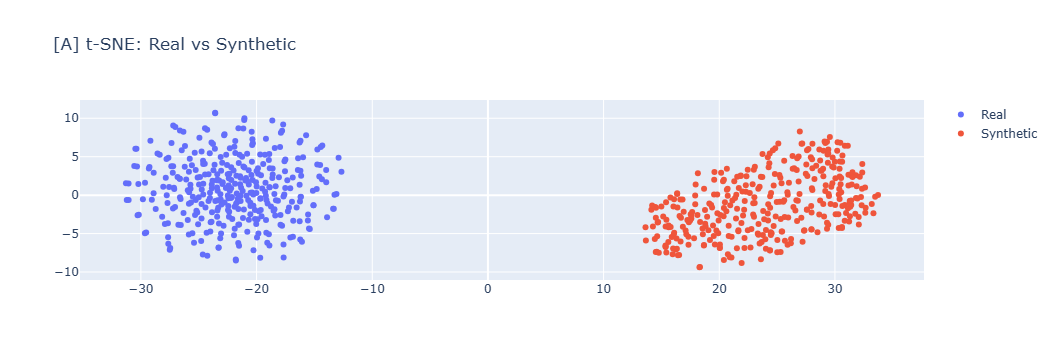

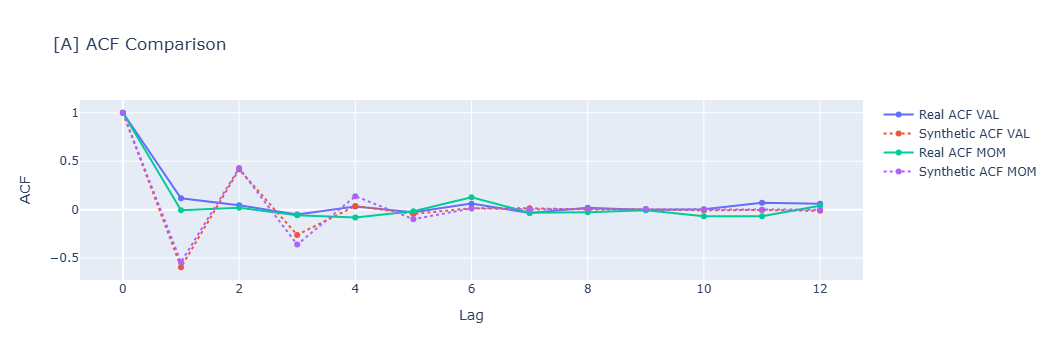

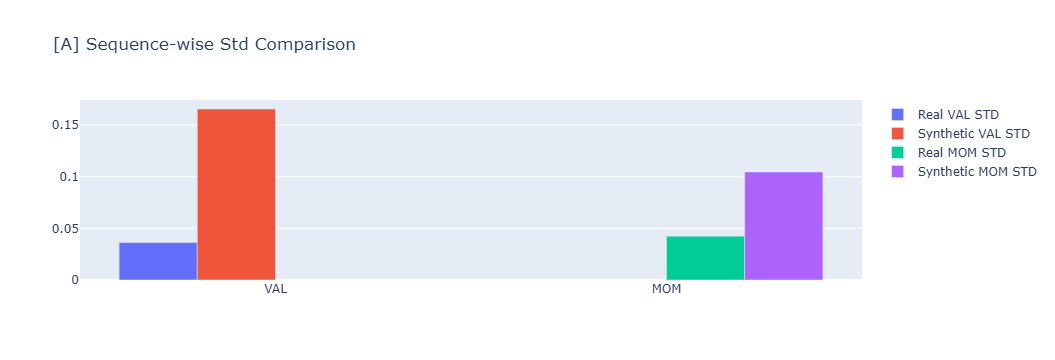


🔍 Now processing model B for assets: ['US', 'UK', 'EU', 'JP']
✅ TimeGAN model loaded.
🔢 Real sequence count for B: 353
🧪 Running visualizations for model B...


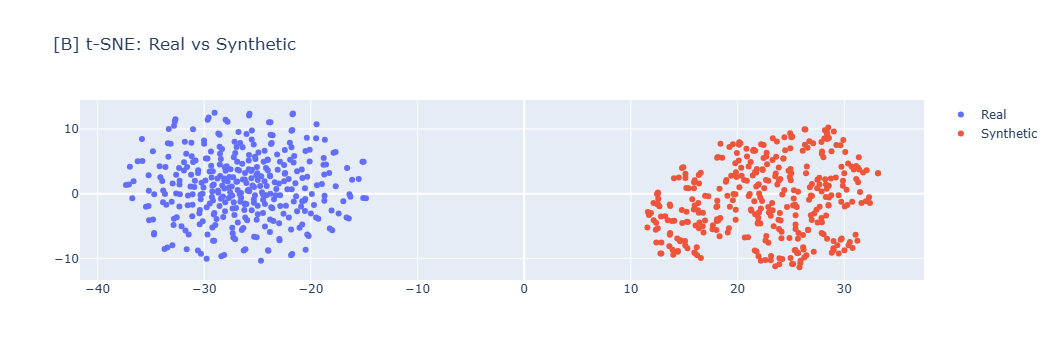

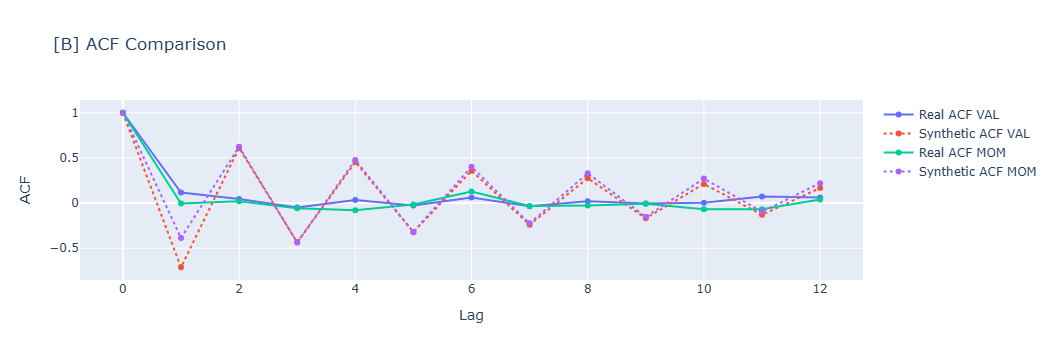

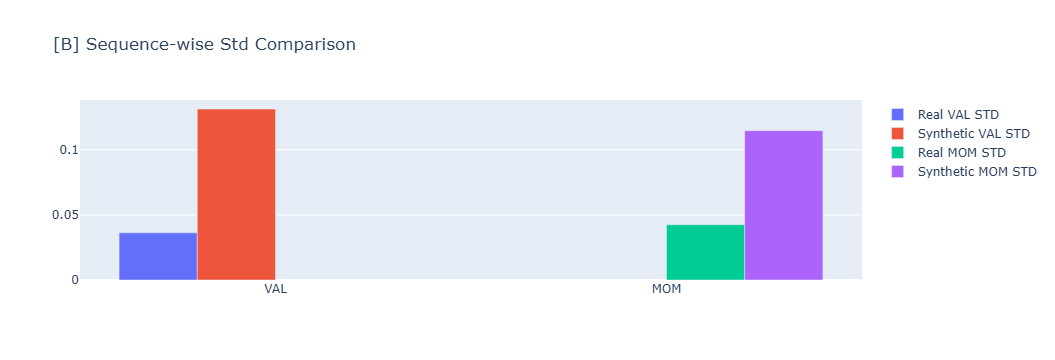


🔍 Now processing model C for assets: ['US', 'UK', 'EU', 'JP', 'EQ', 'FX', 'FI', 'CM']
✅ TimeGAN model loaded.
🔢 Real sequence count for C: 353
🧪 Running visualizations for model C...


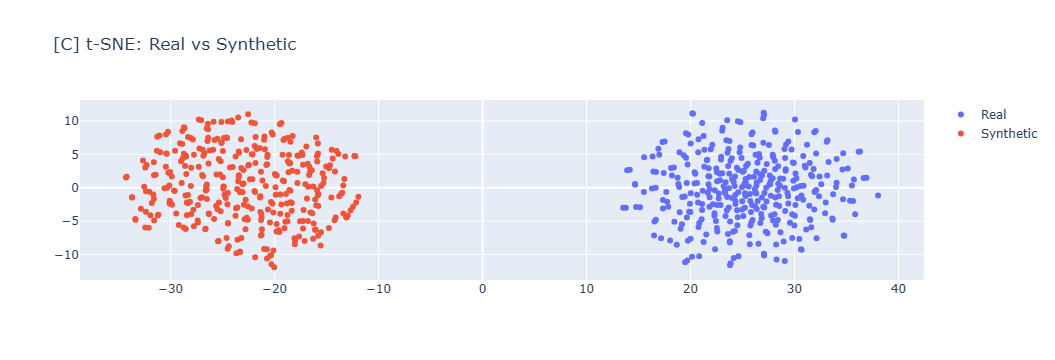

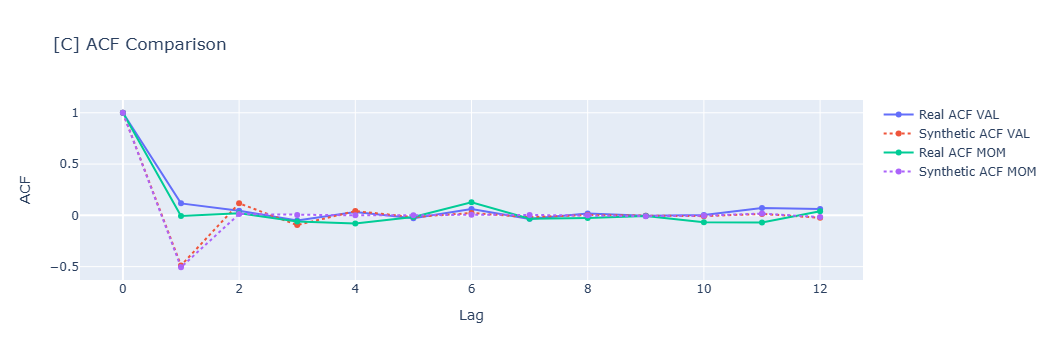

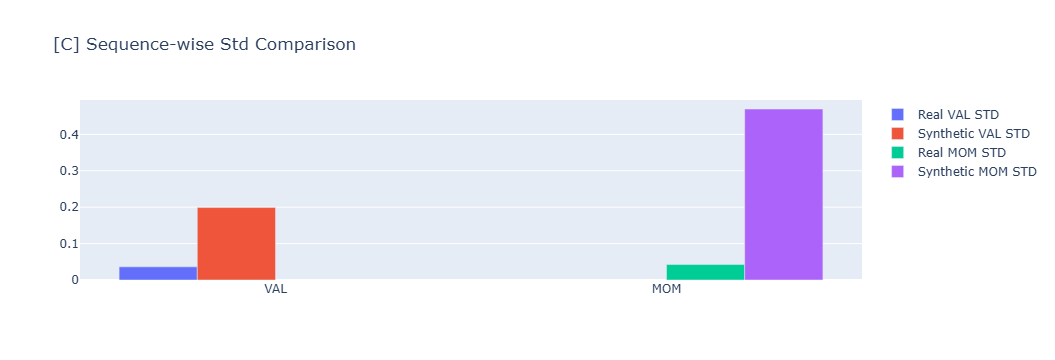


🔍 Now processing model D for assets: ['UK']
✅ TimeGAN model loaded.
🔢 Real sequence count for D: 240
🧪 Running visualizations for model D...


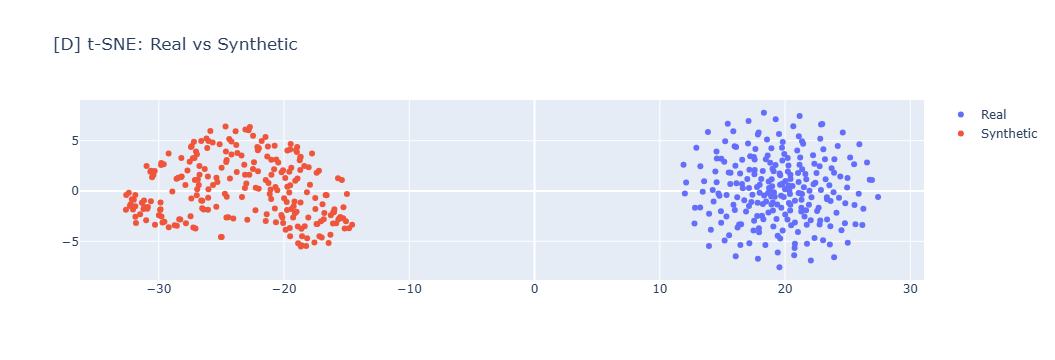

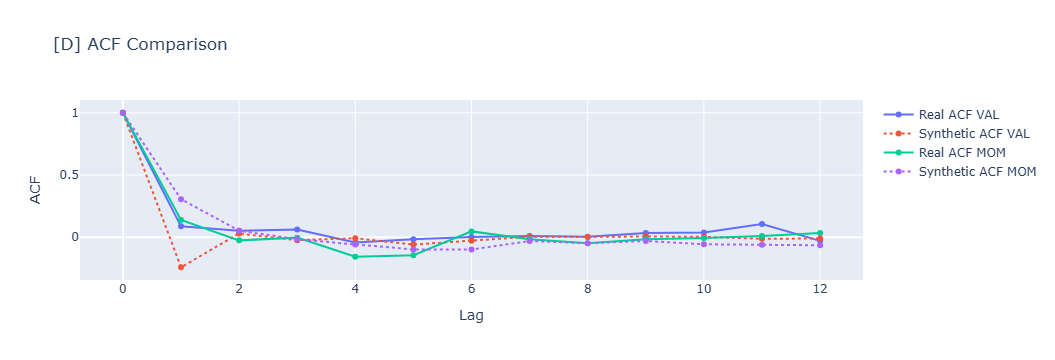

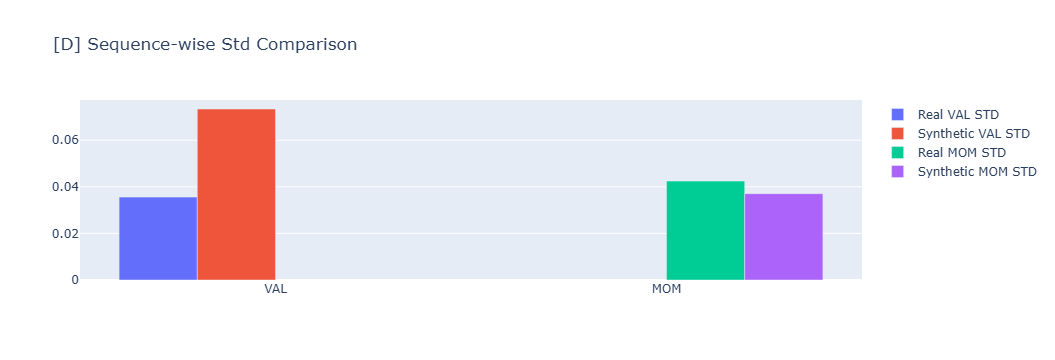


🔍 Now processing model E for assets: ['EU']
✅ TimeGAN model loaded.
🔢 Real sequence count for E: 240
🧪 Running visualizations for model E...


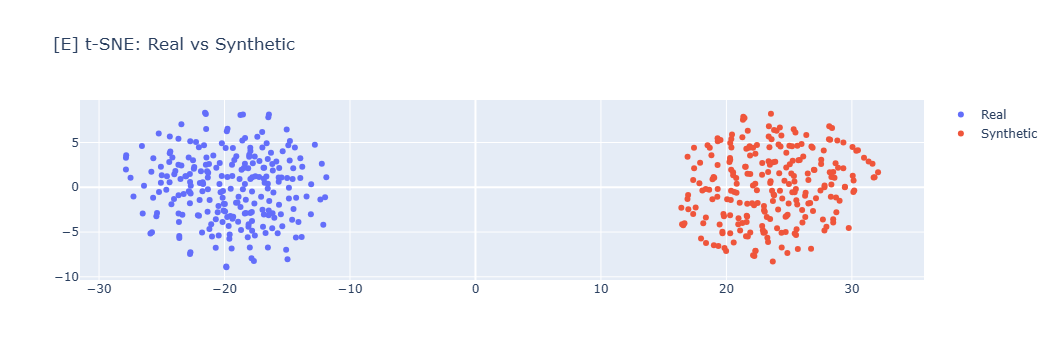

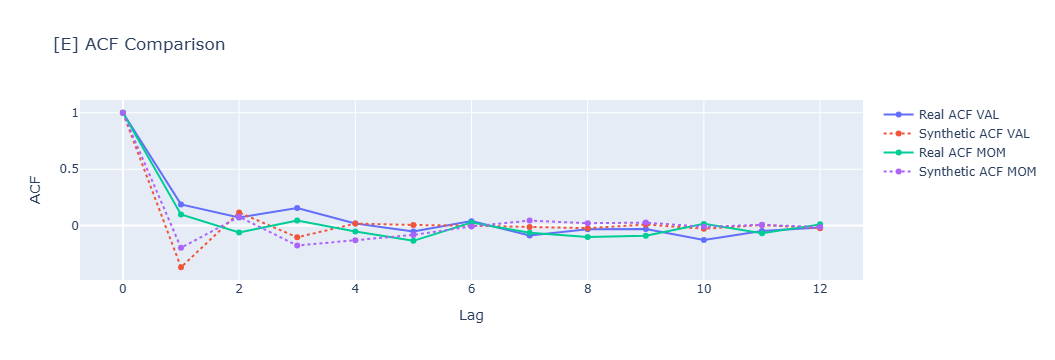

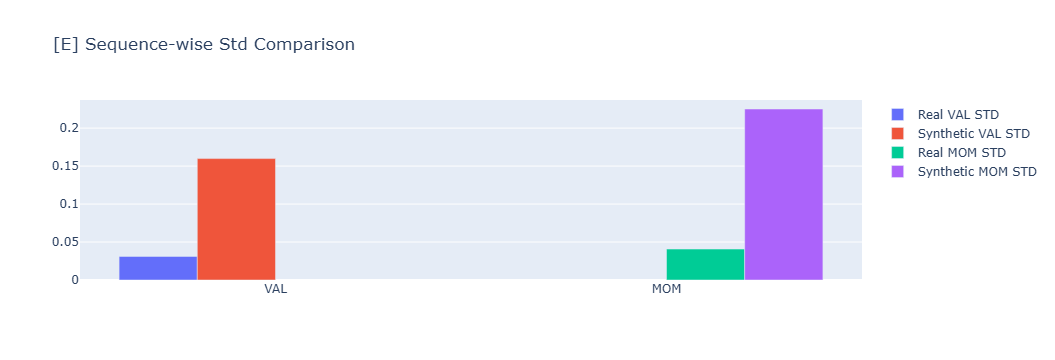


🔍 Now processing model F for assets: ['JP']
✅ TimeGAN model loaded.
🔢 Real sequence count for F: 240
🧪 Running visualizations for model F...


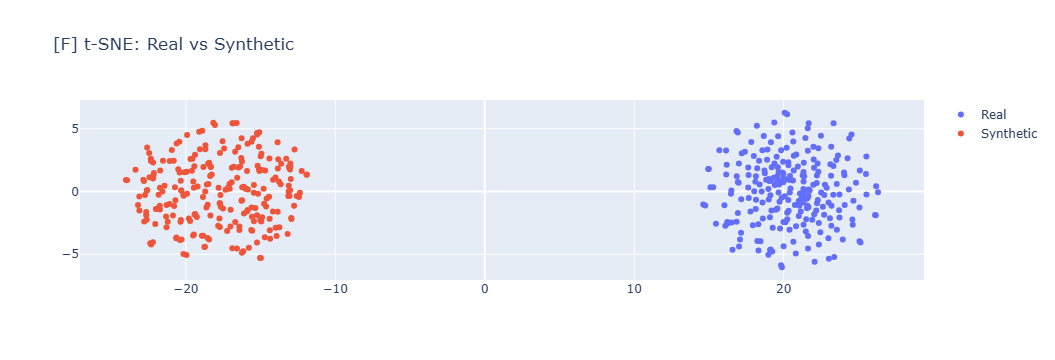

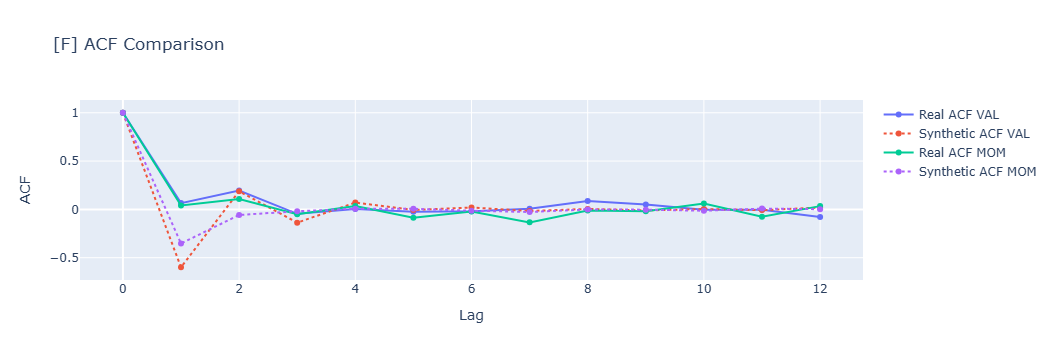

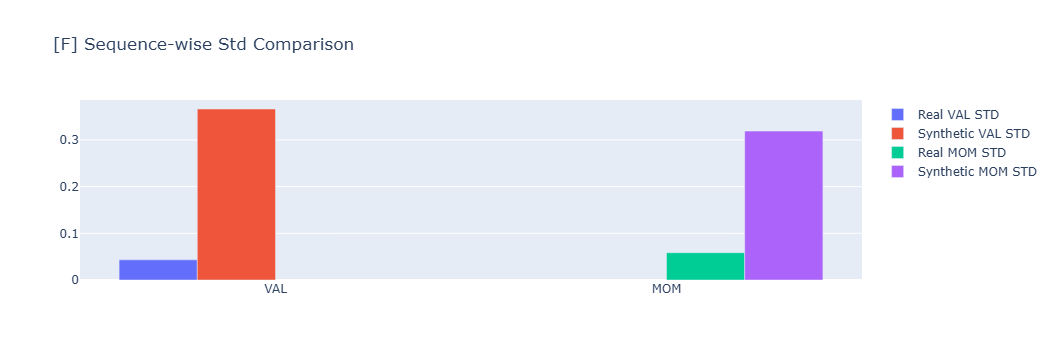

In [20]:
file_path = 'Value and Momentum Everywhere Original Paper Data.xlsx'
df_factors = load_vme_portfolios(file_path)

# === 2. 변동성 스케일링 적용 ===
# 각 VAL_자산군 및 MOM_자산군 컬럼에 대해 변동성 스케일링을 적용합니다.
# lookback_months=36 (기본값) 및 min_lookback_months=6 적용
scaled_df_portfolios = pd.DataFrame(index=df_factors.index)
asset_classes = ['US', 'UK', 'EU', 'JP', 'EQ', 'FX', 'FI', 'CM']
for asset in asset_classes:
    val_col = f'VAL_{asset}'
    mom_col = f'MOM_{asset}'
    
    if val_col in df_factors.columns and mom_col in df_factors.columns:
        # VAL 팩터 수익률 스케일링
        scaled_df_portfolios[val_col] = volatility_scale_monthly_returns(
            df_factors[val_col], lookback_months=36, min_lookback_months=6, annual_vol_target=0.02
        )
        # MOM 팩터 수익률 스케일링
        scaled_df_portfolios[mom_col] = volatility_scale_monthly_returns(
            df_factors[mom_col], lookback_months=36, min_lookback_months=6, annual_vol_target=0.02
        )
    else:
        print(f"⚠️ Skipping scaling for {asset}: Missing original columns.")

df_factors_trimmed = df_factors[df_factors.index <= '2010-06-30'].copy()

last_date_all_data = df_factors_trimmed.index.max()
cutoff_test = last_date_all_data - pd.DateOffset(years=3) # 테스트셋 시작 날짜
cutoff_val = cutoff_test - pd.DateOffset(years=3) # 학습셋 끝 날짜

# 전체 결합 데이터 중 학습 데이터셋 선택
train_idx_combined = df_factors_trimmed.index < cutoff_val
df_factors_trimmed_train = df_factors_trimmed[train_idx_combined]

# === 시각화 대상 자산군 정의 ===
asset_sets = {
    "A": ['US'],
    "B": ['US', 'UK', 'EU', 'JP'],
    "C": ['US', 'UK', 'EU', 'JP', 'EQ', 'FX', 'FI', 'CM'],
    "D": ['UK'],
    "E": ['EU'],
    "F": ['JP']
}

# === 시각화 반복 ===
for key, assets in asset_sets.items():
    print(f"\n🔍 Now processing model {key} for assets: {assets}")

    # 1. 모델 로드
    trainer = TimeGANTrainer(input_size=2, device='cuda' if torch.cuda.is_available() else 'cpu')
    load_timegan_model(trainer, f"timegan_model_{key}")

    # 2. 실제 학습 데이터 준비
    val_col = f'VAL_{assets[0]}'
    mom_col = f'MOM_{assets[0]}'
    real_df = df_factors_trimmed_train[[val_col, mom_col]].dropna().copy()
    real_df.columns = ['VAL', 'MOM']
    real_np = real_df[['VAL', 'MOM']].values
    real_seq = split_real_into_overlapping_chunks(real_np, chunk_len=36)

    print(f"🔢 Real sequence count for {key}: {len(real_seq)}")

    # 3. Synthetic 시퀀스 생성
    synthetic_seq = generate_many_synthetic_sequences(trainer, n_seq=len(real_seq), seq_len=36)

    # 4. 시각화 실행
    print(f"🧪 Running visualizations for model {key}...")

    fig_tsne = tsne_plot_sequences(real_seq, synthetic_seq)
    fig_tsne.update_layout(title=f"[{key}] t-SNE: Real vs Synthetic")
    fig_tsne.show()

    fig_acf = plot_acf_comparison_from_sequences(real_seq, synthetic_seq)
    fig_acf.update_layout(title=f"[{key}] ACF Comparison")
    fig_acf.show()

    fig_std = std_across_sequences(real_seq, synthetic_seq)
    fig_std.update_layout(title=f"[{key}] Sequence-wise Std Comparison")
    fig_std.show()


## 딥러닝(예측, GRU/LSTM)

In [65]:
# === Step 1: 데이터 로드 및 전처리 ===
import pandas as pd
from dateutil.relativedelta import relativedelta
import itertools
import os, json, torch
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
import numpy as np
import joblib  # for saving sklearn models

# === 🧱 유틸 함수 정의 ===
# real: sliding window 13으로 시퀀스 + label 생성
def generate_real_sequences(df, assets, test_asset, lookback=13):
    cols = [f'VAL_{a}' for a in assets] + [f'MOM_{a}' for a in assets]
    data = df[cols].values  # (T, 2*len(assets))
    # split_real_into_overlapping_chunks이 data → (n_seq, lookback, features) 반환한다고 가정
    real_seqs = split_real_into_overlapping_chunks(data, chunk_len=lookback)
    # label: 마지막 step의 test_asset MOM>VAL?
    i = assets.index(test_asset)
    idx_val, idx_mom = 2*i, 2*i+1
    real_labels = np.array([
        1.0 if seq[-1, idx_mom] > seq[-1, idx_val] else 0.0
        for seq in real_seqs
    ], dtype=np.float32)
    return real_seqs, real_labels

# synth: length=36짜리 → split_sequences_head_tail_only → (n*2,13,features), (n*2,1,features)
def generate_synth_sequences(trainer, n_seq, seq_len, assets, test_asset, lookback=13):
    synth = generate_many_synthetic_sequences(trainer, n_seq=n_seq, seq_len=seq_len)
    Xs, ys_feat = split_sequences_head_tail_only(synth, input_len=lookback, forecast_len=1)
    # ys_feat: shape (n_seq*2, 1, features)
    i = assets.index(test_asset)
    idx_val, idx_mom = 2*i, 2*i+1
    synth_labels = (ys_feat[:,0,idx_mom] > ys_feat[:,0,idx_val]).astype(np.float32)
    return Xs, synth_labels

# DataLoader 묶기
def make_loader(X, y, batch_size=32, shuffle=False):
    ds = TensorDataset(torch.tensor(X, dtype=torch.float32),
                       torch.tensor(y, dtype=torch.float32))
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)


be_conservative = False

file_path = 'Value and Momentum Everywhere Original Paper Data.xlsx'
df_factors = load_vme_portfolios(file_path)

# 변동성 스케일링 적용
scaled_df_portfolios = pd.DataFrame(index=df_factors.index)
asset_classes = ['US', 'UK', 'EU', 'JP', 'EQ', 'FX', 'FI', 'CM']
for asset in asset_classes:
    val_col = f'VAL_{asset}'
    mom_col = f'MOM_{asset}'
    if val_col in df_factors.columns and mom_col in df_factors.columns:
        scaled_df_portfolios[val_col] = volatility_scale_monthly_returns(
            df_factors[val_col], lookback_months=36, min_lookback_months=6, annual_vol_target=0.02
        )
        scaled_df_portfolios[mom_col] = volatility_scale_monthly_returns(
            df_factors[mom_col], lookback_months=36, min_lookback_months=6, annual_vol_target=0.02
        )
    else:
        print(f"⚠️ Skipping scaling for {asset}: Missing original columns.")

# 시계열 기준 설정
if be_conservative : 
    cutoff_date = pd.to_datetime('2010-06-30')
    df_factors_trimmed = df_factors[df_factors.index <= cutoff_date].copy()
else : 
    df_factors_trimmed = df_factors.copy()

last_date_all_data = df_factors_trimmed.index.max()
cutoff_test = last_date_all_data - pd.DateOffset(years=3)
cutoff_val = cutoff_test - pd.DateOffset(years=3)

train_idx_combined = df_factors_trimmed.index < cutoff_val
df_factors_trimmed_train = df_factors_trimmed[train_idx_combined]

# === Step 2: 모델 A-F의 학습/테스트 데이터 생성 ===
model_sets = {
    'A': ['US'],
    'B': ['US', 'UK', 'EU', 'JP'],
    'C': ['US', 'UK', 'EU', 'JP', 'EQ', 'FX', 'FI', 'CM'],
    'D': ['UK'],
    'E': ['EU'],
    'F': ['JP']
}

data_dict = {}  # A~F까지 각 모델에 대해 real/synthetic split 데이터 보관

for key, assets in model_sets.items():
    print(f"Processing {key}...")
    # 1. 실제 데이터
    train_tensor = prepare_timegan_training_data(df_factors_trimmed_train, assets)
    real_np = train_tensor.numpy()
    real_seq = split_real_into_overlapping_chunks(real_np, chunk_len=36)
    X_real, y_real = split_sequences_head_tail_only(real_seq, input_len=13, forecast_len=1)

    # 2. 증강 데이터 (동일 개수로 생성)
    timegan_trainer = TimeGANTrainer(input_size=2, z_dim=1, device='cuda' if torch.cuda.is_available() else 'cpu')
    load_timegan_model(timegan_trainer, f"timegan_model_{key}")
    synthetic_np = generate_many_synthetic_sequences(timegan_trainer, n_seq=len(real_seq), seq_len=36)
    X_synth, y_synth = split_sequences_head_tail_only(synthetic_np, input_len=13, forecast_len=1)

    # 3. 병합 및 저장
    X_total = np.concatenate([X_real, X_synth], axis=0)
    y_total = np.concatenate([y_real, y_synth], axis=0)

    data_dict[key] = {
        'X_real': X_real, 'y_real': y_real,
        'X_synth': X_synth, 'y_synth': y_synth,
        'X_total': X_total, 'y_total': y_total
    }

# === Step 3: Hyperparameter 조합 정의 ===
hidden_sizes = [8, 16, 32]
num_layers_list = [2, 3, 4]
batch_sizes = [16, 32, 64]
learning_rates = [1e-4, 1e-3, 1e-2]

hyperparam_combinations = list(itertools.product(hidden_sizes, num_layers_list, batch_sizes, learning_rates))

Processing A...
✅ TimeGAN model loaded.
Processing B...
✅ TimeGAN model loaded.
Processing C...
✅ TimeGAN model loaded.
Processing D...
✅ TimeGAN model loaded.
Processing E...
✅ TimeGAN model loaded.
Processing F...
✅ TimeGAN model loaded.


In [30]:
# 2. GRU/LSTM 공용 Classifier
class RNNClassifier(nn.Module):
    def __init__(self, model_type='GRU', input_size=2, hidden_size=16, num_layers=3, dropout=0.2):
        super(RNNClassifier, self).__init__()
        rnn_cls = nn.GRU if model_type == 'GRU' else nn.LSTM
        self.rnn = rnn_cls(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.activation = ExponentialReLU()
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.activation(out[:, -1, :])
        return self.sigmoid(self.fc(out)).squeeze()

# 3. DataLoader 생성 함수
from torch.utils.data import TensorDataset, DataLoader
def get_dataloaders(X, y, batch_size=32, split_ratio=(0.7, 0.15, 0.15)):
    total = len(X)
    train_end = int(split_ratio[0] * total)
    val_end = train_end + int(split_ratio[1] * total)

    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    train_ds = TensorDataset(X_tensor[:train_end], y_tensor[:train_end])
    val_ds = TensorDataset(X_tensor[train_end:val_end], y_tensor[train_end:val_end])
    test_ds = TensorDataset(X_tensor[val_end:], y_tensor[val_end:])

    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=False),
        DataLoader(val_ds, batch_size=batch_size),
        DataLoader(test_ds, batch_size=batch_size)
    )

# 4. 학습 함수
def train_model(model, train_loader, val_loader, device='cpu', epochs=200, lr=1e-3, patience=20):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    best_loss = float('inf')
    patience_counter = 0
    best_state = None

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                val_loss += criterion(pred, yb).item()
        val_loss /= len(val_loader)

        if val_loss < best_loss - 1e-4:
            best_loss = val_loss
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"⛔ Early stopping at epoch {epoch+1}")
                break
    model.load_state_dict(best_state)
    return model

# 5. 전략 수익률 계산
def evaluate_strategy_performance(model, test_loader, val_series, mom_series, device='cpu'):
    model.eval()
    preds = []
    with torch.no_grad():
        for xb, _ in test_loader:
            xb = xb.to(device)
            preds.extend(model(xb).cpu().numpy())

    preds_bin = (np.array(preds) > 0.5).astype(int)
    val_weights = 1 - preds_bin
    mom_weights = preds_bin
    strategy_returns = val_weights * val_series + mom_weights * mom_series
    cum_returns = (1 + strategy_returns).cumprod()
    return cum_returns

In [60]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Path("saved_models").mkdir(exist_ok=True)
Path("best_hyperparams").mkdir(exist_ok=True)

# 결과 저장용
result_dict = {}

for model_key in ['A', 'B', 'C', 'D', 'E', 'F']:
    print(f"\n🚀 Running Model {model_key}")
    result_dict[model_key] = {}
    
    for data_type in ['X_real', 'X_total']:  # real-only / real+synthetic
        print(f"📦 Training on {'real-only' if data_type == 'X_real' else 'real+synthetic'} data")

        X = data_dict[model_key][data_type]
        y = data_dict[model_key]['y_real'] if data_type == 'X_real' else data_dict[model_key]['y_total']

        # 수정: binary label 생성
        y_binary = (y[:, 0, 1] > y[:, 0, 0]).astype(np.float32)
        
        # DataLoader 분리
        # train_loader, val_loader, test_loader = get_dataloaders(X, y_binary, batch_size=best_params['batch_size'])

        for model_type in ['GRU', 'LSTM']:
            print(f"🧠 Searching best {model_type} for {model_key}-{data_type}")

            # JSON 경로 정의
            json_path = f"best_hyperparams/{model_key}_{data_type}_{model_type}.json"
            model_path = f"saved_models/{model_key}_{data_type}_{model_type}.pt"

            # 1) loader 생성 — default batch=32 or 이전에 저장된 값을 사용
            if os.path.exists(json_path):
                best_params = json.load(open(json_path))
            else:
                best_params = {}  # 빈 dict

            batch = best_params.get('batch_size', 32)
            train_loader, val_loader, test_loader = get_dataloaders(X, y_binary, batch_size=batch)


            # 2) hyperparam search
            if not os.path.exists(json_path):
                best_score = -np.inf
                best_model = None
                best_params = {}
                
                for hidden, layers, bs, lr in hyperparam_combinations:
                    model = RNNClassifier(model_type=model_type, hidden_size=hidden, num_layers=layers)
                    trained = train_model(model, train_loader, val_loader, device=device, lr=lr, patience=20)
                    score = evaluate_val_accuracy(trained, val_loader, device)
                    if score > best_score:
                        best_score = score
                        best_model = trained
                        best_params = {
                            "hidden_size": hidden,
                            "num_layers": layers,
                            "batch_size": bs,
                            "lr": lr
                        }

                with open(json_path, 'w') as f:
                    json.dump(best_params, f)
                torch.save(best_model.state_dict(), model_path)
                print(f"✅ Saved best model and hyperparams for {model_key}-{data_type}-{model_type}")
            else:
                print(f"📂 Loading best params from {json_path}")
                with open(json_path, 'r') as f:
                    best_params = json.load(f)
                model = RNNClassifier(model_type=model_type,
                                      hidden_size=best_params['hidden_size'],
                                      num_layers=best_params['num_layers']).to(device)
                model.load_state_dict(torch.load(model_path, map_location=device))
                best_model = model

            # B, C는 validation/test 데이터에서 US만 남기기
            if model_key in ['B', 'C']:
                test_loader = extract_us_only_from_loader(test_loader)
            if model_key in ['D', 'E', 'F']:
                test_loader = extract_only_selected_asset(test_loader, asset=model_sets[model_key][0])  # UK, EU, JP

            result_dict[model_key][f"{model_type}_{data_type}"] = {
                "model": best_model,
                "params": best_params
            }

    # === 머신러닝 (A~F) 증강+통합 데이터 대상 재학습 ===
    # for model_key in ['A', 'B', 'C', 'D', 'E', 'F']:
    #     print(f"🧠 Training ML Models for {model_key}")
    #     X_ml = data_dict[model_key]['X_total'].reshape(len(data_dict[model_key]['X_total']), -1)
    #     y_ml = data_dict[model_key]['y_total'][:, 0, 1]  # MOM을 예측
    
    #     svm_model = run_svm_prediction(X_ml, y_ml)
    #     xgb_model = run_xgb_prediction(X_ml, y_ml)
    
    #     joblib.dump(svm_model, f"saved_models/{model_key}_svm.pkl")
    #     joblib.dump(xgb_model, f"saved_models/{model_key}_xgb.pkl")
    
    #     result_dict[model_key]['SVM'] = svm_model
    #     result_dict[model_key]['XGB'] = xgb_model



🚀 Running Model A
📦 Training on real-only data
🧠 Searching best GRU for A-X_real
📂 Loading best params from best_hyperparams/A_X_real_GRU.json
🧠 Searching best LSTM for A-X_real
📂 Loading best params from best_hyperparams/A_X_real_LSTM.json
📦 Training on real+synthetic data
🧠 Searching best GRU for A-X_total
📂 Loading best params from best_hyperparams/A_X_total_GRU.json
🧠 Searching best LSTM for A-X_total
📂 Loading best params from best_hyperparams/A_X_total_LSTM.json

🚀 Running Model B
📦 Training on real-only data
🧠 Searching best GRU for B-X_real
⛔ Early stopping at epoch 27
⛔ Early stopping at epoch 21
⛔ Early stopping at epoch 21
⛔ Early stopping at epoch 27
⛔ Early stopping at epoch 22
⛔ Early stopping at epoch 78
⛔ Early stopping at epoch 26
⛔ Early stopping at epoch 21
⛔ Early stopping at epoch 74
⛔ Early stopping at epoch 28
⛔ Early stopping at epoch 21
⛔ Early stopping at epoch 93
⛔ Early stopping at epoch 27
⛔ Early stopping at epoch 21
⛔ Early stopping at epoch 21
⛔ Early s

IndexError: too many indices for tensor of dimension 1

In [ ]:
import plotly.graph_objects as go

def load_best_model(model_key, data_tag, model_type):
    if model_type in ("GRU", "LSTM"):
        model = RNNClassifier(model_type, 2,
                              results[model_key][f"{model_type}_{data_tag}"]["params"]["hidden"],
                              results[model_key][f"{model_type}_{data_tag}"]["params"]["layers"]).to(DEVICE)
        model.load_state_dict(
            torch.load(f"saved_models/{model_key}_{model_type}_{data_tag}.pt", map_location=DEVICE)
        )
        model.eval()
        return model
    else:  # SVM / XGB
        return joblib.load(f"saved_models/{model_key}_{model_type}_{data_tag}.pkl")

def plot_cum_returns(model_key="A", data_tag="real", model_type="GRU"):
    assets   = MODEL_SETS[model_key]
    label_as = assets[0]

    # 재-생성: train/val/test 분할과 동일한 X, y, 날짜
    datasets   = build_datasets(df_train, assets, label_as, model_key)
    X, y       = datasets[data_tag]
    n          = len(X)
    idx_tr     = int(0.7*n); idx_val = int(0.85*n)
    X_test     = X[idx_val:]
    dates_all  = df_train.index[-len(X):]          # 13-step 윈도우 시작시점
    test_dates = dates_all[idx_val:] + pd.DateOffset(months=12)  # 13-window → 마지막 step 날짜

    model = load_best_model(model_key, data_tag, model_type)

    # --- 예측 확률 → 모멘텀(1) / 밸류(0) weight
    if model_type in ("GRU", "LSTM"):
        preds = []
        with torch.no_grad():
            for xb,_ in make_loader(X_test, y[idx_val:], batch=32):
                preds.extend(model(xb.to(DEVICE)).cpu().numpy())
        mom_w = (np.array(preds) > 0.5).astype(int)
    else:
        mom_w = model.predict(X_test.reshape(len(X_test), -1))

    val_w = 1 - mom_w

    val_col, mom_col = f"VAL_{label_as}", f"MOM_{label_as}"
    val_ret = df_raw.loc[test_dates, val_col]
    mom_ret = df_raw.loc[test_dates, mom_col]

    strat_ret = val_w * val_ret.values + mom_w * mom_ret.values
    cum = pd.Series(np.concatenate([[1], (1 + strat_ret).cumprod()]),
                    index=pd.concat([pd.Index([test_dates[0] - pd.DateOffset(months=1)]), test_dates]))

    bench = pd.Series(np.concatenate([[1], (1 + 0.5*val_ret + 0.5*mom_ret).cumprod()]),
                      index=cum.index)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=cum.index, y=cum, mode='lines',
                             name=f"{model_key}-{model_type}-{data_tag}"))
    fig.add_trace(go.Scatter(x=bench.index, y=bench, mode='lines',
                             name="50:50 Benchmark", line=dict(dash='dash')))
    fig.update_layout(title="Cumulative Returns",
                      xaxis_title="Date", yaxis_title="Cumulative Return",
                      template="plotly_white")
    fig.show()

# 예시:
# plot_cum_returns("A", "real", "GRU")
# plot_cum_returns("B", "total", "XGB")


In [73]:
import itertools, json, math, os
from pathlib import Path
from typing import Dict, List, Tuple

import joblib, numpy as np, pandas as pd, torch, torch.nn as nn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from torch.utils.data import DataLoader, TensorDataset
from xgboost import XGBClassifier

# ---------------------------- 전역 설정 ------------------------------------
MODEL_SETS: Dict[str, List[str]] = {
    "A": ["US"],
    "B": ["US", "UK", "EU", "JP"],
    "C": ["US", "UK", "EU", "JP", "EQ", "FX", "FI", "CM"],
    "D": ["UK"],
    "E": ["EU"],
    "F": ["JP"],
}

HIDDEN_SIZES   = [8, 16, 32]
NUM_LAYERS     = [2, 3, 4]
BATCH_SIZES    = [16, 32, 64]
LEARNING_RATES = [1e-4, 1e-3, 1e-2]
HYPER_COMBOS   = list(itertools.product(HIDDEN_SIZES, NUM_LAYERS, BATCH_SIZES, LEARNING_RATES))

SVM_PARAM_GRID = {
    "svc__kernel": ["rbf", "linear"],
    "svc__C"     : [0.1, 1, 10],
    "svc__gamma" : ["scale", "auto"],
}
XGB_PARAM_GRID = {
    "xgb__n_estimators" : [50, 100, 200],
    "xgb__max_depth"    : [2, 3, 4],
    "xgb__learning_rate": [0.05, 0.1, 0.2],
    "xgb__subsample"    : [0.8, 1.0],
}

LOOKBACK = 13  # 12+1
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"
# ---------------- 전역 ----------------
INPUT_STEPS = 12        # 과거 12개월
TARGET_SHIFT = 1        # 1개월 뒤 라벨
WINDOW = INPUT_STEPS + TARGET_SHIFT   # == 13
# ------------------------ 머신러닝용 ML -------------------------------------
def run_ml(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray, which: str):
    if which == "SVM":
        pipe, grid = Pipeline([("scaler", StandardScaler()), ("svc", SVC())]), SVM_PARAM_GRID
    else:
        pipe, grid = Pipeline([("scaler", StandardScaler()), ("xgb", XGBClassifier(objective="binary:logistic", eval_metric="logloss", use_label_encoder=False, n_jobs=-1))]), XGB_PARAM_GRID
    gs = GridSearchCV(pipe, grid, cv=TimeSeriesSplit(3), scoring="accuracy", n_jobs=-1)
    gs.fit(np.vstack([X_train, X_val]), np.hstack([y_train, y_val]))
    return gs

# ------------------------ TimeGAN 로더 -------------------------------------

def load_timegan_model(trainer, prefix: str):
    for comp in ["embedder", "recovery", "generator", "supervisor", "discriminator"]:
        trainer.__getattribute__(comp).load_state_dict(
            torch.load(f"{prefix}_{comp}.pth", map_location=trainer.device))

# ------------------------ 유틸 함수 ----------------------------------------

def volatility_scale_monthly_returns(series: pd.Series, lookback_months=36, min_lookback_months=6, annual_vol_target=0.02):
    scaled = pd.Series(np.nan, index=series.index)
    target = annual_vol_target / math.sqrt(12)
    roll = series.rolling(lookback_months, min_periods=min_lookback_months).std()
    for i, (r, s) in enumerate(zip(series, roll)):
        scaled.iat[i] = (r/ s) * target if pd.notna(s) and s>0 else np.nan
    return scaled


def load_vme_portfolios(path: str) -> pd.DataFrame:
    df = pd.read_excel(path, sheet_name="VME Portfolios", header=12)
    df.DATE = pd.to_datetime(df.DATE); df = df.set_index("DATE")
    df = df.applymap(lambda x: float(str(x).replace("%", ""))/100 if isinstance(x,str) and "%" in x else x)
    asset_classes = ["US","UK","EU","JP","EQ","FX","FI","CM"]
    out = {}
    for a in asset_classes:
        try:
            out[f"VAL_{a}"] = df[f"VAL3{a}"] - df[f"VAL1{a}"]
            out[f"MOM_{a}"] = df[f"MOM3{a}"] - df[f"MOM1{a}"]
        except KeyError:
            pass
    return pd.DataFrame(out)


# def create_binary_labels(seqs: np.ndarray, asset_idx: int) -> np.ndarray:
#     v, m = 2*asset_idx, 2*asset_idx+1
#     return (seqs[:, -1, m] > seqs[:, -1, v]).astype(np.float32)


def make_loader(X, y, batch, shuffle=False):
    ds = TensorDataset(torch.tensor(X,dtype=torch.float32), torch.tensor(y,dtype=torch.float32))
    return DataLoader(ds, batch_size=batch, shuffle=shuffle)

# ------------------------ RNN ------------------------------------------------
class RNNClassifier(nn.Module):
    def __init__(self, rnn_type: str, input_size: int, hidden: int, layers: int):
        super().__init__()
        rnn_cls = nn.GRU if rnn_type.upper()=="GRU" else nn.LSTM
        self.rnn = rnn_cls(input_size, hidden, layers, batch_first=True, dropout=0.2)
        self.fc  = nn.Linear(hidden,1); self.act = nn.Sigmoid()
    def forward(self,x):
        o,_ = self.rnn(x); return self.act(self.fc(o[:,-1])).squeeze(-1)


def accuracy(model, loader):
    model.eval(); pr, lab = [],[]
    with torch.no_grad():
        for xb,yb in loader:
            pr.extend(model(xb.to(DEVICE)).cpu().numpy())
            lab.extend(yb.numpy())
    return accuracy_score(lab, (np.array(pr)>0.5).astype(int))


def train_rnn(model, tr, val, lr=1e-3, epochs=200, patience=20):
    model.to(DEVICE); opt = torch.optim.Adam(model.parameters(), lr=lr); crit = nn.BCELoss()
    best, best_acc, wait = None, -1, 0
    for _ in range(epochs):
        model.train()
        for xb,yb in tr:
            xb,yb=xb.to(DEVICE), yb.to(DEVICE); opt.zero_grad(); crit(model(xb), yb).backward(); opt.step()
        acc = accuracy(model, val)
        if acc>best_acc+1e-4: best_acc, best, wait = acc, model.state_dict(),0
        else: wait+=1;  
        if wait>=patience: break
    model.load_state_dict(best); return model, best_acc

# ------------------- Sliding window 생성 -----------------------------------

# def make_sliding_sequences(df_feat: pd.DataFrame, assets: List[str]):
#     cols = [f"VAL_{a}" for a in assets] + [f"MOM_{a}" for a in assets]
#     mat  = df_feat[cols].values
#     seqs, dates = [], []

#     for i in range(len(mat) - LOOKBACK + 1):
#         win = mat[i:i+LOOKBACK]
#         if np.isnan(win).any():
#             continue
#         seq_end_date = df_feat.index[i+LOOKBACK-1]

#         # --- ⚠️ 로그: 윈도우의 과거/현재 범위 ---
#         if i % 500 == 0:   # 과다 출력 방지
#             print(f"[WINDOW] end={seq_end_date.date()}  "
#                   f"start={df_feat.index[i].date()}")

#         seqs.append(win); dates.append(seq_end_date)

#     seq_arr = np.array(seqs)
#     y = create_binary_labels(seq_arr, 0)

#     # --- ⚠️ assert: 레이블 생성 시점 = 윈도우 마지막 step ---
#     assert (seq_arr[:, -1, 1] > -10).all(), "label calc mis-aligned?"

#     return seq_arr, y, pd.DatetimeIndex(dates)
# ---------------- 슬라이딩 윈도우 ----------------
def make_sliding_sequences(df_pair: pd.DataFrame):
    """
    X  : (INPUT_STEPS, 2)   → t-11 … t
    y  : MOM_{t+1} > VAL_{t+1}
    """
    mat = df_pair.values
    X_seq, y, dates = [], [], []

    for i in range(len(mat) - WINDOW + 1):
        win = mat[i : i + WINDOW]           # 길이 13
        if np.isnan(win).any():
            continue
        X_seq.append(win[:-TARGET_SHIFT])   # 앞 12개 → 입력
        # 타깃은 한 칸 뒤의 margin
        m_next = win[-1, 1] - win[-1, 0]    # MOM_{t+1} - VAL_{t+1}
        y.append(int(m_next > 0))
        dates.append(df_pair.index[i + INPUT_STEPS])   # t (윈도우 끝)

    X_arr = np.array(X_seq)                 # shape (N, 12, 2)
    y_arr = np.array(y, dtype=np.float32)
    return X_arr, y_arr, pd.DatetimeIndex(dates)

# ------------------- TimeGAN synthetic (per‑model key) ---------------------

def make_synthetic(trainer, n_seq:int, train_end: pd.Timestamp):
    need36 = math.ceil(n_seq/2)
    s36 = generate_many_synthetic_sequences(trainer, need36, 36)
    xs, _ = split_sequences_head_tail_only(s36, 13, 1)
    # ---- ⚠️ 검정: synthetic label 날짜가 train 구간만 사용하는지 ----
    synth_dates_mock = pd.date_range(end=train_end, periods=LOOKBACK, freq="M")
    # 실제 GAN 데이터에는 날짜가 없으므로 상징적으로 확인
    print(f"[GAN]  generated {xs.shape[0]} seq  |  treated as end≤{train_end.date()}")
    return xs[:n_seq]

def make_synthetic_multi(trainer_dict: Dict[str, TimeGANTrainer],
                         assets: List[str],
                         n_seq: int, seq_len: int = 36):
    """
    trainer_dict : {"US": trainer_A, "UK": trainer_D, ...}
    반환 shape    : (n_seq, 13, 2*len(assets))
    """
    per_asset = []
    for a in assets:
        tgan = trainer_dict[a]          # 자산별 2-feature TimeGAN
        s36  = generate_many_synthetic_sequences(tgan, n_seq, seq_len)
        xs, _ = split_sequences_head_tail_only(s36, 13, 1)   # (n_seq,13,2)
        per_asset.append(xs)           # 길이·shape 동일 보장
    return np.concatenate(per_asset, axis=2)  # (n_seq,13,2*len(assets))

# ------------------- build_datasets ----------------------------------------

def build_datasets(df: pd.DataFrame, assets: List[str], key: str):
    df = df.loc[:"2010-06-30"].copy()

    X_all, y_all, dates_all = [], [], []          # 초기화만

    # ── 자산별 윈도우 쌓기 ─────────────────────────────
    for a in assets:
        col_pair = df[[f'VAL_{a}', f'MOM_{a}']].dropna()
        seqs, y, d = make_sliding_sequences(col_pair)   # 2-feature
        X_all.append(seqs);  y_all.append(y);  dates_all.append(d)

    X_all   = np.vstack(X_all)
    y_all   = np.hstack(y_all)
    dates_all = pd.DatetimeIndex(np.concatenate(dates_all))

    last = dates_all.max()
    cut_test = last - pd.DateOffset(years=3)
    cut_val  = cut_test - pd.DateOffset(years=3)

    train_m = dates_all < cut_val
    val_m   = (dates_all >= cut_val) & (dates_all < cut_test)
    test_m  = dates_all >= cut_test

    # 날짜 경계 검정
    assert max(dates_all[train_m]) < min(dates_all[val_m])
    assert max(dates_all[val_m])  < min(dates_all[test_m])
    print(f"[CHECK {key}] train={train_m.sum()}  val={val_m.sum()}  test={test_m.sum()}")

    X_tr, y_tr = X_all[train_m], y_all[train_m]
    X_val,y_val= X_all[val_m] , y_all[val_m]
    X_te, y_te = X_all[test_m], y_all[test_m]

    # ── GAN 증강 ───────────────────────────────────────
    n_syn = len(X_tr)
    try:
        tgan = TimeGANTrainer(input_size=2, device=DEVICE)
        load_timegan_model(tgan, f"timegan_model_{key}")
        s36 = generate_many_synthetic_sequences(tgan, math.ceil(n_syn/2), 36)
        X_syn_raw, _ = split_sequences_head_tail_only(s36, input_len=WINDOW, forecast_len=1)  # (n,13,2)

        X_syn_feat = X_syn_raw[:, :-TARGET_SHIFT, :] 
        margin     = X_syn_raw[:, -1, 1] - X_syn_raw[:, -1, 0]
        y_syn      = (margin > 0).astype(np.float32)
        # 필요 개수만 자르기
        X_syn_feat = X_syn_feat[:n_syn];  y_syn = y_syn[:n_syn]
        print(f"[GAN] {key} synthetic added: {len(X_syn_feat)} seq (12×2)")
    except Exception as e:
        print(f"⚠️ TimeGAN load fail ({e}) → real-only")
        # X_syn, y_syn = np.empty((0, LOOKBACK, 2)), np.empty(0)

    X_total = np.concatenate([X_tr, X_syn_feat]) if len(X_syn_feat) else X_tr
    y_total = np.concatenate([y_tr, y_syn])      if len(y_syn)      else y_tr

    return {
        "real":  (X_tr, y_tr, X_val, y_val, X_te, y_te, 2),
        "total": (X_total, y_total, X_val, y_val, X_te, y_te, 2)
    }

def _debug_rolling_future_leak(series, lookback_months):
    # 마지막 lookback 구간만 검사
    tail = series.tail(lookback_months + 1)
    rolling_std = tail[:-1].std()      # TRUE past-only
    fn_std      = series.rolling(lookback_months).std().iloc[-1]
    if not np.isclose(rolling_std, fn_std, atol=1e-8):
        print("⚠️  Rolling-STD FUTURE leak? manual std != pandas std")

def debug_leak_check(dates_tr, dates_te):
    # 가장 늦은 train 날짜 < 가장 이른 test 날짜 ?
    assert dates_tr.max() < dates_te.min(), "date leakage!"

def debug_shift_check(X, y, df_pair):
    # 랜덤 샘플 하나로 t, t+1 관계 확인
    k = np.random.randint(len(X))
    t_end = df_pair.index.get_loc(df_pair.index[0]) + k + INPUT_STEPS -1
    val_t1 = df_pair['VAL'].iloc[t_end+1]
    mom_t1 = df_pair['MOM'].iloc[t_end+1]
    assert (mom_t1 > val_t1) == bool(y[k]), "label mis-shift"
    
save_dir = 'saved_models'
xlsx_path = "Value and Momentum Everywhere Original Paper Data.xlsx"
Path(save_dir).mkdir(exist_ok=True)
df_raw = load_vme_portfolios(xlsx_path)
df_scaled = pd.DataFrame({c: volatility_scale_monthly_returns(df_raw[c],36,6,0.02) for c in df_raw}, index=df_raw.index).dropna()

results: Dict = {k:{} for k in MODEL_SETS}

for key, assets in MODEL_SETS.items():
    print(f"\n=== Model {key}: {'/'.join(assets)} ===")
    ds = build_datasets(df_scaled, assets, key)

    for tag, (X_tr,y_tr,X_val,y_val,X_te,y_te,feat_dim) in ds.items():
        # RNN search
        for rnn in ["GRU","LSTM"]:
            best_acc, best_cfg, best_model = -1, None, None
            for h,l,b,lr in HYPER_COMBOS:
                mdl = RNNClassifier(rnn, feat_dim, h, l).to(DEVICE)
                mdl, acc = train_rnn(mdl, make_loader(X_tr,y_tr,b,True), make_loader(X_val,y_val,b), lr)
                if acc>best_acc:
                    best_acc,best_cfg,best_model = acc,{"hidden":h,"layers":l,"batch":b,"lr":lr},mdl
            test_acc = accuracy(best_model, make_loader(X_te,y_te,best_cfg["batch"]))
            name = f"{rnn}_{tag}"; results[key][name] = {"val_acc":best_acc,"test_acc":test_acc,"params":best_cfg}
            torch.save(best_model.state_dict(), Path(save_dir)/f"{key}_{name}.pt")

        # ML search
        X_all_flat = np.vstack([X_tr, X_val, X_te]).reshape(-1, INPUT_STEPS*2)
        idx_tr, idx_val = len(X_tr), len(X_tr)+len(X_val)
        X_tr_f, X_val_f, X_te_f = (X_all_flat[:idx_tr],X_all_flat[idx_tr:idx_val],X_all_flat[idx_val:])
        for ml in ["SVM","XGB"]:
            gs = run_ml(X_tr_f,y_tr,X_val_f,y_val,ml); test_acc = accuracy_score(y_te, gs.predict(X_te_f))
            name = f"{ml}_{tag}"; results[key][name] = {"val_acc":gs.best_score_,"test_acc":test_acc,"best_params":gs.best_params_}
            joblib.dump(gs.best_estimator_, Path(save_dir)/f"{key}_{name}.pkl")

with open("rnn_timegan_results.json","w") as fp: json.dump(results, fp, indent=2)
print("\n✅ Finished — results in rnn_timegan_results.json")


=== Model A: US ===
[CHECK A] train=252  val=36  test=37
[GAN] A synthetic added: 252 seq (12×2)

=== Model B: US/UK/EU/JP ===
[CHECK B] train=1008  val=144  test=148
[GAN] B synthetic added: 1008 seq (12×2)

=== Model C: US/UK/EU/JP/EQ/FX/FI/CM ===
[CHECK C] train=2016  val=288  test=296
[GAN] C synthetic added: 2016 seq (12×2)

=== Model D: UK ===
[CHECK D] train=252  val=36  test=37
[GAN] D synthetic added: 252 seq (12×2)

=== Model E: EU ===
[CHECK E] train=252  val=36  test=37
[GAN] E synthetic added: 252 seq (12×2)

=== Model F: JP ===
[CHECK F] train=252  val=36  test=37
[GAN] F synthetic added: 252 seq (12×2)

✅ Finished — results in rnn_timegan_results.json


[CHECK A] test window 2007-06-30 → 2010-06-30


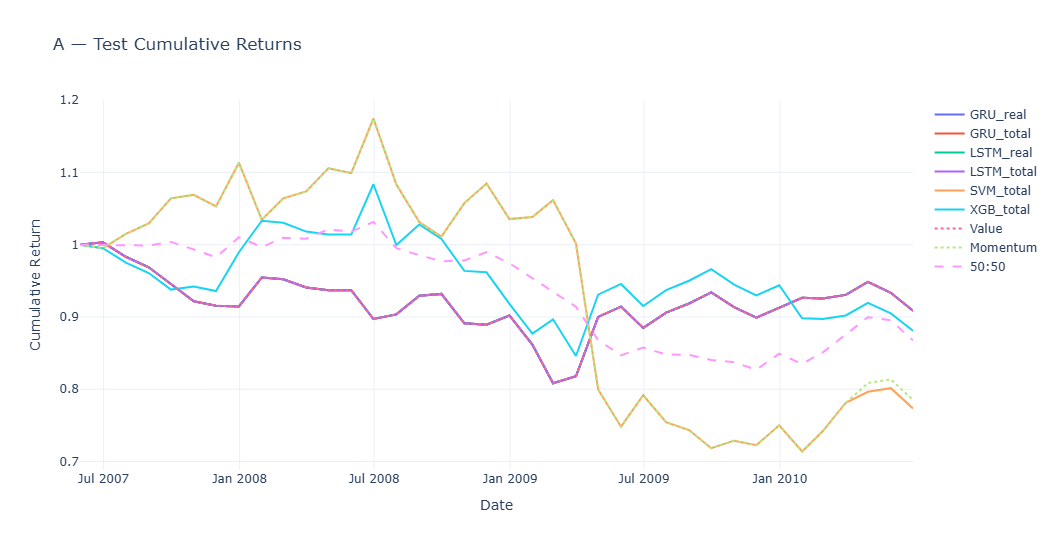

In [74]:
import plotly.graph_objects as go
from pathlib import Path

def load_rnn(model_key, tag, feat_dim):
    rnn_type, _ = tag.split("_")
    params = results[model_key][tag]["params"]
    model = RNNClassifier(rnn_type, feat_dim,
                          params["hidden"], params["layers"]).to(DEVICE)
    model.load_state_dict(torch.load(Path("saved_models")/f"{model_key}_{tag}.pt",
                                     map_location=DEVICE))
    model.eval()
    return model

def load_ml(model_key, tag):
    return joblib.load(Path("saved_models")/f"{model_key}_{tag}.pkl")

# def strategy_cum(val_ser, mom_ser, w_mom):
#     w_val = 1 - w_mom
#     strat = w_val*val_ser + w_mom*mom_ser
#     base  = strat.index[0] - pd.DateOffset(months=1)
#     return pd.concat([pd.Series([1.0], index=[base]),
#                       (1+strat).cumprod()])

def strategy_cum(val_ser: pd.Series,
                 mom_ser: pd.Series,
                 w_mom):
    """
    w_mom : • ndarray / list  — 시점별 0 or 1 예측
            • scalar (0, 0.5, 1) — 고정 weight
    """
    # ── 1) broadcast ─────────────────────────────────────────
    if np.isscalar(w_mom):
        w_mom = np.full(len(val_ser), w_mom, dtype=float)   # ← 길이 맞춰 복사
    else:
        w_mom = np.asarray(w_mom, dtype=float)
        assert len(w_mom) == len(val_ser), "weight/return length mismatch"

    # ndarray → Series 로 인덱스 정렬
    w_mom = pd.Series(w_mom, index=val_ser.index)

    # ── 2)  로그 (가끔만) ───────────────────────────────────
    if np.random.rand() < 0.05:
        print(f"[WEIGHT] MOM mean={w_mom.mean():.3f} "
              f"| p(100%)={(w_mom==1).mean():.3f} "
              f"| p(0%)={(w_mom==0).mean():.3f}")

    # ── 3) 전략 수익률 & 누적 ───────────────────────────────
    strat = (1 - w_mom) * val_ser + w_mom * mom_ser
    base  = strat.index[0] - pd.DateOffset(months=1)
    cum   = pd.concat([pd.Series([1.0], index=[base]),
                       (1 + strat).cumprod()])
    return cum


def plot_model_key(model_key: str, df_raw: pd.DataFrame):
    assets  = MODEL_SETS[model_key]
    label_a = assets[0]
    val_col, mom_col = f"VAL_{label_a}", f"MOM_{label_a}"

    df   = df_raw.loc[:'2010-06-30']
    last = df.index.max()
    cut_test = last - pd.DateOffset(years=3)

    # ---------- test 시퀀스 : label_a 만 ------------
    df_pair = df[[val_col, mom_col]].dropna()
    X_all, y_all, dates = make_sliding_sequences(df_pair)  # 2-feature
    test_m   = dates >= cut_test
    X_test   = X_all[test_m]; dates_test = dates[test_m]

    # --- 누수 검정 ---
    assert dates_test.min() >= cut_test
    assert dates_test.max() <= last
    print(f"[CHECK {model_key}] test window {dates_test.min().date()} → {dates_test.max().date()}")

    feat_dim = 2
    val_ser  = df_raw.loc[dates_test, val_col]
    mom_ser  = df_raw.loc[dates_test, mom_col]

    fig = go.Figure()

    # ---------- RNN ----------
    for tag in ["GRU_real", "GRU_total", "LSTM_real", "LSTM_total"]:
        model = load_rnn(model_key, tag, feat_dim)
        probs = []
        with torch.no_grad():
            for xb,_ in make_loader(X_test, y_all[test_m], 64):
                probs.extend(model(xb.to(DEVICE)).cpu().numpy())
        w_mom = (np.array(probs) > 0.5).astype(int)
        cum = strategy_cum(val_ser, mom_ser, w_mom)
        fig.add_trace(go.Scatter(x=cum.index, y=cum, name=tag))

    # ---------- ML ----------
    X_flat = X_test.reshape(len(X_test), INPUT_STEPS*2)      # 24-dim
    for ml in ["SVM_total", "XGB_total"]:
        mdl = load_ml(model_key, ml)
        w_mom = mdl.predict(X_flat)
        cum   = strategy_cum(val_ser, mom_ser, w_mom)
        fig.add_trace(go.Scatter(x=cum.index, y=cum, name=ml))

    # ---------- Benchmarks ----------
    for name, w in [("Value",0), ("Momentum",1), ("50:50",0.5)]:
        cum = strategy_cum(val_ser, mom_ser, w)
        style = dict(dash="dot") if name!="50:50" else dict(dash="dash")
        fig.add_trace(go.Scatter(x=cum.index, y=cum, name=name, line=style))

    fig.update_layout(title=f"{model_key} — Test Cumulative Returns",
                      template="plotly_white", xaxis_title="Date",
                      yaxis_title="Cumulative Return", width=950, height=550)
    fig.show()

# --------- 사용 예시 ----------
df_raw = load_vme_portfolios("Value and Momentum Everywhere Original Paper Data.xlsx")
plot_model_key("A", df_raw)


[CHECK B] test window 2007-06-30 → 2010-06-30
[WEIGHT] MOM mean=0.676 | p(100%)=0.676 | p(0%)=0.324


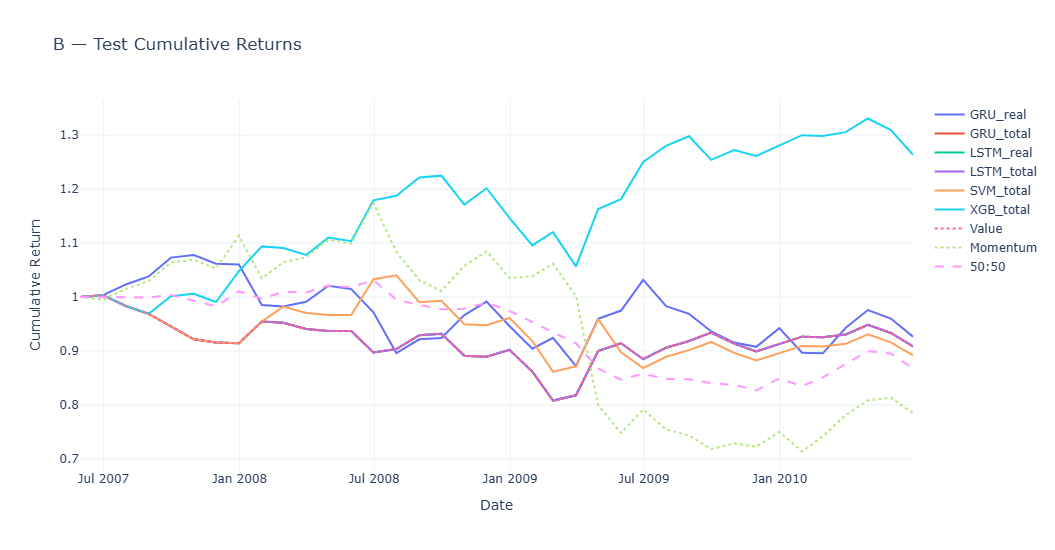

In [75]:
plot_model_key("B", df_raw)

[CHECK C] test window 2007-06-30 → 2010-06-30
[WEIGHT] MOM mean=0.973 | p(100%)=0.973 | p(0%)=0.027


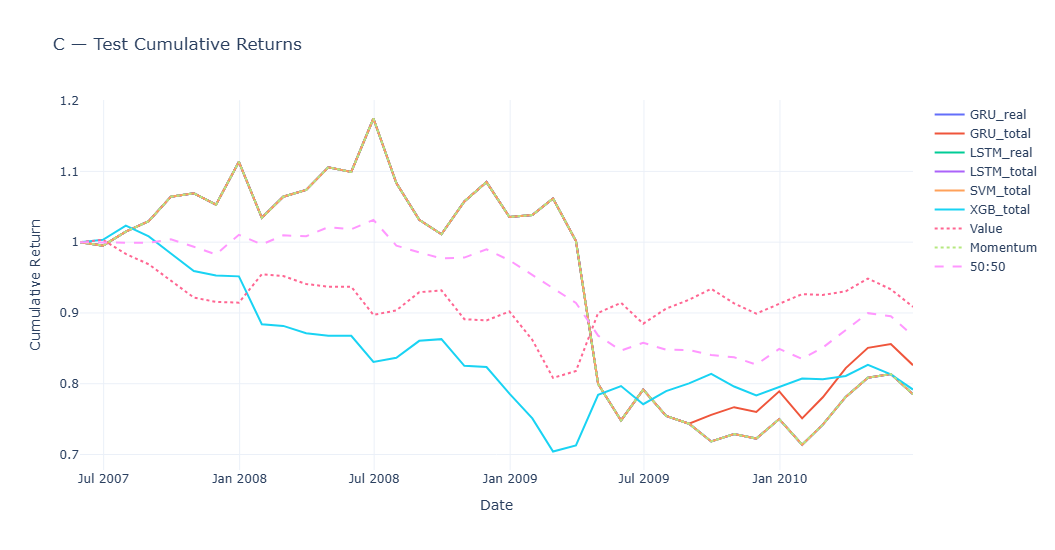

In [76]:
plot_model_key("C", df_raw)

[CHECK D] test window 2007-06-30 → 2010-06-30
[WEIGHT] MOM mean=1.000 | p(100%)=1.000 | p(0%)=0.000
[WEIGHT] MOM mean=1.000 | p(100%)=1.000 | p(0%)=0.000


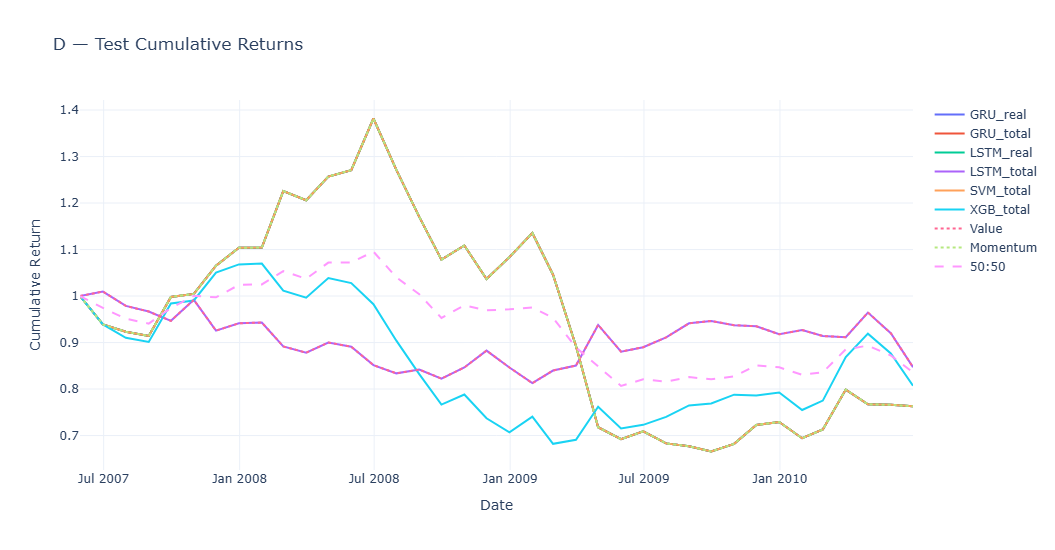

In [77]:
plot_model_key("D", df_raw)

[CHECK E] test window 2007-06-30 → 2010-06-30


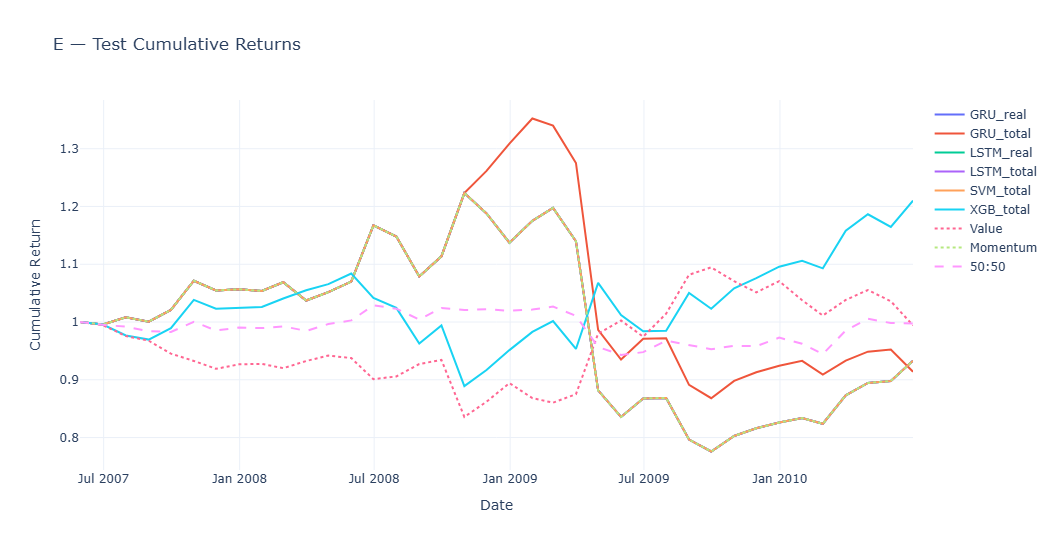

In [78]:
plot_model_key("E", df_raw)

[CHECK F] test window 2007-06-30 → 2010-06-30
[WEIGHT] MOM mean=0.500 | p(100%)=0.000 | p(0%)=0.000


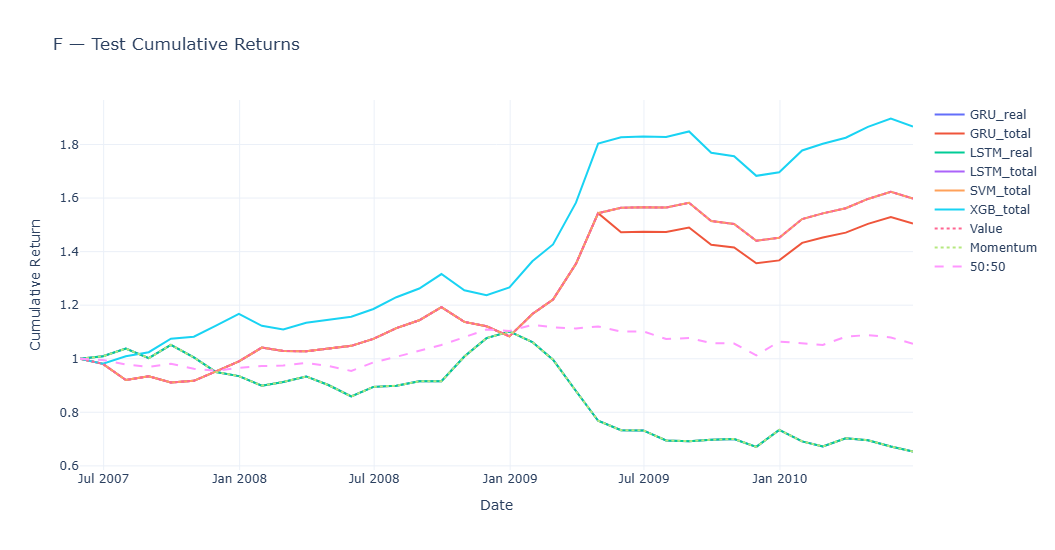

In [79]:
plot_model_key("F", df_raw)

In [52]:
run_ml??

Signature:
run_ml(
    X_train: 'np.ndarray',
    y_train: 'np.ndarray',
    X_val: 'np.ndarray',
    y_val: 'np.ndarray',
    which: 'str',
)
Docstring: <no docstring>
Source:   
def run_ml(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray, which: str):
    if which == "SVM":
        pipe, grid = Pipeline([("scaler", StandardScaler()), ("svc", SVC())]), SVM_PARAM_GRID
    else:
        pipe, grid = Pipeline([("scaler", StandardScaler()), ("xgb", XGBClassifier(objective="binary:logistic", eval_metric="logloss", use_label_encoder=False, n_jobs=-1))]), XGB_PARAM_GRID
    gs = GridSearchCV(pipe, grid, cv=TimeSeriesSplit(3), scoring="accuracy", n_jobs=-1)
    gs.fit(np.vstack([X_train, X_val]), np.hstack([y_train, y_val]))
    return gs
File:      c:\users\fawke\appdata\local\temp\ipykernel_17280\2934475873.py
Type:      function

In [54]:
import inspect
print(inspect.getsource(run_ml))

def run_ml(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray, which: str):
    if which == "SVM":
        pipe, grid = Pipeline([("scaler", StandardScaler()), ("svc", SVC())]), SVM_PARAM_GRID
    else:
        pipe, grid = Pipeline([("scaler", StandardScaler()), ("xgb", XGBClassifier(objective="binary:logistic", eval_metric="logloss", use_label_encoder=False, n_jobs=-1))]), XGB_PARAM_GRID
    gs = GridSearchCV(pipe, grid, cv=TimeSeriesSplit(3), scoring="accuracy", n_jobs=-1)
    gs.fit(np.vstack([X_train, X_val]), np.hstack([y_train, y_val]))
    return gs



In [71]:
# ── 0) 전제: build_datasets 에서 쓰는 보조함수 재사용 ─────────────
#  • make_sliding_sequences(df_pair, [asset])   (lookback=13)
#  • create_binary_labels(seqs, 0)
#  • LOOKBACK 전역 = 13

def debug_build_datasets(df: pd.DataFrame,
                         assets: List[str],
                         lookback: int = 13,
                         cutoff_last=pd.Timestamp("2010-06-30")):
    """
    * GAN 증강 완전히 배제 *
    * 학습 구간(~2004-06-29) / 검증(2004-06-30~2007-06-29) / 테스트(>=2007-06-30)
      로 정확히 분리돼 있는지 점검한다.
    """

    # ---------- 1. 단일 자산 pair ≡ label_a ----------
    label_a = assets[0]
    val_col, mom_col = f"VAL_{label_a}", f"MOM_{label_a}"
    df_pair = df[[val_col, mom_col]].dropna()
    df_pair = df_pair.loc[:cutoff_last].copy()

    # ---------- 2. 슬라이딩 시퀀스 ----------
    X_all, y_all, dates_all = make_sliding_sequences(df_pair, [label_a])
    dates_all = pd.DatetimeIndex(dates_all)

    # ---------- 3. 날짜 경계 ----------
    cutoff_test = cutoff_last - pd.DateOffset(years=3)      # 2007-06-30
    cutoff_val  = cutoff_test - pd.DateOffset(years=3)       # 2004-06-30

    idx_tr  = dates_all <  cutoff_val
    idx_val = (dates_all >= cutoff_val) & (dates_all < cutoff_test)
    idx_te  = dates_all >= cutoff_test

    # ---------- 4. 누수 검정 ----------
    print(f"\n[DEBUG]  assets={assets}  lookback={lookback}")
    print(f"        train {idx_tr.sum():4d}  {dates_all[idx_tr].min().date()} → {dates_all[idx_tr].max().date()}")
    print(f"        val   {idx_val.sum():4d}  {dates_all[idx_val].min().date()} → {dates_all[idx_val].max().date()}")
    print(f"        test  {idx_te.sum():4d}  {dates_all[idx_te].min().date()} → {dates_all[idx_te].max().date()}")

    # 4-a) 분리 정확성
    assert not (idx_tr & idx_val).any()
    assert not (idx_tr & idx_te ).any()
    assert not (idx_val & idx_te).any()
    print("        ✔ train / val / test – 날짜 교차 없음")

    # ---------- 5. 샘플 윈도우 내부 날짜 검증 ----------
    rng = np.random.default_rng(0)
    for split_name, mask in [("train", idx_tr), ("val", idx_val), ("test", idx_te)]:
        if mask.sum()==0: continue
        k = rng.integers(0, mask.sum())
        seq      = X_all[mask][k]              # (13, 2)
        end_date = dates_all[mask][k]
        start_expect = end_date - pd.DateOffset(months=lookback-1)

        # 실제 df_pair 에서 잘라서 비교
        true_window = df_pair.loc[start_expect:end_date].values
        if not np.allclose(seq, true_window, equal_nan=True):
            raise AssertionError(f"{split_name}: window mismatch @ {end_date.date()}")
    print("        ✔ 각 시퀀스 13-step → 끝 날짜와 정확히 대응")

    return {
        "X_train": X_all[idx_tr],  "y_train": y_all[idx_tr],
        "X_val"  : X_all[idx_val],"y_val"  : y_all[idx_val],
        "X_test" : X_all[idx_te],  "y_test": y_all[idx_te],
        "dates_train": dates_all[idx_tr],
        "dates_val"  : dates_all[idx_val],
        "dates_test" : dates_all[idx_te]
    }


In [72]:
df_raw    = load_vme_portfolios("Value and Momentum Everywhere Original Paper Data.xlsx")
df_scaled = pd.DataFrame({c: volatility_scale_monthly_returns(df_raw[c],36,6,0.02)
                          for c in df_raw},
                         index=df_raw.index).dropna()

# A(US)-모델 학습에 쓰인 split 구조 재검증
dbg = debug_build_datasets(df_scaled, ["US"])


[WINDOW] end=1983-06-30  start=1982-06-30

[DEBUG]  assets=['US']  lookback=13
        train  252  1983-06-30 → 2004-05-31
        val     36  2004-06-30 → 2007-05-31
        test    37  2007-06-30 → 2010-06-30
        ✔ train / val / test – 날짜 교차 없음
        ✔ 각 시퀀스 13-step → 끝 날짜와 정확히 대응
